The Optimized "Turbo" Generation Script

In [ ]:
pip install openai pandas datasets tqdm aiohttp

In [ ]:

# !pip install faker
# !pip install dateparser
# import os
# from google.colab import userdata
# from openai import AsyncOpenAI

# openai_key = userdata.get('OPENAI_API_KEY')

# # 2. Set it to the environment
# os.environ["OPENAI_API_KEY"] = openai_key
# client = AsyncOpenAI()  # requires OPENAI_API_KEY

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 55.1 MB/s eta 0:00:00
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/commands/install.py", line 447, in run
    conflicts = self._determine_conflicts(to_install)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/commands/install.py", line 578, in _determine_conflicts
    return check_install_conflicts(to_install)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/operations/check.py", line 101, in check_install_conf

KeyboardInterrupt: 

In [ ]:
pip install dateparser

In [ ]:
pip install faker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 97.3 MB/s eta 0:00:00


In [ ]:
# Generate a small HARD test set (fast) instead of the easy 10k set.
# Turn ON by setting HARD_TEST=1. Turn OFF (easy/default) with HARD_TEST=0.
import os

os.environ["HARD_TEST"] = os.getenv("HARD_TEST", "1")            # default to hard for this cell
os.environ["HARD_TOTAL_SAMPLES"] = os.getenv("HARD_TOTAL_SAMPLES", "200")

print("HARD_TEST =", os.environ["HARD_TEST"])
print("HARD_TOTAL_SAMPLES =", os.environ["HARD_TOTAL_SAMPLES"])

HARD_TEST = 1
HARD_TOTAL_SAMPLES = 200


In [ ]:
import asyncio
import json
import os
import random
import re
from datetime import datetime
from typing import Any, Optional, Tuple, List

import pandas as pd
import dateparser
from faker import Faker
from tqdm.asyncio import tqdm
from openai import AsyncOpenAI
from google.colab import userdata
import nest_asyncio

# =========================
# 0) CONFIG
# =========================

MODEL_NAME = os.getenv("OPENAI_MODEL", "gpt-4o-mini")
#TOTAL_SAMPLES = int(os.getenv("TOTAL_SAMPLES", "10000"))
TOTAL_SAMPLES = int(os.getenv("TOTAL_SAMPLES", "2000"))

# Toggle: generate a small harder test set
HARD_TEST = bool(int(os.getenv("HARD_TEST", "0")))  # set to 1 for hard test generation
HARD_TOTAL_SAMPLES = int(os.getenv("HARD_TOTAL_SAMPLES", "200"))
CONCURRENCY_LIMIT = int(os.getenv("CONCURRENCY", "10"))
MAX_RETRIES = int(os.getenv("MAX_RETRIES", "4"))
MAX_TOKENS = int(os.getenv("MAX_TOKENS", "450"))

TEMP_LOW = float(os.getenv("TEMP_LOW", "0.45"))
TEMP_HIGH = float(os.getenv("TEMP_HIGH", "0.65"))

ACTION_COUNT_PROBS = {0: 0.25, 1: 0.50, 2: 0.25}
MAX_REGEN_ATTEMPTS = int(os.getenv("MAX_REGEN_ATTEMPTS", "8"))


# If generating a harder test set, make generation slightly more tolerant and bias toward harder cases.
if HARD_TEST:
    TOTAL_SAMPLES = HARD_TOTAL_SAMPLES
    ACTION_COUNT_PROBS = {0: 0.10, 1: 0.35, 2: 0.55}
    MAX_REGEN_ATTEMPTS = max(MAX_REGEN_ATTEMPTS, 12)
    MAX_TOKENS = max(MAX_TOKENS, 520)
    TEMP_HIGH = max(TEMP_HIGH, 0.75)
SEED = int(os.getenv("SEED", "42"))
random.seed(SEED)
fake = Faker()
Faker.seed(SEED)

print("TOTAL_SAMPLES: ", TOTAL_SAMPLES)

openai_key = userdata.get("OPENAI_API_KEY")
os.environ["OPENAI_API_KEY"] = openai_key

client = AsyncOpenAI()
nest_asyncio.apply()

NO_HEADER_TOKEN = "__NO_HEADER__"

TARGET_SPECIALTIES = [
    "Orthopedic",
    "Cardiovascular / Pulmonary",
    "Gastroenterology",
    "Neurology",
    "General Medicine",
]

SPECIALTY_MAPPING = {
    "Orthopedic": [
        "MRI", "Physical Therapy", "CT Scan", "X-Ray", "Orthopedic Consult", "Joint Injection"
    ],
    "Cardiovascular / Pulmonary": [
        "Echocardiogram", "Stress Test", "Holter Monitor", "Pulmonary Function Test",
        "Cardiac MRI", "Cardiology Consult"
    ],
    "Gastroenterology": [
        "Endoscopy", "Colonoscopy", "Stool Antigen Test", "Abdominal Ultrasound",
        "GI Consult", "Breath Test"
    ],
    "Neurology": [
        "CT Scan", "EEG", "MRI Brain", "EMG", "Neurology Consult", "Sleep Study"
    ],
    "General Medicine": [
        "Blood Test", "X-Ray", "Vaccination", "Annual Physical", "Urinalysis", "Lipid Panel"
    ]
}

TOPICS = {
    "Orthopedic": [
        "ACL Tear", "Rotator Cuff Injury", "Lumbar Herniated Disc", "Ankle Sprain",
        "Carpal Tunnel Syndrome", "Hip Osteoarthritis", "Meniscus Tear", "Tennis Elbow",
        "Plantar Fasciitis", "Distal Radius Fracture",
        "Sciatica", "Scoliosis", "Bunion (Hallux Valgus)", "Patellar Tendonitis",
        "Shoulder Dislocation"
    ],
    "Cardiovascular / Pulmonary": [
        "Atrial Fibrillation", "COPD Exacerbation", "Acute Bronchitis", "Hypertension",
        "Mitral Valve Prolapse", "Pneumonia", "Congestive Heart Failure", "Deep Vein Thrombosis",
        "Asthma Attack", "Pericarditis",
        "Pulmonary Embolism", "Coronary Artery Disease", "Aortic Stenosis", "Bradycardia",
        "Syncope/Fainting"
    ],
    "Gastroenterology": [
        "GERD", "Irritable Bowel Syndrome", "Crohn's Disease", "Ulcerative Colitis",
        "Gallstones", "Celiac Disease", "Peptic Ulcer", "Diverticulitis",
        "Hemorrhoids", "Liver Cirrhosis",
        "Barrett's Esophagus", "Acute Gastritis", "Hiatal Hernia", "Chronic Pancreatitis",
        "Hepatitis C"
    ],
    "Neurology": [
        "Migraine with Aura", "Epilepsy/Seizure", "Multiple Sclerosis", "Parkinson's Disease",
        "Ischemic Stroke", "Carpal Tunnel (Neuro view)", "Vertigo/BPPV", "Alzheimer's/Dementia",
        "Bell's Palsy", "Neuropathy",
        "Myasthenia Gravis", "Trigeminal Neuralgia", "Huntington's Disease", "Guillain-Barre Syndrome",
        "Restless Leg Syndrome"
    ],
    "General Medicine": [
        "Type 2 Diabetes", "Seasonal Influenza", "Hypothyroidism", "Urinary Tract Infection",
        "Anemia", "Vitamin D Deficiency", "Hypertension", "Annual Physical",
        "Lyme Disease", "Gout",
        "Hyperlipidemia (High Cholesterol)", "Fibromyalgia", "Chronic Fatigue Syndrome", "Infectious Mononucleosis",
        "Osteoporosis"
    ]
}

STYLE_FEATURES_DICT = {
    "Narrative Voice": [
        "First Person ('I examined the patient', 'I recommend')",
        "Third Person ('Patient presents with', 'It is recommended')"
    ],
    "Temporal Precision": [
        "Vague ('History of surgery years ago', 'pain for a while')",
        "Precise ('Surgery on 12/05/2020', 'pain started at 2 PM')"
    ],
    "Certainty": [
        "Definitive ('Patient has pneumonia')",
        "Hedging/Uncertain ('Findings suggestive of possible pneumonia', 'cannot rule out')"
    ],
    "Formality": [
        "Formal/Academic (Complete sentences, proper grammar)",
        "Casual/Direct (Conversational, simple sentence structures)",
        "Standard Clinical (Professional but concise)"
    ],
    "Detail Level": [
        "Highly Detailed/Verbose (Explains rationale, describes scene)",
        "Abbreviated/Telegraphic (Notes style, fragments)",
        "Standard (Balanced)"
    ],
    "Tone": [
        "Polite/Empathetic ('Patient is a pleasant 45yo...')",
        "Clinical/Detached (Just the facts)",
        "Direct/Urgent ('Patient in distress, immediate action required')"
    ],
    "Terminology": [
        "Simple Language (Patient-friendly terms like 'heart attack')",
        "Heavy Medical Jargon (terms like 'myocardial infarction')",
        "Mixed (Standard EHR style)"
    ],
    "Structure": [
        "Standard SOAP Headers (Subjective: ... Objective: ...)",
        "Minimal Headers (HPI: ... PE: ... Imp: ...)",
        "Run-on Paragraph (No clear section breaks, one block of text)",
        "Bullet Points (Heavy use of lists for symptoms/plan)"
    ],
    "Imperfections": [
        "Perfect Grammar (textbook quality)",
        "Slight Shorthand (Standard abbreviations like 'pt', 'yo', 'hx')",
        "Heavy Shorthand (Aggressive abbrv: 'c/o CP, SOB, N/V, rec MRI')",
        "Dictation Style (Occasional missing punctuation, run-on sentences)",
        "Minor Typos (Simulated fast typing errors like 'pateint' or 'swelng')"
    ],
    "Clinician Persona": [
        "Defensive Medicine (Over-explaining rationale to justify decisions)",
        "Action-Oriented (Brief history, very detailed plan)",
        "Burnout/Hasty (Minimum viable documentation, very brief)",
        "Educator (Explaining the 'why' behind the diagnosis)"
    ]
}

PLAN_HEADERS = ["PLAN:", "RECOMMENDATIONS:", "ASSESSMENT & PLAN:", "INSTRUCTIONS:"]
NEG_PLAN_HEADERS = ["PLAN:", "RECOMMENDATIONS:", "INSTRUCTIONS:", "ASSESSMENT & PLAN:", None]
NEG_PLAN_WEIGHTS = [0.08, 0.07, 0.07, 0.08, 0.70]

# =========================
# 1) TIME PHRASES
# =========================

NUM_WORD = {
    1: "one", 2: "two", 3: "three", 4: "four", 5: "five",
    6: "six", 7: "seven", 8: "eight", 9: "nine", 10: "ten",
    11: "eleven", 12: "twelve", 13: "thirteen", 14: "fourteen"
}

TIME_TEMPLATE_WEIGHTS = [
    ("in {n} {unit}", 1.8),
    ("return in {n} {unit}", 1.2),
    ("follow up in {n} {unit}", 1.2),
    ("within {n} {unit}", 2.0),
    ("over the next {n} {unit}", 2.0),
    ("in about {n} {unit}", 1.8),
    ("in approximately {n} {unit}", 1.6),
    ("{n}-{unit_singular} follow-up", 2.0),
    ("{n} {unit_abbrev}", 1.6),
    ("in {n} {unit} time", 1.0),
]


# Extra shorthand/variant time expressions for the HARD test set.
HARD_TEST_TIME_TEMPLATES = [
    ("{n}wk f/u", 1.2),
    ("{n} wks f/u", 1.0),
    ("{n}{unit_abbrev} f/u", 1.0),
    ("f/u in {n} {unit}", 1.1),
    ("in {n}{unit_abbrev}", 1.0),          # e.g., in 6wks / in 3mos
    ("in ~{n} {unit}", 0.9),               # e.g., in ~8 weeks
    ("in approx. {n} {unit}", 0.9),
    ("in about {n}{unit_abbrev}", 0.8),
    ("in {n}-{m} weeks", 0.9),             # range
    ("in {n} to {m} weeks", 0.8),          # range
]
if HARD_TEST:
    TIME_TEMPLATE_WEIGHTS = TIME_TEMPLATE_WEIGHTS + HARD_TEST_TIME_TEMPLATES
_NUM = r"(?:\d+|one|two|three|four|five|six|seven|eight|nine|ten|eleven|twelve|thirteen|fourteen)"

def normalize_time_phrase(s: str) -> str:
    if not s:
        return s
    raw = s.strip()
    low = raw.lower().strip()

    m = re.fullmatch(rf"({_NUM})\s+(wk|wks)", low)
    if m: return f"in {m.group(1)} weeks"
    m = re.fullmatch(rf"({_NUM})\s+(mo|mos)", low)
    if m: return f"in {m.group(1)} months"

    m = re.fullmatch(rf"({_NUM})-(day|week|month)\s+follow[- ]?up", low)
    if m:
        n, unit = m.group(1), m.group(2)
        return f"in {n} {unit}s"

    m = re.fullmatch(rf"in\s+({_NUM})\s+(day|days|week|weeks|month|months)\s+time", low)
    if m: return f"in {m.group(1)} {m.group(2)}"

    m = re.fullmatch(rf"within\s+({_NUM})\s+(day|days|week|weeks|month|months)", low)
    if m: return f"in {m.group(1)} {m.group(2)}"

    m = re.fullmatch(rf"over the next\s+({_NUM})\s+(day|days|week|weeks|month|months)", low)
    if m: return f"in {m.group(1)} {m.group(2)}"

    m = re.fullmatch(rf"in\s+(about|approximately)\s+({_NUM})\s+(day|days|week|weeks|month|months)", low)
    if m: return f"in {m.group(2)} {m.group(3)}"

    return raw

def parse_relative_date(period_text: str, visit_date_str: str) -> str | None:
    if not period_text or not visit_date_str:
        return None
    try:
        base = datetime.strptime(visit_date_str, "%Y-%m-%d")
    except Exception:
        return None

    settings = {"PREFER_DATES_FROM": "future", "RELATIVE_BASE": base, "DATE_ORDER": "DMY"}

    dt = dateparser.parse(period_text, settings=settings)
    if dt:
        return dt.strftime("%Y-%m-%d")

    norm = normalize_time_phrase(period_text)
    if norm != period_text:
        dt2 = dateparser.parse(norm, settings=settings)
        if dt2:
            return dt2.strftime("%Y-%m-%d")

    return None

_last_templates: list[str] = []

def sample_period_text() -> str:
    unit_type = random.choice(["days", "weeks", "months"])
    if unit_type == "days":
        n = random.randint(1, 14)
        unit_singular, unit_abbrev = "day", "days"
    elif unit_type == "weeks":
        n = random.randint(1, 12)
        unit_singular, unit_abbrev = "week", "wks"
    else: # months
        n = random.randint(1, 12)
        unit_singular, unit_abbrev = "month", "mos"

    unit = unit_singular if n == 1 else unit_singular + "s"
    n_str = NUM_WORD[n] if (random.random() < 0.35 and n in NUM_WORD) else str(n)

    templates, weights = zip(*TIME_TEMPLATE_WEIGHTS)
    weights = list(weights)

    for i, t in enumerate(templates):
        if t in _last_templates:
            weights[i] *= 0.45

    template = random.choices(list(templates), weights=weights, k=1)[0]
    _last_templates.append(template)
    if len(_last_templates) > 6:
        _last_templates.pop(0)

    # Prepare format arguments dynamically
    format_kwargs = {
        'n': n_str,
        'unit': unit,
        'unit_singular': unit_singular,
        'unit_abbrev': unit_abbrev
    }

    if '{m}' in template:
        # If a range template is chosen, ensure unit_type is 'weeks' and n is appropriate.
        # This will prevent the ValueError when n=14.
        unit_type = "weeks"
        n = random.randint(1, 12) # Max n for weeks is 12
        unit_singular, unit_abbrev = "week", "wks"
        unit = unit_singular if n == 1 else unit_singular + "s"
        n_str = NUM_WORD[n] if (random.random() < 0.35 and n in NUM_WORD) else str(n)

        # Update format_kwargs for the potentially re-generated n and unit
        format_kwargs['n'] = n_str
        format_kwargs['unit'] = unit
        format_kwargs['unit_singular'] = unit_singular
        format_kwargs['unit_abbrev'] = unit_abbrev

        # Generate a second number for range-based templates
        # m_val will now be safe as n max is 12 here
        m_val = random.randint(n + 1, min(n + 5, 14))
        m_str = NUM_WORD[m_val] if (random.random() < 0.35 and m_val in NUM_WORD) else str(m_val)
        format_kwargs['m'] = m_str

    return template.format(**format_kwargs)

def sample_period_text_with_date(visit_date: str, tries: int = 12) -> Tuple[str, str]:
    for _ in range(tries):
        pt = sample_period_text()
        pd = parse_relative_date(pt, visit_date)
        if pd is not None:
            return pt, pd
    fallback_pt = "in 7 days"
    fallback_pd = parse_relative_date(fallback_pt, visit_date)
    return fallback_pt, fallback_pd

# =========================
# 2) STYLE + PLAN VARIANT
# =========================

PLAN_VARIANTS = ["A", "B", "C", "D", "E", "F"]
PLAN_VARIANT_WEIGHTS = [1.2, 1.2, 1.0, 1.0, 1.0, 1.0]  # A/B slightly more common

def sample_style_features(min_k=3, max_k=5) -> list[dict[str, str]]:
    keys = list(STYLE_FEATURES_DICT.keys())
    k = random.randint(min_k, max_k)
    chosen = random.sample(keys, k=k)
    return [{"key": key, "value": random.choice(STYLE_FEATURES_DICT[key])} for key in chosen]

# =========================
# 3) SKELETON
# =========================

def weighted_choice(probs: dict[int, float]) -> int:
    r = random.random()
    cum = 0.0
    for k in sorted(probs.keys()):
        cum += probs[k]
        if r <= cum:
            return k
    return 1

def choose_negative_header():
    return random.choices(NEG_PLAN_HEADERS, weights=NEG_PLAN_WEIGHTS, k=1)[0]

def reset_action_spans(sk: dict[str, Any]) -> None:
    for a in sk.get("actions_gt", []):
        a["time_char_start"] = None
        a["time_char_end"] = None
        a["action_char_start"] = None
        a["action_char_end"] = None

def make_skeleton() -> dict[str, Any]:
    specialty = random.choice(TARGET_SPECIALTIES)
    topic = random.choice(TOPICS[specialty])
    visit_date_obj = fake.date_between(start_date="-2y", end_date="today")
    visit_date = visit_date_obj.strftime("%Y-%m-%d")

    num_actions = weighted_choice(ACTION_COUNT_PROBS)
    plan_header = choose_negative_header() if num_actions == 0 else random.choice(PLAN_HEADERS)
    style_features = sample_style_features()
    plan_variant = random.choices(PLAN_VARIANTS, weights=PLAN_VARIANT_WEIGHTS, k=1)[0]

    actions_gt = []
    if num_actions > 0:
        chosen_actions = random.sample(SPECIALTY_MAPPING[specialty], k=num_actions)

        used_period_texts = set()
        for act in chosen_actions:
            pt, pd = sample_period_text_with_date(visit_date)

            if num_actions == 2:
                tries = 0
                while pt in used_period_texts and tries < 10:
                    pt, pd = sample_period_text_with_date(visit_date)
                    tries += 1

            used_period_texts.add(pt)

            actions_gt.append({
                "action": act,
                "period_text": pt,
                "period_date": pd,
                "time_char_start": None,
                "time_char_end": None,
                "action_char_start": None,
                "action_char_end": None,
            })

    return {
        "specialty": specialty,
        "topic": topic,
        "visit_date": visit_date,
        "plan_header": plan_header,
        "style_features": style_features,
        "plan_variant": plan_variant,
        "num_actions": num_actions,
        "actions_gt": actions_gt,
    }

# =========================
# 4) PROMPT
# =========================

POSITIVE_PLAN_HINT = """
PLAN SECTION (REALISTIC + DIVERSE, BUT CONTROLLED)

You are given a list of SCHEDULED follow-up items (closed-set actions + their time phrases).
Your job: write a natural plan section that includes these items, with realistic wording/format.

HARD RULES:
1) The plan MUST contain EXACTLY {num_actions} scheduled follow-up items from the CLOSED LIST below.
2) Do NOT introduce any additional scheduled tests/imaging/labs/referrals/consults/therapy/procedures beyond the CLOSED LIST.
3) Each scheduled ACTION STRING must appear EXACTLY ONCE in the plan section (case-insensitive ok; spelling must match).
4) Each scheduled TIME PHRASE must appear EXACTLY ONCE in the plan section (copy exactly; no paraphrase; no truncation).
5) Action and time do NOT need to be adjacent. Time may appear before action or after action.
6) Do NOT repeat any scheduled action or scheduled time elsewhere in the note.

REALISM / HARDENING:
- Include 1–2 extra NON-scheduled time expressions somewhere in the note.
  These MUST be history/duration/past timing only (e.g., "for 3 days", "2 weeks ago", "since last month").
  Do NOT write extra future follow-up scheduling like "follow up in X", "return in X", "recheck in X" beyond the CLOSED LIST.

FORMAT VARIANTS:
You MUST follow the chosen variant letter: {variant}

A) Inline per item:
   - ACTION — TIME
B) Time-first per item:
   - TIME: ACTION
C) Mixed sentence:
   "Plan: TIME, ACTION; TIME2, ACTION2."
D) Parentheses:
   - ACTION (TIME)
E) Colon grouping:
   "Diagnostics: ACTION (TIME); ACTION2 (TIME2)."
F) Split association:
   - ACTION.
     TIME.

CLOSED LIST (must include each ACTION and each TIME exactly once; order is free):
{closed_list}

SELF-CHECK (silently):
- Exactly {num_actions} scheduled items.
- Each scheduled action appears exactly once in plan.
- Each scheduled time phrase appears exactly once in plan.
- No extra scheduled follow-up phrases beyond the list.
""".strip()


HARD_EXTRA_HINT = """
HARDENING (HARD TEST MODE)
In addition to the scheduled items above, add the following distractors to make extraction harder:
- Add 2-4 extra time expressions elsewhere in the note (NOT scheduled follow-ups).
  Mix:
  * at least 1 past time (e.g., "2 weeks ago", "for 3 days")
  * at least 1 future-looking non-scheduling time (e.g., "if not improved in 48 hours, go to ER")
  * at least 1 shorthand/abbrev time (e.g., "four mos", "8wk")
- Mention 1-2 other CLOSED-SET actions in a clearly past/negated context outside the plan
  (examples: "MRI last year was normal", "CT scan previously negative", "no need for colonoscopy today").
  Do NOT schedule these distractor actions.
- At least ONE scheduled item must have the time phrase and action separated by a sentence (not adjacent).
""".strip()

NEGATIVE_PLAN_HINT = """
IMPORTANT: NO SCHEDULED ACTIONS

HARD RULES:
- Do NOT schedule any future tests/imaging/labs/referrals/consults/therapy/procedures.
- Do NOT use future follow-up timing language (forbidden examples: "in 2 weeks", "return in", "recheck", "follow up in",
  "next week", "within 3 months", "over the next", "schedule", "order", "plan for").
- You MAY mention past timing in history (e.g., "symptoms started 3 days ago", "MRI last month") but it must clearly be past.

STRUCTURE:
- Write the note naturally.
- You may include a plan header or omit it (depending on skeleton).
- End with general advice/return precautions with NO future timing.
""".strip()

NO_SIGNATURE_RULE = """
FORMAT RESTRICTIONS:
- No greeting/letter style.
- No signature block, no clinician contact details.
""".strip()

def build_prompt(sk: dict[str, Any]) -> str:
    style_lines = "\n".join([f"- {s['key']}: {s['value']}" for s in sk["style_features"]])

    if sk["num_actions"] == 0:
        if sk.get("plan_header") is None:
            plan_instruction = f"""
{NEGATIVE_PLAN_HINT}

STRUCTURE:
- Do NOT add a plan header.
- Finish with 1–2 short general advice sentences.
""".strip()
        else:
            plan_instruction = f"""
{NEGATIVE_PLAN_HINT}

PLAN SECTION:
- Include the header line exactly: {sk["plan_header"]}
- After that header, write only general advice/return precautions (no future timing).
""".strip()
    else:
        closed_list = "\n".join([
            f'- ACTION: "{a["action"]}" | TIME: "{a["period_text"]}"'
            for a in sk["actions_gt"]
        ])
        plan_instruction = f"""
You MUST include a plan section near the end.

PLAN HEADER:
- Use this exact header line: {sk["plan_header"]}

{(POSITIVE_PLAN_HINT + ("\n\n" + HARD_EXTRA_HINT if HARD_TEST else "")).format(
    num_actions=sk["num_actions"],
    closed_list=closed_list,
    variant=sk["plan_variant"],
)}
""".strip()

    # Define length_words here
    length_words = "160–280 words" # Default value, can be made dynamic if needed

    prompt = f"""
You are an expert clinician writing a realistic outpatient note.

REQUIRED: Include this exact line ONE TIME at the beginning:
Date of Visit: {sk['visit_date']}

Context:
- Specialty: {sk['specialty']}
- Topic/Condition: {sk['topic']}

Style features (use naturally; do NOT list them explicitly):
{style_lines}

Length: {length_words}. If you need to shorten, shorten the narrative—not the plan lines.

{plan_instruction}

{NO_SIGNATURE_RULE}

Return plain text only (no Markdown).
""".strip()

    return prompt

# =========================
# 5) API CALL
# =========================

def sample_temperature() -> float:
    return random.uniform(TEMP_LOW, TEMP_HIGH)

async def generate_note_once(sem: asyncio.Semaphore, sk: dict[str, Any]) -> tuple[Optional[str], Optional[str]]:
    prompt = build_prompt(sk)
    last_err = None

    for attempt in range(MAX_RETRIES):
        try:
            async with sem:
                resp = await client.chat.completions.create(
                    model=MODEL_NAME,
                    messages=[
                        {"role": "system", "content": "Write realistic outpatient clinical notes. Follow constraints while keeping natural style."},
                        {"role": "user", "content": prompt},
                    ],
                    temperature=sample_temperature(),
                    max_tokens=MAX_TOKENS,
                )
            text = (resp.choices[0].message.content or "").strip()
            if not text:
                raise RuntimeError("empty_response")
            return text, None
        except Exception as e:
            last_err = repr(e)
            await asyncio.sleep((2 ** attempt) * 0.6 + random.random() * 0.2)

    return None, last_err

# =========================
# 6) MATCHING HELPERS (fix overlaps like MRI vs MRI Brain)
# =========================

def _flex_pat_from_literal(lit: str, *, ignore_case: bool, word_boundary: bool) -> re.Pattern:
    """
    Turns a literal string into a regex that allows flexible whitespace.
    Optionally adds word boundaries (non-alnum boundaries) around the whole phrase.
    """
    escaped = re.escape(lit)
    escaped = escaped.replace(r"\\ ", r"\\s+")
    flags = re.IGNORECASE if ignore_case else 0

    if word_boundary:
        # non-alphanumeric boundaries (so "MRI" doesn't match inside "XMRIY")
        pattern = rf"(?<![A-Za-z0-9]){escaped}(?![A-Za-z0-9])"
    else:
        pattern = escaped

    return re.compile(pattern, flags=flags)

def find_all_spans(pat: re.Pattern, text: str) -> List[Tuple[int, int]]:
    return [m.span() for m in pat.finditer(text)]

def spans_overlap(a: Tuple[int, int], b: Tuple[int, int]) -> bool:
    return not (a[1] <= b[0] or b[1] <= a[0])

def has_exact_visit_date_line(note: str, visit_date: str) -> bool:
    """
    Must appear exactly once and near the beginning.
    """
    if not note:
        return False
    required = f"Date of Visit: {visit_date}"
    if note.count(required) != 1:
        return False
    # also require it within first ~200 chars (top of note)
    return note.find(required) >= 0 and note.find(required) < 200

# =========================
# 7) VALIDATE + ASSIGN SPANS
# =========================

# Extra "future follow-up" phrases we DO NOT want beyond allowed list
BANNED_FOLLOWUP_STYLE_RE = re.compile(
    r"\\b(follow[- ]?up in|return in|recheck in|come back in|see you in|schedule (an|a)?|"
    r"book (an|a)?|set up (an|a)?|call (the )?office in)\\b",
    flags=re.IGNORECASE,
)

def get_all_known_actions() -> List[str]:
    all_known = []
    for acts in SPECIALTY_MAPPING.values():
        all_known.extend(acts)
    # longest first helps overlap handling conceptually
    all_known = sorted(set(all_known), key=lambda x: -len(x))
    return all_known

ALL_KNOWN_ACTIONS = get_all_known_actions()

def assign_spans_in_note(sk: dict[str, Any], note: str) -> Tuple[bool, dict[str, Any]]:
    """
    Option C (realistic/harder):
    - allow extra time expressions anywhere (including plan), BUT
    - forbid extra scheduled-followup phrasing beyond the closed list.
    - forbid extra CLOSED-SET action names in the plan section beyond allowed actions.
    - require each allowed action and each allowed period_text appear EXACTLY ONCE in plan section.
    """
    reset_action_spans(sk)

    span_info = {
        "plan_header_start_char": None,
        "plan_header_end_char": None,
        "plan_section_start_char": None,
        "plan_section_end_char": None,
        "span_error": "",
    }

    plan_header = sk.get("plan_header", None)

    # ---- Plan header / plan section bounds
    if plan_header is None:
        # No plan section exists
        if sk["num_actions"] > 0:
            span_info["span_error"] = "positive_but_no_plan_header"
            return False, span_info
        return True, span_info

    # Require header exactly once for clean spans
    if note.count(plan_header) != 1:
        span_info["span_error"] = "plan_header_not_exactly_once"
        return False, span_info

    hs = note.find(plan_header)
    he = hs + len(plan_header)
    span_info["plan_header_start_char"] = hs
    span_info["plan_header_end_char"] = he
    span_info["plan_section_start_char"] = he
    span_info["plan_section_end_char"] = len(note)

    plan_text = note[he:]

    # ---- Negatives: after header, only general advice, no future timing & no scheduling phrases
    if sk["num_actions"] == 0:
        # For negative-with-header: forbid future scheduling language in plan section
        if BANNED_FOLLOWUP_STYLE_RE.search(plan_text):
            span_info["span_error"] = "neg_plan_contains_future_followup_language"
            return False, span_info
        # Also forbid explicit "in X weeks/months" etc. (future-looking) after header
        future_like = re.search(r"\\b(in|within|over the next)\\s+\\w+\\s+(day|days|week|weeks|month|months)\\b", plan_text, re.I)
        if future_like:
            span_info["span_error"] = "neg_plan_contains_future_time_phrase"
            return False, span_info
        return True, span_info

    # ---- Positives: enforce allowed actions/times exactly once in plan section
    allowed_actions = [a["action"] for a in sk["actions_gt"]]
    allowed_times = [a["period_text"] for a in sk["actions_gt"]]

    # 1) Each allowed time phrase appears exactly once in plan_text AND exactly once in whole note
    allowed_time_spans_in_plan = []
    for t in allowed_times:
        tp = _flex_pat_from_literal(t, ignore_case=True, word_boundary=False)
        spans_plan = find_all_spans(tp, plan_text)
        spans_note = find_all_spans(tp, note)
        if len(spans_plan) != 1:
            span_info["span_error"] = f"allowed_time_not_exactly_once_in_plan::{t}"
            return False, span_info
        if len(spans_note) != 1:
            span_info["span_error"] = f"allowed_time_repeated_in_note::{t}"
            return False, span_info
        allowed_time_spans_in_plan.append(spans_plan[0])

    # 2) Each allowed action appears exactly once in plan_text
    allowed_action_spans_in_plan = {}
    for act in allowed_actions:
        ap = _flex_pat_from_literal(act, ignore_case=True, word_boundary=True)
        spans_plan = find_all_spans(ap, plan_text)
        if len(spans_plan) != 1:
            span_info["span_error"] = f"allowed_action_not_exactly_once_in_plan::{act}"
            return False, span_info
        allowed_action_spans_in_plan[act] = spans_plan[0]

    # 3) Forbid extra closed-set actions in plan section (handle overlaps via span overlap)
    # Build coverage of allowed action spans
    allowed_spans_list = list(allowed_action_spans_in_plan.values())

    extra_closed = False # Initialize extra_closed here
    for other_act in ALL_KNOWN_ACTIONS:
        if other_act in allowed_actions: # Corrected: check against allowed_actions
            continue
        op = _flex_pat_from_literal(other_act, ignore_case=True, word_boundary=True)
        spans_other = find_all_spans(op, plan_text)
        for sp in spans_other:
            # If this match is entirely inside an allowed action span, it's not "extra"
            if any(spans_overlap(sp, allowed_sp) for allowed_sp in allowed_spans_list):
                continue
            if sp:
                extra_closed = True
                break
        if extra_closed:
            break

    # If after checking all other_acts, an extra_closed was found, then it's an error
    if extra_closed:
        # The traceback indicated the error was at `if extra_closed: break` outside the inner loop.
        # The original code's intent was to return False, span_info if any extra_closed was found.
        # This block was missing after the loops finished.
        span_info["span_error"] = f"extra_closed_set_action_in_plan::{other_act}"
        return False, span_info

    # 4) Forbid extra future follow-up scheduling language beyond allowed list
    # Scrub allowed time strings then check banned followup phrases.
    scrubbed = plan_text
    for t in allowed_times:
        tp = _flex_pat_from_literal(t, ignore_case=True, word_boundary=False)
        scrubbed = tp.sub("<<<ALLOWED_TIME>>>", scrubbed)

    if BANNED_FOLLOWUP_STYLE_RE.search(scrubbed):
        span_info["span_error"] = "extra_future_followup_language_in_plan"
        return False, span_info

    # ---- Assign spans back to GT (global char indices)
    base = he
    for a in sk["actions_gt"]:
        act = a["action"]
        t = a["period_text"]

        as0, ae0 = allowed_action_spans_in_plan[act]
        tp = _flex_pat_from_literal(t, ignore_case=True, word_boundary=False)
        ts0, te0 = find_all_spans(tp, plan_text)[0]

        a["action_char_start"] = base + as0
        a["action_char_end"] = base + ae0
        a["time_char_start"] = base + ts0
        a["time_char_end"] = base + te0

    return True, span_info

# =========================
# 8) AUDIT (optional, now consistent w/ overlap)
# =========================

def _get_plan_section_text(row: dict) -> str:
    note = row.get("note_text", "") or ""
    s = row.get("plan_section_start_char", None)
    e = row.get("plan_section_end_char", None)
    if isinstance(s, int) and isinstance(e, int) and 0 <= s <= e <= len(note):
        return note[s:e]
    return ""  # no plan section

def audit_batch(df_batch: pd.DataFrame) -> pd.DataFrame:
    """
    Adds audit flags (informational). We do NOT enforce "extra_time_in_plan near 0"
    because Option C intentionally allows distractor times.
    """
    audit_extra_closed_action = []
    audit_extra_future_followup_language = []

    for _, row in df_batch.iterrows():
        plan_text = _get_plan_section_text(row.to_dict())
        num_actions = int(row.get("num_actions", 0))

        try:
            actions_gt = json.loads(row.get("actions_gt", "[]") or "[]")
        except Exception:
            actions_gt = []

        allowed_actions = [a.get("action", "") for a in actions_gt if a.get("action")]
        allowed_times = [a.get("period_text", "") for a in actions_gt if a.get("period_text")]

        # Scrub allowed times then check banned followup language
        scrubbed = plan_text
        for t in allowed_times:
            tp = _flex_pat_from_literal(t, ignore_case=True, word_boundary=False)
            scrubbed = tp.sub("<<<ALLOWED_TIME>>>", scrubbed)

        has_extra_future_followup = bool(BANNED_FOLLOWUP_STYLE_RE.search(scrubbed)) if num_actions > 0 else False

        # Extra closed-set actions in plan (overlap-aware)
        allowed_spans = []
        for act in allowed_actions:
            ap = _flex_pat_from_literal(act, ignore_case=True, word_boundary=True)
            spans = find_all_spans(ap, plan_text)
            allowed_spans.extend(spans)

        extra_closed = False
        for other_act in ALL_KNOWN_ACTIONS:
            if other_act in allowed_actions: # Corrected: check against allowed_actions
                continue
            op = _flex_pat_from_literal(other_act, ignore_case=True, word_boundary=True)
            spans_other = find_all_spans(op, plan_text)
            for sp in spans_other:
                # If this match is entirely inside an allowed action span, it's not "extra"
                if any(spans_overlap(sp, asp) for asp in allowed_spans):
                    continue
                if sp:
                    extra_closed = True
                    break
            if extra_closed:
                break

        # For negatives: we mainly care about future follow-up language; closed-set actions in plan are suspicious too
        if num_actions == 0 and plan_text:
            if BANNED_FOLLOWUP_STYLE_RE.search(plan_text):
                has_extra_future_followup = True

        audit_extra_closed_action.append(extra_closed)
        audit_extra_future_followup_language.append(has_extra_future_followup)

    df_batch = df_batch.copy()
    df_batch["audit_extra_closed_set_action_in_plan"] = audit_extra_closed_action
    df_batch["audit_extra_future_followup_language_in_plan"] = audit_extra_future_followup_language
    return df_batch

# =========================
# 9) MAIN
# =========================

async def main():
    sem = asyncio.Semaphore(CONCURRENCY_LIMIT)
    rows = []

    pbar = tqdm(total=TOTAL_SAMPLES)
    pbar.set_description("Generated notes")

    async def one_sample(i: int):
        sk = make_skeleton()

        last_err = None
        last_note = None
        last_span_info = None

        for _ in range(MAX_REGEN_ATTEMPTS):
            note, err = await generate_note_once(sem, sk)
            last_note, last_err = note, err

            if not note:
                continue

            if not has_exact_visit_date_line(note, sk["visit_date"]):
                last_span_info = {
                    "plan_header_start_char": None,
                    "plan_header_end_char": None,
                    "plan_section_start_char": None,
                    "plan_section_end_char": None,
                    "span_error": "missing_or_duplicate_visit_date_line",
                }
                continue

            ok, span_info = assign_spans_in_note(sk, note)
            last_span_info = span_info
            if ok:
                break

        span_info = last_span_info or {
            "plan_header_start_char": None,
            "plan_header_end_char": None,
            "plan_section_start_char": None,
            "plan_section_end_char": None,
            "span_error": "no_note_or_no_spaninfo",
        }

        plan_header_is_none = (sk["plan_header"] is None)
        plan_header_value = NO_HEADER_TOKEN if plan_header_is_none else sk["plan_header"]

        return {
            "note_text": last_note if last_note else "",
            "api_error": last_err if last_err else "",
            "specialty": sk["specialty"],
            "topic": sk["topic"],
            "visit_date": sk["visit_date"],

            "plan_variant": sk["plan_variant"],

            "plan_header_is_none": plan_header_is_none,
            "plan_header_value": plan_header_value,

            "num_actions": sk["num_actions"],

            # spans (None -> empty cell in CSV)
            "plan_header_start_char": span_info["plan_header_start_char"],
            "plan_header_end_char": span_info["plan_header_end_char"],
            "plan_section_start_char": span_info["plan_section_start_char"],
            "plan_section_end_char": span_info["plan_section_end_char"],
            "span_error": span_info.get("span_error", ""),

            "actions_gt": json.dumps(sk["actions_gt"], ensure_ascii=False),
            "style_features": json.dumps(sk["style_features"], ensure_ascii=False),
        }

    batch_size = CONCURRENCY_LIMIT * 5
    created = 0

    while created < TOTAL_SAMPLES:
        n = min(batch_size, TOTAL_SAMPLES - created)
        batch_rows = await asyncio.gather(*[one_sample(created + j) for j in range(n)])
        df_batch = pd.DataFrame(batch_rows)

        df_batch = audit_batch(df_batch)

        rows.extend(df_batch.to_dict(orient="records"))
        created += n
        pbar.update(n)

        ok_span_rate = (df_batch["span_error"] == "").mean()
        api_empty_rate = (df_batch["note_text"] == "").mean()
        extra_action_rate = df_batch["audit_extra_closed_set_action_in_plan"].mean()
        extra_followup_rate = df_batch["audit_extra_future_followup_language_in_plan"].mean()

        print(
            f"\n[Batch stats] span_ok_rate={ok_span_rate:.2f} api_empty={api_empty_rate:.2f} "
            f"extra_closed_action_in_plan={extra_action_rate:.2f} "
            f"extra_future_followup_language_in_plan={extra_followup_rate:.2f}"
        )

    pbar.close()

    df = pd.DataFrame(rows)
    out_path = f"synthetic_clinical_notes_{'hard_' if HARD_TEST else ''}{TOTAL_SAMPLES}.csv"
    df.to_csv(out_path, index=False)
    print("\n✅ Saved:", out_path)

    print("\nSpan quality summary:")
    print("span_ok_rate:", (df["span_error"] == "").mean())
    print("span_error top:", df["span_error"].value_counts().head(10))

    print("\nAudit summary:")
    print("extra_closed_action_in_plan:", df["audit_extra_closed_set_action_in_plan"].mean())
    print("extra_future_followup_language_in_plan:", df["audit_extra_future_followup_language_in_plan"].mean())

    print("\nnum_actions counts:")
    print(df["num_actions"].value_counts(dropna=False))

    print("\nCSV reload tip:")
    print("pd.read_csv(..., keep_default_na=False)")

if __name__ == "__main__":
    asyncio.run(main())

TOTAL_SAMPLES:  2000


Generated notes:   2%|▎         | 50/2000 [01:03<40:58,  1.26s/it]


[Batch stats] span_ok_rate=1.00 api_empty=0.00 extra_closed_action_in_plan=0.00 extra_future_followup_language_in_plan=0.00


Generated notes:   5%|▌         | 100/2000 [02:14<43:07,  1.36s/it]


[Batch stats] span_ok_rate=0.98 api_empty=0.00 extra_closed_action_in_plan=0.00 extra_future_followup_language_in_plan=0.00


Generated notes:   8%|▊         | 150/2000 [03:28<43:35,  1.41s/it]


[Batch stats] span_ok_rate=0.98 api_empty=0.00 extra_closed_action_in_plan=0.00 extra_future_followup_language_in_plan=0.00


Generated notes:  10%|█         | 200/2000 [04:41<42:58,  1.43s/it]


[Batch stats] span_ok_rate=0.98 api_empty=0.00 extra_closed_action_in_plan=0.00 extra_future_followup_language_in_plan=0.00


Generated notes:  12%|█▎        | 250/2000 [05:30<37:02,  1.27s/it]


[Batch stats] span_ok_rate=1.00 api_empty=0.00 extra_closed_action_in_plan=0.00 extra_future_followup_language_in_plan=0.00


Generated notes:  15%|█▌        | 300/2000 [06:14<32:17,  1.14s/it]


[Batch stats] span_ok_rate=1.00 api_empty=0.00 extra_closed_action_in_plan=0.00 extra_future_followup_language_in_plan=0.00


Generated notes:  18%|█▊        | 350/2000 [07:30<34:37,  1.26s/it]


[Batch stats] span_ok_rate=0.96 api_empty=0.00 extra_closed_action_in_plan=0.00 extra_future_followup_language_in_plan=0.00


Generated notes:  20%|██        | 400/2000 [08:32<33:25,  1.25s/it]


[Batch stats] span_ok_rate=0.98 api_empty=0.00 extra_closed_action_in_plan=0.00 extra_future_followup_language_in_plan=0.00


Generated notes:  22%|██▎       | 450/2000 [09:31<31:50,  1.23s/it]


[Batch stats] span_ok_rate=0.98 api_empty=0.00 extra_closed_action_in_plan=0.00 extra_future_followup_language_in_plan=0.00


Generated notes:  25%|██▌       | 500/2000 [10:40<31:57,  1.28s/it]


[Batch stats] span_ok_rate=0.98 api_empty=0.00 extra_closed_action_in_plan=0.00 extra_future_followup_language_in_plan=0.00


Generated notes:  28%|██▊       | 550/2000 [11:48<31:31,  1.30s/it]


[Batch stats] span_ok_rate=1.00 api_empty=0.00 extra_closed_action_in_plan=0.00 extra_future_followup_language_in_plan=0.00


Generated notes:  30%|███       | 600/2000 [13:06<32:09,  1.38s/it]


[Batch stats] span_ok_rate=0.96 api_empty=0.00 extra_closed_action_in_plan=0.00 extra_future_followup_language_in_plan=0.00


Generated notes:  32%|███▎      | 650/2000 [14:22<32:04,  1.43s/it]


[Batch stats] span_ok_rate=0.96 api_empty=0.00 extra_closed_action_in_plan=0.00 extra_future_followup_language_in_plan=0.00


Generated notes:  35%|███▌      | 700/2000 [15:28<30:07,  1.39s/it]


[Batch stats] span_ok_rate=1.00 api_empty=0.00 extra_closed_action_in_plan=0.00 extra_future_followup_language_in_plan=0.00


Generated notes:  38%|███▊      | 750/2000 [16:34<28:31,  1.37s/it]


[Batch stats] span_ok_rate=1.00 api_empty=0.00 extra_closed_action_in_plan=0.00 extra_future_followup_language_in_plan=0.00


Generated notes:  40%|████      | 800/2000 [17:35<26:32,  1.33s/it]


[Batch stats] span_ok_rate=1.00 api_empty=0.00 extra_closed_action_in_plan=0.00 extra_future_followup_language_in_plan=0.00


Generated notes:  42%|████▎     | 850/2000 [18:50<26:26,  1.38s/it]


[Batch stats] span_ok_rate=0.98 api_empty=0.00 extra_closed_action_in_plan=0.00 extra_future_followup_language_in_plan=0.00


Generated notes:  45%|████▌     | 900/2000 [20:01<25:26,  1.39s/it]


[Batch stats] span_ok_rate=1.00 api_empty=0.00 extra_closed_action_in_plan=0.00 extra_future_followup_language_in_plan=0.00


Generated notes:  48%|████▊     | 950/2000 [21:03<23:31,  1.34s/it]


[Batch stats] span_ok_rate=1.00 api_empty=0.00 extra_closed_action_in_plan=0.00 extra_future_followup_language_in_plan=0.00


Generated notes:  50%|█████     | 1000/2000 [22:03<21:40,  1.30s/it]


[Batch stats] span_ok_rate=1.00 api_empty=0.00 extra_closed_action_in_plan=0.00 extra_future_followup_language_in_plan=0.00


Generated notes:  52%|█████▎    | 1050/2000 [23:02<20:03,  1.27s/it]


[Batch stats] span_ok_rate=1.00 api_empty=0.00 extra_closed_action_in_plan=0.00 extra_future_followup_language_in_plan=0.00


Generated notes:  55%|█████▌    | 1100/2000 [23:50<17:34,  1.17s/it]


[Batch stats] span_ok_rate=1.00 api_empty=0.00 extra_closed_action_in_plan=0.00 extra_future_followup_language_in_plan=0.00


Generated notes:  57%|█████▊    | 1150/2000 [24:42<16:03,  1.13s/it]


[Batch stats] span_ok_rate=0.98 api_empty=0.00 extra_closed_action_in_plan=0.00 extra_future_followup_language_in_plan=0.00


Generated notes:  60%|██████    | 1200/2000 [25:51<16:06,  1.21s/it]


[Batch stats] span_ok_rate=0.98 api_empty=0.00 extra_closed_action_in_plan=0.00 extra_future_followup_language_in_plan=0.00


Generated notes:  62%|██████▎   | 1250/2000 [27:05<16:05,  1.29s/it]


[Batch stats] span_ok_rate=1.00 api_empty=0.00 extra_closed_action_in_plan=0.00 extra_future_followup_language_in_plan=0.00


Generated notes:  65%|██████▌   | 1300/2000 [27:54<13:57,  1.20s/it]


[Batch stats] span_ok_rate=1.00 api_empty=0.00 extra_closed_action_in_plan=0.00 extra_future_followup_language_in_plan=0.00


Generated notes:  68%|██████▊   | 1350/2000 [28:45<12:22,  1.14s/it]


[Batch stats] span_ok_rate=1.00 api_empty=0.00 extra_closed_action_in_plan=0.00 extra_future_followup_language_in_plan=0.00


Generated notes:  70%|███████   | 1400/2000 [29:54<12:10,  1.22s/it]


[Batch stats] span_ok_rate=1.00 api_empty=0.00 extra_closed_action_in_plan=0.00 extra_future_followup_language_in_plan=0.00


Generated notes:  72%|███████▎  | 1450/2000 [31:03<11:34,  1.26s/it]


[Batch stats] span_ok_rate=1.00 api_empty=0.00 extra_closed_action_in_plan=0.00 extra_future_followup_language_in_plan=0.00


Generated notes:  75%|███████▌  | 1500/2000 [32:07<10:34,  1.27s/it]


[Batch stats] span_ok_rate=1.00 api_empty=0.00 extra_closed_action_in_plan=0.00 extra_future_followup_language_in_plan=0.00


Generated notes:  78%|███████▊  | 1550/2000 [32:56<08:51,  1.18s/it]


[Batch stats] span_ok_rate=1.00 api_empty=0.00 extra_closed_action_in_plan=0.00 extra_future_followup_language_in_plan=0.00


Generated notes:  80%|████████  | 1600/2000 [34:00<08:05,  1.21s/it]


[Batch stats] span_ok_rate=0.98 api_empty=0.00 extra_closed_action_in_plan=0.00 extra_future_followup_language_in_plan=0.00


Generated notes:  82%|████████▎ | 1650/2000 [34:53<06:48,  1.17s/it]


[Batch stats] span_ok_rate=1.00 api_empty=0.00 extra_closed_action_in_plan=0.00 extra_future_followup_language_in_plan=0.00


Generated notes:  85%|████████▌ | 1700/2000 [36:00<06:04,  1.22s/it]


[Batch stats] span_ok_rate=0.96 api_empty=0.00 extra_closed_action_in_plan=0.00 extra_future_followup_language_in_plan=0.00


Generated notes:  88%|████████▊ | 1750/2000 [37:03<05:07,  1.23s/it]


[Batch stats] span_ok_rate=0.94 api_empty=0.00 extra_closed_action_in_plan=0.00 extra_future_followup_language_in_plan=0.00


Generated notes:  90%|█████████ | 1800/2000 [38:06<04:07,  1.24s/it]


[Batch stats] span_ok_rate=0.98 api_empty=0.00 extra_closed_action_in_plan=0.00 extra_future_followup_language_in_plan=0.00


Generated notes:  92%|█████████▎| 1850/2000 [39:12<03:09,  1.26s/it]


[Batch stats] span_ok_rate=1.00 api_empty=0.00 extra_closed_action_in_plan=0.00 extra_future_followup_language_in_plan=0.00


Generated notes:  95%|█████████▌| 1900/2000 [40:08<02:02,  1.22s/it]


[Batch stats] span_ok_rate=0.98 api_empty=0.00 extra_closed_action_in_plan=0.00 extra_future_followup_language_in_plan=0.00


Generated notes:  98%|█████████▊| 1950/2000 [41:15<01:02,  1.26s/it]


[Batch stats] span_ok_rate=0.96 api_empty=0.00 extra_closed_action_in_plan=0.00 extra_future_followup_language_in_plan=0.00


Generated notes: 100%|██████████| 2000/2000 [42:09<00:00,  1.26s/it]


[Batch stats] span_ok_rate=0.98 api_empty=0.00 extra_closed_action_in_plan=0.00 extra_future_followup_language_in_plan=0.00

✅ Saved: synthetic_clinical_notes_2000.csv

Span quality summary:
span_ok_rate: 0.987
span_error top: span_error
                                                           1974
plan_header_not_exactly_once                                 16
extra_closed_set_action_in_plan::Physical Therapy             4
extra_closed_set_action_in_plan::MRI                          2
allowed_time_not_exactly_once_in_plan::in about 6 weeks       1
allowed_time_not_exactly_once_in_plan::in 1 week              1
allowed_action_not_exactly_once_in_plan::Endoscopy            1
allowed_time_not_exactly_once_in_plan::in 4 weeks             1
Name: count, dtype: int64

Audit summary:
extra_closed_action_in_plan: 0.0
extra_future_followup_language_in_plan: 0.0

num_actions counts:
num_actions
1    978
2    525
0    497
Name: count, dtype: int64

CSV reload tip:
pd.read_csv(..., keep_defau

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.6/176.6 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 96.1 MB/s eta 0:00:00


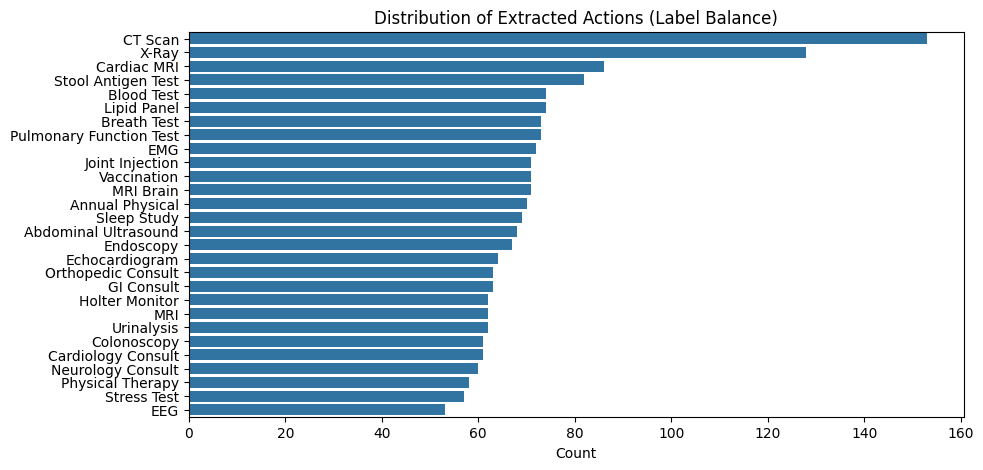

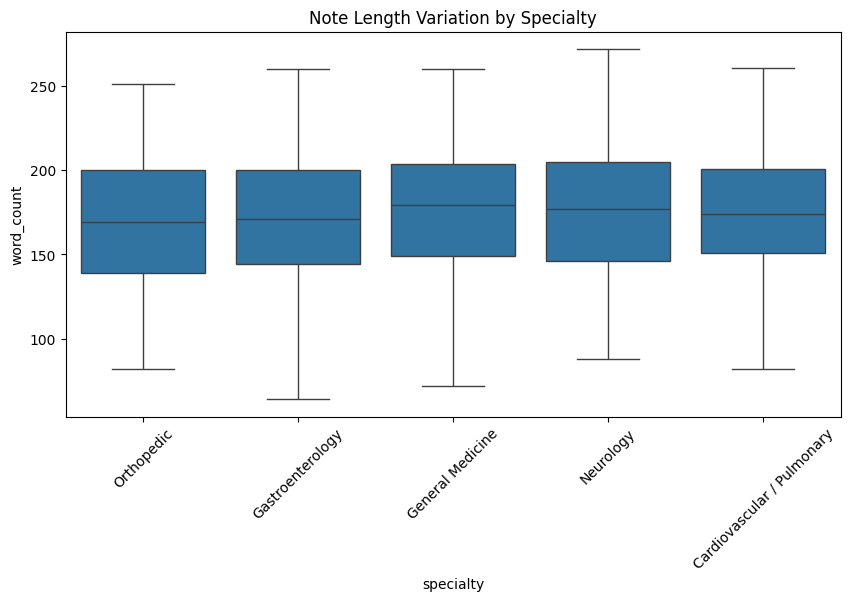

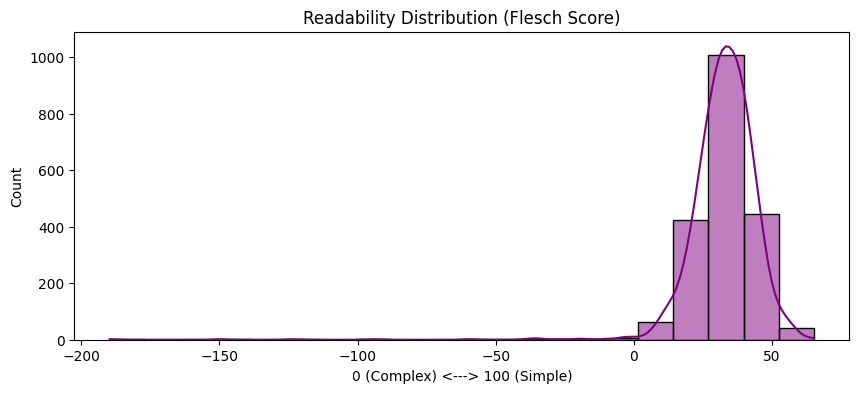


--- Validation: Does the Style Prompt affect Word Count? ---
style_category
Detailed       196.067616
Standard       173.623885
Telegraphic    143.858779
Name: word_count, dtype: float64


In [ ]:
!pip install textstat
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import textstat

# 1. Load Data
#df = pd.read_csv("synthetic_clinical_notes_10000.csv")
df = pd.read_csv("synthetic_clinical_notes_2000.csv")

# Parse the JSON column back into a list of dicts
df['ground_truth'] = df['actions_gt'].apply(json.loads)

# ==========================================
# PART A: Label Diversity (The Instructions)
# ==========================================

# Flatten the instructions to analyze them individually
all_instructions = []
#all_days = []
for items in df['ground_truth']:
    for i in items:
        all_instructions.append(i['action'])
        #all_days.append(i['period_days'])

# Plot 1: Action Distribution
plt.figure(figsize=(10, 5))
sns.countplot(y=all_instructions, order=pd.Series(all_instructions).value_counts().index)
plt.title("Distribution of Extracted Actions (Label Balance)")
plt.xlabel("Count")
plt.show()

# # Plot 2: Time Period Distribution (Regression Target)
# plt.figure(figsize=(10, 4))
# sns.histplot(all_days, bins=30, kde=True, color='teal')
# plt.title("Distribution of Time Periods in Days (Regression Target)")
# plt.xlabel("Days")
# plt.show()

# ==========================================
# PART B: Textual Diversity (The Style)
# ==========================================

# Calculate Metrics
df['char_count'] = df['note_text'].apply(len)
df['word_count'] = df['note_text'].apply(lambda x: len(str(x).split()))
df['sentence_count'] = df['note_text'].apply(textstat.sentence_count)
df['readability_score'] = df['note_text'].apply(textstat.flesch_reading_ease)

# Plot 3: Verbosity by Specialty
plt.figure(figsize=(10, 5))
sns.boxplot(x='specialty', y='word_count', data=df)
plt.title("Note Length Variation by Specialty")
plt.xticks(rotation=45)
plt.show()

# Plot 4: Readability Distribution (Complexity)
# High Score = Simple/Patient-Friendly; Low Score = Academic/Jargon
plt.figure(figsize=(10, 4))
sns.histplot(df['readability_score'], bins=20, color='purple', kde=True)
plt.title("Readability Distribution (Flesch Score)")
plt.xlabel("0 (Complex) <---> 100 (Simple)")
plt.show()

# ==========================================
# PART C: Style Meta Validation
# ==========================================
# Check if "Telegraphic" prompts actually resulted in shorter text
def get_detail_level(meta):
    # NOTE: style_meta field does not exist in the new data, use style_features
    if "Abbreviated/Telegraphic" in meta: return "Telegraphic"
    if "Highly Detailed" in meta: return "Detailed"
    return "Standard"

#df['style_category'] = df['style_meta'].apply(get_detail_level) # Original line
df['style_category'] = df['style_features'].apply(get_detail_level) # Updated to use style_features

print("\n--- Validation: Does the Style Prompt affect Word Count? ---")
print(df.groupby('style_category')['word_count'].mean())

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import numpy as np

# Load your new data
#df = pd.read_csv("synthetic_clinical_notes_10000.csv")
df = pd.read_csv("synthetic_clinical_notes_2000.csv")

# 1. Check Unique Vocab Size
vectorizer = CountVectorizer(stop_words='english', min_df=0.01)
#dtm = vectorizer.fit_transform(df['text'])
dtm = vectorizer.fit_transform(df['note_text'])
print(f"Unique words used (Vocabulary): {len(vectorizer.get_feature_names_out())}")
# (Goal: > 3,000 for 2k samples)

# 2. Check Repetition (Simulated Similarity)
# We sample 100 random pairs and check how similar they are
import random
#samples = df['text'].sample(200).tolist()

# Fix: Ensure we don't sample more than available rows
n_samples = min(200, len(df))
samples = df['note_text'].sample(n_samples).tolist()

similarities = []

for _ in range(1000):
    a, b = random.sample(samples, 2)
    # Simple Jaccard Similarity (Intersection over Union)
    set_a = set(a.lower().split())
    set_b = set(b.lower().split())
    intersection = len(set_a.intersection(set_b))
    union = len(set_a.union(set_b))
    similarities.append(intersection / union)

print(f"Average Similarity between notes: {np.mean(similarities):.4f}")
# (Goal: < 0.15. If it's 0.80, every note is identical.)

Unique words used (Vocabulary): 1297
Average Similarity between notes: 0.1437


In [ ]:
!nvidia-smi

Sat Jan 17 19:41:47 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          Off |   00000000:00:05.0 Off |                    0 |
| N/A   32C    P0             53W /  400W |       0MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
import pandas as pd
import json
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, AutoConfig # Import AutoConfig
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, mean_absolute_error
import numpy as np
from tqdm import tqdm

ImportError: cannot import name 'GenerationMixin' from 'transformers.generation' (/usr/local/lib/python3.12/dist-packages/transformers/generation/__init__.py)

In [ ]:
from transformers import AutoConfig

##comparison on test

# Joint BioBERT model: BIO-tag Actions + Times + Learned Linking Head (Biaffine)

Implements the project architecture:

- Shared encoder: BioBERT
- NER head (BIO): `B-ACT/I-ACT` and `B-TIME/I-TIME`
- Span representations: `[h_start; h_end; width_embedding]`
- Linking head: biaffine scorer over (action span, time span) pairs + distance features
- Decision rule: for each action, softmax over candidate times + NONE (cross-entropy).


In [ ]:
!pip -q install transformers accelerate seqeval

import json, re
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from dataclasses import dataclass
from typing import List, Dict, Any, Tuple

from transformers import AutoTokenizer, AutoModel, TrainingArguments, Trainer
!pip install dateparser
import dateparser
from datetime import datetime


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 26.4 MB/s eta 0:00:00


In [ ]:
# =========================
# Config
# =========================
MODEL_NAME = "dmis-lab/biobert-base-cased-v1.1"
#MAX_LEN = 256
MAX_LEN = 512
DOC_STRIDE = 128  # sliding-window stride (tokens)
BATCH_SIZE = 16
EPOCHS = 3
#EPOCHS=10
LR = 2e-5
ALPHA_LINK = 1.0  # weight for linking loss relative to NER loss

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

# Tag set for joint NER
TAG2ID = {"O":0, "B-ACT":1, "I-ACT":2, "B-TIME":3, "I-TIME":4}
ID2TAG = {v:k for k,v in TAG2ID.items()}
NUM_TAGS = len(TAG2ID)

biobert_tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)


Device: cuda


config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

In [ ]:
# =========================
# Load dataset (your 10k CSV)
# =========================
import pandas as pd
from sklearn.metrics import classification_report
import numpy as np
import ast
import json
#DATA_PATH = "synthetic_clinical_notes_10000.csv"  # change if needed
DATA_PATH="/content/synthetic_clinical_notes_2000.csv"
df = pd.read_csv(DATA_PATH, keep_default_na=False)

# def parse_actions_gt(s: str):
#     if not s:
#         return []
#     try:
#         return json.loads(s)
#     except Exception:
#         return []

# df["actions_gt_obj"] = df["actions_gt"].apply(parse_actions_gt)
def parse_actions_gt(s):
    # 1. Handle NaN / None / Empty
    if s is None or (isinstance(s, float) and np.isnan(s)) or s == "":
        return []

    # 2. Try Standard JSON first (fastest)
    try:
        return json.loads(s)
    except (json.JSONDecodeError, TypeError):
        pass

    # 3. Try Python literal_eval (handles single quotes: {'key': 'val'})
    try:
        return ast.literal_eval(s)
    except (ValueError, SyntaxError):
        pass

    # 4. Return empty if all fails (and maybe print a warning)
    # print(f"Warning: Could not parse row: {s}")
    return []

# Apply the robust function
df["actions_gt_obj"] = df["actions_gt"].apply(parse_actions_gt)

# Verification: Check if any non-empty strings resulted in empty lists
debug_mask = (df["actions_gt"].str.len() > 5) & (df["actions_gt_obj"].str.len() == 0)
if debug_mask.sum() > 0:
    print("Warning: Some non-empty rows failed to parse. Examples:")
    print(df.loc[debug_mask, "actions_gt"].head())

# Simple stable split (80/10/10)
rng = np.random.default_rng(42)
idx = np.arange(len(df))
rng.shuffle(idx)

n = len(df)
n_train = int(0.8 * n)
n_val = int(0.1 * n)

train_idx = idx[:n_train]
val_idx = idx[n_train:n_train+n_val]
test_idx = idx[n_train+n_val:]

df_train = df.iloc[train_idx].reset_index(drop=True)
df_val   = df.iloc[val_idx].reset_index(drop=True)
df_test  = df.iloc[test_idx].reset_index(drop=True)

print("Split sizes:", len(df_train), len(df_val), len(df_test))


Split sizes: 1600 200 200


In [ ]:
# =========================
# Dataset: joint NER labels + GOLD spans for linking (teacher forcing)
# + Sliding-window support for long notes
# + Proper link_labels: action -> index of its GT time span in the unique TIME candidate list
# =========================
import logging
import re
from datetime import datetime, timedelta
from typing import List, Dict, Any, Tuple, Optional
import torch
import dateparser
from dateutil.relativedelta import relativedelta

logger = logging.getLogger(__name__)

def char_span_to_token_span(offsets: List[Tuple[int,int]], char_s: int, char_e: int):
    """Map a character span [char_s, char_e) to an inclusive token span (tok_s, tok_e).
    Returns None if the span is fully outside the current window (e.g., truncated).
    """
    tok_ids = []
    for i,(s,e) in enumerate(offsets):
        if s == e == 0:
            continue
        if s < char_e and e > char_s:  # overlap
            tok_ids.append(i)
    if not tok_ids:
        return None
    return min(tok_ids), max(tok_ids)  # inclusive

def make_ner_labels(note_text: str, offsets, actions_gt: List[Dict[str,Any]]) -> List[int]:
    labels = [TAG2ID["O"]] * len(offsets)
    for a in actions_gt:
        as0, ae0 = a.get("action_char_start"), a.get("action_char_end")
        ts0, te0 = a.get("time_char_start"), a.get("time_char_end")

        if isinstance(as0, int) and isinstance(ae0, int) and 0 <= as0 < ae0 <= len(note_text):
            sp = char_span_to_token_span(offsets, as0, ae0)
            if sp:
                s,e = sp
                labels[s] = TAG2ID["B-ACT"]
                for k in range(s+1, e+1):
                    labels[k] = TAG2ID["I-ACT"]

        if isinstance(ts0, int) and isinstance(te0, int) and 0 <= ts0 < te0 <= len(note_text):
            sp = char_span_to_token_span(offsets, ts0, te0)
            if sp:
                s,e = sp
                labels[s] = TAG2ID["B-TIME"]
                for k in range(s+1, e+1):
                    labels[k] = TAG2ID["I-TIME"]
    return labels

def bucketize(x: int, buckets: List[int]) -> int:
    for i,b in enumerate(buckets):
        if x <= b:
            return i
    return len(buckets)

WIDTH_BUCKETS = [1,2,3,4,5,8,12,20,40]
DIST_BUCKETS = [0,1,2,3,4,5,8,12,20,40,80,160,320]

# NOTE: these caps assume your synthetic generator emits <=2 scheduled items per note.
# If you increase generator complexity, raise these.
MAX_ACTIONS = 2
MAX_TIMES = 2

# -------------------------
# Robust period-text normalization + date parsing
# -------------------------
NUMBER_MAP = {
    "zero": 0,
    "one": 1, "two": 2, "three": 3, "four": 4, "five": 5,
    "six": 6, "seven": 7, "eight": 8, "nine": 9, "ten": 10,
    "eleven": 11, "twelve": 12, "thirteen": 13, "fourteen": 14,
    "fifteen": 15, "sixteen": 16, "seventeen": 17, "eighteen": 18, "nineteen": 19,
    "twenty": 20, "thirty": 30, "forty": 40, "fifty": 50,
}

_NUM = r"(?:\d+|zero|one|two|three|four|five|six|seven|eight|nine|ten|eleven|twelve|thirteen|fourteen|fifteen|sixteen|seventeen|eighteen|nineteen|twenty|thirty|forty|fifty)"

def _words_to_digits(text: str) -> str:
    out = text
    for w,d in NUMBER_MAP.items():
        out = re.sub(rf"\b{w}\b", str(d), out)
    return out

def normalize_time_text(text: str) -> str:
    """Normalize a messy relative duration phrase into something dateparser + regex can handle.
    Examples:
      - "FOUR MOS" -> "in 4 months"
      - "8-week follow-up" -> "in 8 weeks"
      - "within ten weeks" -> "in 10 weeks"
      - "over the next 9 months" -> "in 9 months"
      - "in approximately eleven weeks" -> "in 11 weeks"
    """
    if not text:
        return text
    raw = text.strip()
    low = raw.lower().strip()

    # strip surrounding punctuation
    low = re.sub(r"^[\s:;,\-–—]+", "", low)
    low = re.sub(r"[\s:;,\.!\?]+$", "", low)

    # common wording cleanup
    low = low.replace("follow-up", "follow up").replace("followup", "follow up")
    low = re.sub(r"\bfollow\s+up\b", "follow up", low)

    # abbreviations -> canonical units
    low = re.sub(r"\bmos?\b", "month", low)
    low = re.sub(r"\bmo\b", "month", low)
    low = re.sub(r"\bmths?\b", "month", low)
    low = re.sub(r"\bwks?\b", "week", low)
    low = re.sub(r"\bhrs?\b", "hour", low)
    low = re.sub(r"\byrs?\b", "year", low)
    low = re.sub(r"\byr\b", "year", low)

    # "2-week" -> "2 week"
    low = low.replace("-", " ")

    # number words -> digits
    low = _words_to_digits(low)

    # remove a trailing "time" (e.g., "in 3 weeks time")
    low = re.sub(r"\s+time$", "", low)

    # patterns (most specific first)
    m = re.fullmatch(rf"({_NUM})\s+(day|week|month|year)s?\s+follow\s+up", low)
    if m:
        n, unit = m.group(1), m.group(2)
        return f"in {n} {unit}s"

    m = re.fullmatch(rf"({_NUM})\s+(day|week|month|year)s?", low)
    if m:
        n, unit = m.group(1), m.group(2)
        return f"in {n} {unit}s"

    m = re.fullmatch(rf"within\s+({_NUM})\s+(day|week|month|year)s?", low)
    if m:
        n, unit = m.group(1), m.group(2)
        return f"in {n} {unit}s"

    m = re.fullmatch(rf"over\s+the\s+next\s+({_NUM})\s+(day|week|month|year)s?", low)
    if m:
        n, unit = m.group(1), m.group(2)
        return f"in {n} {unit}s"

    m = re.fullmatch(rf"in\s+(about|approximately)\s+({_NUM})\s+(day|week|month|year)s?", low)
    if m:
        n, unit = m.group(2), m.group(3)
        return f"in {n} {unit}s"

    m = re.fullmatch(rf"(about|approximately)\s+({_NUM})\s+(day|week|month|year)s?", low)
    if m:
        n, unit = m.group(2), m.group(3)
        return f"in {n} {unit}s"

    # "eleven week follow up", "11 week follow up"
    m = re.fullmatch(rf"({_NUM})\s+(day|week|month|year)s?\s+follow\s+up", low)
    if m:
        n, unit = m.group(1), m.group(2)
        return f"in {n} {unit}s"

    # if it's a bare number + unit inside a longer phrase, just normalize those
    low = re.sub(rf"\b({_NUM})\s+(day|week|month|year)\b", r"\1 \2s", low)

    # add leading "in" if it looks like a bare duration prefix
    if re.match(rf"^({_NUM})\s+(days|weeks|months|years)\b", low) and not low.startswith("in "):
        low = "in " + low

    return low.strip()

def _duration_from_text(text: str) -> Optional[Tuple[int,str]]:
    """Extract (n, unit) from normalized text like 'in 4 months'."""
    if not text:
        return None
    low = text.lower().strip()
    low = _words_to_digits(low)
    m = re.search(rf"\b(?:in|within|over the next)\s+({_NUM})\s+(day|week|month|year)s?\b", low)
    if m:
        n = int(m.group(1))
        unit = m.group(2)
        return n, unit
    m = re.search(rf"\b({_NUM})\s+(day|week|month|year)s?\b", low)
    if m:
        n = int(m.group(1))
        unit = m.group(2)
        return n, unit
    return None

def parse_period_date(period_text: str, visit_date: str) -> Optional[str]:
    """Convert a relative period text into YYYY-MM-DD using visit_date as RELATIVE_BASE.
    Tries:
      1) dateparser on raw
      2) dateparser on normalized
      3) regex duration fallback using timedelta / relativedelta
    """
    if not period_text or not visit_date:
        return None

    try:
        base = datetime.strptime(visit_date, "%Y-%m-%d")
    except Exception:
        return None

    settings = {
        "PREFER_DATES_FROM": "future",
        "RELATIVE_BASE": base,
        "DATE_ORDER": "DMY",
    }

    # 1) raw
    dt = dateparser.parse(period_text, settings=settings)
    if dt:
        return dt.strftime("%Y-%m-%d")

    # 2) normalized
    norm = normalize_time_text(period_text)
    if norm and norm != period_text:
        dt = dateparser.parse(norm, settings=settings)
        if dt:
            return dt.strftime("%Y-%m-%d")

    # 3) explicit duration fallback (more deterministic than dateparser for some odd formats)
    dur = _duration_from_text(norm or period_text)
    if dur:
        n, unit = dur
        if unit == "day":
            out = base + timedelta(days=n)
        elif unit == "week":
            out = base + timedelta(weeks=n)
        elif unit == "month":
            out = base + relativedelta(months=n)
        elif unit == "year":
            out = base + relativedelta(years=n)
        else:
            return None
        return out.strftime("%Y-%m-%d")

    return None

# -------------------------
# Sliding-window dataset
# -------------------------
def _window_char_range(offsets: List[Tuple[int,int]]) -> Tuple[int,int]:
    valid = [(s,e) for (s,e) in offsets if not (s == e == 0)]
    if not valid:
        return (0,0)
    return (valid[0][0], valid[-1][1])

def _overlaps(a_s: int, a_e: int, b_s: int, b_e: int) -> bool:
    return (a_s < b_e) and (b_s < a_e)

class JointNerLinkDataset(torch.utils.data.Dataset):
    """Produces ONE sample per sliding window.
    We keep only windows that overlap at least one GT span (ACT or TIME) to reduce noise.
    For notes with no GT actions, we keep only the first window.
    """
    def __init__(self, df: pd.DataFrame):
        self.df = df.reset_index(drop=True)
        self.windows = []  # list of dicts with tokenized window + row_idx

        for row_idx in range(len(self.df)):
            row = self.df.iloc[row_idx]
            note = row["note_text"]
            actions = row["actions_gt_obj"]

            tok = biobert_tokenizer(
                note,
                truncation=True,
                max_length=MAX_LEN,
                stride=DOC_STRIDE,
                return_overflowing_tokens=True,
                padding="max_length",
                return_offsets_mapping=True,
            )
            nwin = len(tok["input_ids"])

            if not actions:
                # keep only first window for negative notes to avoid huge negatives
                keep_wins = [0]
            else:
                # collect all GT spans
                gt_spans = []
                for a in actions:
                    for key_s, key_e in [("action_char_start","action_char_end"), ("time_char_start","time_char_end")]:
                        s0, e0 = a.get(key_s), a.get(key_e)
                        if isinstance(s0,int) and isinstance(e0,int) and 0 <= s0 < e0 <= len(note):
                            gt_spans.append((s0,e0))

                keep_wins = []
                for w in range(nwin):
                    offsets = tok["offset_mapping"][w]
                    ws, we = _window_char_range(offsets)
                    if any(_overlaps(ws,we, s0,e0) for (s0,e0) in gt_spans):
                        keep_wins.append(w)

                # safety: if nothing matched (rare), keep the last window
                if not keep_wins:
                    keep_wins = [nwin-1]

            for w in keep_wins:
                self.windows.append({
                    "row_idx": row_idx,
                    "input_ids": tok["input_ids"][w],
                    "attention_mask": tok["attention_mask"][w],
                    "offsets": tok["offset_mapping"][w],
                })

    def __len__(self):
        return len(self.windows)

    def __getitem__(self, idx: int):
        win = self.windows[idx]
        row = self.df.iloc[win["row_idx"]]
        note = row["note_text"]
        actions = row["actions_gt_obj"]
        offsets = win["offsets"]

        # NER labels (BIO)
        ner = make_ner_labels(note, offsets, actions)
        ner_labels = []
        for (s,e),lab in zip(offsets, ner):
            if s == e == 0:
                ner_labels.append(-100)
            else:
                ner_labels.append(lab)

        # ---- Linking supervision (gold spans) ----
        # Build candidate (action_tok, time_tok) pairs that are visible in THIS window.
        pairs = []
        for a in actions:
            as0, ae0 = a.get("action_char_start"), a.get("action_char_end")
            ts0, te0 = a.get("time_char_start"), a.get("time_char_end")
            if not (isinstance(as0,int) and isinstance(ae0,int) and isinstance(ts0,int) and isinstance(te0,int)):
                continue
            act_tok = char_span_to_token_span(offsets, as0, ae0)
            tim_tok = char_span_to_token_span(offsets, ts0, te0)
            # IMPORTANT: only supervise link when BOTH are in-window
            if act_tok is not None and tim_tok is not None:
                pairs.append((act_tok, tim_tok))

        # Unique TIME candidates (dedup) sorted by token start
        time_unique = sorted({t for (_,t) in pairs}, key=lambda x: x[0])[:MAX_TIMES]
        time_index = {t:i for i,t in enumerate(time_unique)}

        # Actions sorted by token start; keep only those whose TIME is still in time_unique
        pairs = [(a,t) for (a,t) in pairs if t in time_index]
        pairs = sorted(pairs, key=lambda p: p[0][0])[:MAX_ACTIONS]

        action_spans = [a for (a,_) in pairs]
        link_labels = [time_index[t] for (_,t) in pairs]

        # masks + padding
        a_mask = [1.0]*len(action_spans)
        t_mask = [1.0]*len(time_unique)

        while len(action_spans) < MAX_ACTIONS:
            action_spans.append((0,0))
            a_mask.append(0.0)
            link_labels.append(MAX_TIMES)  # NONE

        while len(time_unique) < MAX_TIMES:
            time_unique.append((0,0))
            t_mask.append(0.0)

        return {
            "input_ids": torch.tensor(win["input_ids"], dtype=torch.long),
            "attention_mask": torch.tensor(win["attention_mask"], dtype=torch.long),
            "ner_labels": torch.tensor(ner_labels, dtype=torch.long),
            "action_spans": torch.tensor(action_spans, dtype=torch.long),
            "time_spans": torch.tensor(time_unique, dtype=torch.long),
            "action_mask": torch.tensor(a_mask, dtype=torch.float),
            "time_mask": torch.tensor(t_mask, dtype=torch.float),
            "link_labels": torch.tensor(link_labels, dtype=torch.long),
        }

train_ds = JointNerLinkDataset(df_train)
val_ds = JointNerLinkDataset(df_val)
test_ds = JointNerLinkDataset(df_test)

print("Dataset ready. #windows:", len(train_ds), len(val_ds), len(test_ds))
print("Example keys:", list(train_ds[0].keys()))


Dataset ready. #windows: 1600 200 200
Example keys: ['input_ids', 'attention_mask', 'ner_labels', 'action_spans', 'time_spans', 'action_mask', 'time_mask', 'link_labels']


In [ ]:
# =========================
# Model: shared BioBERT + joint NER + biaffine linking
# =========================
class Biaffine(nn.Module):
    def __init__(self, d: int):
        super().__init__()
        self.U = nn.Parameter(torch.empty(d, d))
        nn.init.xavier_uniform_(self.U)

    def forward(self, a: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        # a: [B,A,d], t: [B,T,d] -> [B,A,T]
        return torch.einsum("bad,df,btd->bat", a, self.U, t)

class BioBertNerLinker(nn.Module):
    def __init__(self, base_name: str, num_tags: int, proj_dim: int = 256, width_dim: int = 32, dist_dim: int = 32):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(base_name)
        h = self.encoder.config.hidden_size

        self.ner_head = nn.Linear(h, num_tags)

        self.width_emb = nn.Embedding(len(WIDTH_BUCKETS)+1, width_dim)
        self.dist_emb = nn.Embedding(len(DIST_BUCKETS)+1, dist_dim)

        self.span_dim = 2*h + width_dim

        self.act_proj = nn.Sequential(nn.Linear(self.span_dim, proj_dim), nn.ReLU(), nn.Dropout(0.1))
        self.tim_proj = nn.Sequential(nn.Linear(self.span_dim, proj_dim), nn.ReLU(), nn.Dropout(0.1))

        self.biaffine = Biaffine(proj_dim)
        self.lin = nn.Linear(2*proj_dim + dist_dim, 1)

        self.none_time = nn.Parameter(torch.zeros(self.span_dim))
        nn.init.normal_(self.none_time, std=0.02)

    def span_repr(self, H: torch.Tensor, spans: torch.Tensor) -> torch.Tensor:
        # H: [B,L,h], spans: [B,N,2] inclusive indices -> [B,N,span_dim]
        B,L,h = H.shape
        s = spans[:,:,0].clamp(0, L-1)
        e = spans[:,:,1].clamp(0, L-1)
        hs = H.gather(1, s.unsqueeze(-1).expand(-1,-1,h))
        he = H.gather(1, e.unsqueeze(-1).expand(-1,-1,h))
        width = (e - s + 1).clamp(min=1).to(torch.long)
        w_bucket = torch.zeros_like(width)
        for bi in range(B):
            for ni in range(width.size(1)):
                w_bucket[bi,ni] = bucketize(int(width[bi,ni].item()), WIDTH_BUCKETS)
        w = self.width_emb(w_bucket)
        return torch.cat([hs, he, w], dim=-1)

    def forward(self, input_ids, attention_mask, ner_labels=None,
                action_spans=None, time_spans=None, action_mask=None, time_mask=None, link_labels=None, output_attentions=None):
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask, output_attentions=output_attentions)
        H = out.last_hidden_state

        ner_logits = self.ner_head(H)

        # We punish the model 10x more for missing an Action than for getting 'O' wrong.
        class_weights = torch.tensor([0.1, 1.0, 1.0, 1.0, 1.0]).to(ner_logits.device)

        ner_loss = None
        if ner_labels is not None:
            ner_loss = F.cross_entropy(
                ner_logits.view(-1, ner_logits.size(-1)),
                ner_labels.view(-1),
                ignore_index=-100,
                weight=class_weights
            )

        link_logits = None
        link_loss = None
        if action_spans is not None and time_spans is not None and action_mask is not None and time_mask is not None:
            act_rep = self.span_repr(H, action_spans)   # [B,A,span_dim]
            tim_rep = self.span_repr(H, time_spans)     # [B,T,span_dim]

            none = self.none_time.view(1,1,-1).expand(tim_rep.size(0), 1, -1)
            tim_rep_all = torch.cat([tim_rep, none], dim=1)  # [B,T+1,span_dim]

            aP = self.act_proj(act_rep)         # [B,A,d]
            tP = self.tim_proj(tim_rep_all)     # [B,T+1,d]

            bia = self.biaffine(aP, tP)         # [B,A,T+1]

            # distance features (abs token distance between starts)
            a_s = action_spans[:,:,0]
            t_s = time_spans[:,:,0]
            dist_abs = (t_s.unsqueeze(1) - a_s.unsqueeze(2)).abs().to(torch.long)  # [B,A,T]
            dist_bucket = torch.zeros_like(dist_abs)
            B,A,T = dist_abs.shape
            for bi in range(B):
                for ai in range(A):
                    for ti in range(T):
                        dist_bucket[bi,ai,ti] = bucketize(int(dist_abs[bi,ai,ti].item()), DIST_BUCKETS)
            dist_emb = self.dist_emb(dist_bucket)  # [B,A,T,dist_dim]

            # NONE distance bucket = 0
            none_bucket = torch.zeros((B,A,1), dtype=torch.long, device=H.device)
            none_emb = self.dist_emb(none_bucket)
            dist_emb_all = torch.cat([dist_emb, none_emb], dim=2)  # [B,A,T+1,dist_dim]

            a_exp = aP.unsqueeze(2).expand(-1,-1,tP.size(1),-1)
            t_exp = tP.unsqueeze(1).expand(-1,aP.size(1),-1,-1)
            lin_in = torch.cat([a_exp, t_exp, dist_emb_all], dim=-1)
            lin = self.lin(lin_in).squeeze(-1)  # [B,A,T+1]

            link_logits = bia + lin

            # mask padded times (keep NONE)
            tmask = torch.cat([time_mask, torch.ones(time_mask.size(0),1, device=time_mask.device)], dim=1)
            link_logits = link_logits.masked_fill(tmask.unsqueeze(1) == 0, -1e4)

            if link_labels is not None:
                B,A,TT = link_logits.shape
                logits_flat = link_logits.reshape(B*A, TT)
                labels_flat = link_labels.reshape(B*A)
                amask_flat = (action_mask.reshape(B*A) > 0.5)
                if amask_flat.any():
                    link_loss = F.cross_entropy(logits_flat[amask_flat], labels_flat[amask_flat])
                else:
                    link_loss = torch.tensor(0.0, device=H.device)

        loss = None
        if ner_loss is not None and link_loss is not None:
            loss = ner_loss + ALPHA_LINK * link_loss
        elif ner_loss is not None:
            loss = ner_loss
        else:
            loss = link_loss

        return {"loss": loss, "ner_logits": ner_logits, "link_logits": link_logits, "ner_loss": ner_loss, "link_loss": link_loss, "attentions":out.attentions}

biobert_model = BioBertNerLinker(MODEL_NAME, NUM_TAGS).to(DEVICE)
print("Model ready.")

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

Model ready.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from dataclasses import dataclass
from typing import List, Dict, Any, Tuple
from transformers import AutoTokenizer, AutoModel, Trainer
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback

# =========================
# Trainer
# =========================
@dataclass
class Collator:
    def __call__(self, features: List[Dict[str, torch.Tensor]]) -> Dict[str, torch.Tensor]:
        out = {}
        for k in features[0].keys():
            out[k] = torch.stack([f[k] for f in features], dim=0)
        return out

collator = Collator()

args = TrainingArguments(
    output_dir="biobert_joint_ner_link",
    learning_rate=LR,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=20,                 # <--- Set this high (e.g., 20) to give it room
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=50,
    fp16=torch.cuda.is_available(),
    report_to="none",

    # --- CRITICAL ADDITIONS FOR EARLY STOPPING ---
    load_best_model_at_end=True,         # Required for Early Stopping
    metric_for_best_model="loss",        # Monitor Validation Loss (most stable)
    greater_is_better=False,             # Lower loss is better
    save_total_limit=2,                  # Saves space (keeps only best + last)
)

biobert_trainer = Trainer(
    model=biobert_model,
    args=args,
    data_collator=collator,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=biobert_tokenizer,
    # --- ADD CALLBACK HERE ---
    callbacks=[EarlyStoppingCallback(early_stopping_patience=4)]
)

biobert_trainer.train()

/tmp/ipython-input-1197849804.py:62: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer._unsloth___init__`. Use `processing_class` instead.
  biobert_trainer = Trainer(
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,600 | Num Epochs = 20 | Total steps = 2,000
O^O/ \_/ \    Batch size per device = 16 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (16 x 1 x 1) = 16
 "-____-"     Trainable parameters = 109,185,862 of 109,185,862 (100.00% trained)


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss
1,0.618300,0.316474
2,0.045200,0.019861
3,0.008600,0.019811
4,0.004400,0.020508
5,0.002900,0.033973
6,0.005200,0.008606
7,0.002600,0.007624
8,0.003200,0.027927
9,0.001500,0.020343
10,0.001800,0.016544


TrainOutput(global_step=1100, training_loss=0.10385098185051571, metrics={'train_runtime': 122.3604, 'train_samples_per_second': 261.522, 'train_steps_per_second': 16.345, 'total_flos': 0.0, 'train_loss': 0.10385098185051571, 'epoch': 11.0})

In [ ]:
import torch
import os

# 1. Define path
save_path_model = "/content/drive/MyDrive/BioBERT-Finetuned-Model.bin" # Ends in .bin or .pth
save_path_tokenizer_dir = "/content/drive/MyDrive/BioBERT-Finetuned-Tokenizer"

print(f"💾 Saving model weights to {save_path_model}...")

# 2. Save the weights (Universal PyTorch method)
torch.save(model.state_dict(), save_path_model)

# 3. Save the tokenizer
try:
    os.makedirs(save_path_tokenizer_dir, exist_ok=True)
    tokenizer.save_pretrained(save_path_tokenizer_dir)
    print(f"✅ Tokenizer saved separately to {save_path_tokenizer_dir}.")
except Exception as e:
    print(f"⚠️ Could not save tokenizer: {e}")

print("✅ Model weights saved successfully!")

💾 Saving model weights to /content/drive/MyDrive/BioBERT-Finetuned-Model.bin...
✅ Tokenizer saved separately to /content/drive/MyDrive/BioBERT-Finetuned-Tokenizer.
✅ Model weights saved successfully!


In [ ]:
# =========================
# Inference (predicted spans -> linking -> JSON)
# =========================
def extract_visit_date(note_text: str):
    m = re.search(r"Date of Visit:\s*(\d{4}-\d{2}-\d{2})", note_text)
    return m.group(1) if m else None

def decode_spans_from_tags(offsets, tag_ids: List[int], prefix: str, note_text: str):
    spans = []
    cur = None
    for i,(off,tid) in enumerate(zip(offsets, tag_ids)):
        s,e = off
        if s == e == 0:
            continue
        tag = ID2TAG.get(int(tid), "O")
        if tag == f"B-{prefix}":
            if cur is not None:
                spans.append(cur)
            cur = [i,i]
        elif tag == f"I-{prefix}":
            if cur is not None:
                cur[1] = i
        else:
            if cur is not None:
                spans.append(cur); cur=None
    if cur is not None:
        spans.append(cur)

    out=[]
    for ts,te in spans:
        cs = offsets[ts][0]
        ce = offsets[te][1]
        txt = note_text[cs:ce].strip()
        if txt:
            out.append((cs,ce,txt,ts,te))
    return out

@torch.no_grad()
def predict_json(note_text: str):
    visit_date = extract_visit_date(note_text) or "1970-01-01"
    enc = biobert_tokenizer(note_text, return_offsets_mapping=True, truncation=True, max_length=MAX_LEN, padding="max_length", return_tensors="pt")
    offsets = enc["offset_mapping"][0].tolist()
    enc = {k:v.to(DEVICE) for k,v in enc.items() if k in ["input_ids","attention_mask"]}

    out = biobert_model(input_ids=enc["input_ids"], attention_mask=enc["attention_mask"])
    tag_ids = out["ner_logits"][0].argmax(-1).detach().cpu().tolist()

    act_spans = sorted(decode_spans_from_tags(offsets, tag_ids, "ACT", note_text), key=lambda x:x[0])[:MAX_ACTIONS]
    tim_spans = sorted(decode_spans_from_tags(offsets, tag_ids, "TIME", note_text), key=lambda x:x[0])[:MAX_TIMES]

    action_sp = [(a[3],a[4]) for a in act_spans]
    time_sp = [(t[3],t[4]) for t in tim_spans]
    a_mask = [1]*len(action_sp) + [0]*(MAX_ACTIONS-len(action_sp))
    t_mask = [1]*len(time_sp) + [0]*(MAX_TIMES-len(time_sp))
    action_sp += [(0,0)]*(MAX_ACTIONS-len(action_sp))
    time_sp += [(0,0)]*(MAX_TIMES-len(time_sp))

    link_batch = {
        "input_ids": enc["input_ids"],
        "attention_mask": enc["attention_mask"],
        "action_spans": torch.tensor([action_sp], device=DEVICE),
        "time_spans": torch.tensor([time_sp], device=DEVICE),
        "action_mask": torch.tensor([a_mask], device=DEVICE),
        "time_mask": torch.tensor([t_mask], device=DEVICE),
        "link_labels": torch.tensor([[MAX_TIMES]*MAX_ACTIONS], device=DEVICE),
    }
    out2 = biobert_model(**link_batch)
    link = out2["link_logits"][0].argmax(-1).detach().cpu().tolist()  # [A] indices in [0..T] with T = NONE

    results=[]
    for i,a in enumerate(act_spans):
        j = link[i]
        if j >= len(tim_spans):
            continue
        period_text = tim_spans[j][2]
        results.append({
            "action": a[2],
            "period_text": period_text,
            "period_date": parse_period_date(period_text, visit_date),
        })
    return results

demo = df_val.iloc[0]["note_text"]
print(demo[:350], "...")
print(json.dumps(predict_json(demo), indent=2))


Date of Visit: 2025-06-24

Patient presents with complaints of abdominal pain and discomfort, which have persisted for the past two weeks. The patient reports that the pain is primarily in the upper abdomen and is associated with bloating and occasional nausea. There is no history of vomiting or weight loss. The patient has been taking over-the-cou ...
[
  {
    "action": "Abdominal Ultrasound",
    "period_text": "in twelve days",
    "period_date": "2025-07-06"
  }
]


In [ ]:
import json
import os
from google.colab import drive

# Mount Google Drive if not already mounted
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#save finetuned biobert model
model_save_path = '/content/drive/MyDrive/biobert_finetuned_2k.pth'
torch.save(model.state_dict(), model_save_path)

# Joint Evaluation (Span-level F1, Linking, End-to-End Dates)

This section adds **harder**, project-aligned evaluation:
- Exact-span micro F1 for **ACTION** and **TIME** spans (char-level exact match)
- Linking accuracy with **gold spans** (teacher forcing)
- Linking + dates evaluation with **predicted spans** (end-to-end; harder)


In [ ]:
import math
from collections import defaultdict
from datetime import datetime

def _canon_ws(s: str) -> str:
    return re.sub(r"\s+", " ", (s or "").strip())

def _prf(tp: int, fp: int, fn: int):
    p = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    r = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1 = 2*p*r/(p+r) if (p+r) > 0 else 0.0
    return p, r, f1

def _safe_json_load(s: str):
    if not s or s == "[]":
        return []
    try:
        return json.loads(s)
    except Exception:
        return []

def gold_spans_and_links(note_text: str, actions_gt_list):
    """Return unique gold action spans, unique gold time spans, and action->time index mapping.
    Uses EXACT char spans from GT. Supports shared time spans across actions.
    """
    act_spans = []  # (s,e,text)
    time_spans = [] # (s,e,text)
    time_index = {} # (s,e) -> idx
    links = []      # for each action i -> time idx (or None)

    for a in actions_gt_list:
        as0, ae0 = a.get('action_char_start'), a.get('action_char_end')
        ts0, te0 = a.get('time_char_start'), a.get('time_char_end')
        if not (isinstance(as0,int) and isinstance(ae0,int) and 0 <= as0 < ae0 <= len(note_text)):
            continue
        act_txt = _canon_ws(note_text[as0:ae0])
        act_spans.append((as0, ae0, act_txt))

    # build unique time spans (order by start)
    for a in actions_gt_list:
        ts0, te0 = a.get('time_char_start'), a.get('time_char_end')
        if isinstance(ts0,int) and isinstance(te0,int) and 0 <= ts0 < te0 <= len(note_text):
            key = (ts0, te0)
            if key not in time_index:
                time_index[key] = len(time_spans)
                time_txt = _canon_ws(note_text[ts0:te0])
                time_spans.append((ts0, te0, time_txt))

    # map each action to its time index (by its own GT time span)
    gt_by_actspan = {(a.get('action_char_start'), a.get('action_char_end')): a for a in actions_gt_list}
    for (as0,ae0,_) in act_spans:
        a = gt_by_actspan.get((as0,ae0), {})
        ts0, te0 = a.get('time_char_start'), a.get('time_char_end')
        if isinstance(ts0,int) and isinstance(te0,int) and (ts0,te0) in time_index:
            links.append(time_index[(ts0,te0)])
        else:
            links.append(None)

    return act_spans, time_spans, links

def spans_set(spans, label: str):
    return {(s[0],s[1],label) for s in spans}

def eval_span_f1(pred_spans, gold_spans, label: str):
    P = spans_set(pred_spans, label)
    G = spans_set(gold_spans, label)
    tp = len(P & G)
    fp = len(P - G)
    fn = len(G - P)
    return tp, fp, fn

@torch.no_grad()
def predict_ner_spans(model, tokenizer, note_text: str):
    enc = tokenizer(note_text, truncation=True, padding='max_length', max_length=MAX_LEN, return_offsets_mapping=True, return_tensors='pt')
    enc = {k:v.to(DEVICE) for k,v in enc.items() if k != 'offset_mapping'}
    offsets = tokenizer(note_text, truncation=True, padding='max_length', max_length=MAX_LEN, return_offsets_mapping=True)['offset_mapping']

    out = model(input_ids=enc['input_ids'], attention_mask=enc['attention_mask'])
    tag_ids = out['ner_logits'].argmax(-1).squeeze(0).detach().cpu().tolist()
    act = decode_spans_from_tags(offsets, tag_ids, 'ACT', note_text)
    tim = decode_spans_from_tags(offsets, tag_ids, 'TIME', note_text)
    return act, tim, offsets, tag_ids

def _pad_spans_tok(spans_tok, max_n):
    spans_tok = spans_tok[:max_n]
    mask = [1.0]*len(spans_tok)
    while len(spans_tok) < max_n:
        spans_tok.append((0,0))
        mask.append(0.0)
    return torch.tensor(spans_tok, dtype=torch.long), torch.tensor(mask, dtype=torch.float)

@torch.no_grad()
def predict_links_for_predicted_spans(model, tokenizer, note_text: str, act_spans_char, tim_spans_char):
    # convert char spans -> token spans (drop ones that don't map due to truncation)
    enc = tokenizer(note_text, truncation=True, padding='max_length', max_length=MAX_LEN, return_offsets_mapping=True, return_tensors='pt')
    offsets = tokenizer(note_text, truncation=True, padding='max_length', max_length=MAX_LEN, return_offsets_mapping=True)['offset_mapping']

    act_tok = []
    act_keep = []
    # FIX: Handle 5-element tuples (cs,ce,txt,ts,te) from decode_spans_from_tags
    for item in act_spans_char:
        cs, ce, txt = item[0], item[1], item[2]
        ts = char_span_to_token_span(offsets, cs, ce)
        if ts is not None:
            act_tok.append(ts)
            act_keep.append((cs,ce,txt))

    tim_tok = []
    tim_keep = []
    # FIX: Handle 5-element tuples
    for item in tim_spans_char:
        cs, ce, txt = item[0], item[1], item[2]
        ts = char_span_to_token_span(offsets, cs, ce)
        if ts is not None:
            tim_tok.append(ts)
            tim_keep.append((cs,ce,txt))

    if len(act_tok) == 0:
        return act_keep, tim_keep, []

    act_t, act_m = _pad_spans_tok(act_tok, MAX_ACTIONS)
    tim_t, tim_m = _pad_spans_tok(tim_tok, MAX_TIMES)

    batch = {
        'input_ids': enc['input_ids'].to(DEVICE),
        'attention_mask': enc['attention_mask'].to(DEVICE),
        'action_spans': act_t.unsqueeze(0).to(DEVICE),
        'time_spans': tim_t.unsqueeze(0).to(DEVICE),
        'action_mask': act_m.unsqueeze(0).to(DEVICE),
        'time_mask': tim_m.unsqueeze(0).to(DEVICE),
    }
    out = model(**batch)
    logits = out['link_logits'].squeeze(0).detach().cpu()  # [A, T+1]
    # choose best time per (real) action span
    pred = []
    A_real = int(act_m.sum().item())
    T_real = int(tim_m.sum().item())
    for i in range(A_real):
        # mask padded times but keep NONE
        scores = logits[i,:T_real+1]
        j = int(scores.argmax().item())
        pred.append(j)  # 0..T_real-1 or T_real == NONE
    return act_keep[:A_real], tim_keep[:T_real], pred

@torch.no_grad()
def eval_link_accuracy_gold_spans(model, dl):
    model.eval()
    correct = 0
    total = 0
    for batch in dl:
        batch = {k:v.to(DEVICE) for k,v in batch.items()}
        out = model(**batch)
        logits = out['link_logits']  # [B,A,T+1]
        pred = logits.argmax(-1)     # [B,A]
        gold = batch['link_labels']  # [B,A]
        mask = batch['action_mask'] > 0
        correct += (pred[mask] == gold[mask]).sum().item()
        total += mask.sum().item()
    acc = correct / total if total > 0 else 0.0
    return acc, total

def _date_to_dt(s: str):
    try:
        return datetime.strptime(s, '%Y-%m-%d')
    except Exception:
        return None

def canon_action_key(s: str) -> str:
    # case-insensitive + whitespace stable
    return _canon_ws(s).casefold()

def clean_time_text(s: str) -> str:
    s = _canon_ws(s)
    # strip bullets/colons/quotes at edges only
    s = re.sub(r'^[\s\-\u2022\*\(\[\{":]+', "", s)
    s = re.sub(r'[\s\)\]\}":;,.]+$', "", s)
    return s.strip()

@torch.no_grad()
def evaluate_end_to_end_predicted(model, tokenizer, df: pd.DataFrame, limit: int = None, show_examples: int = 3):
    """Hard evaluation: decode predicted spans, run learned linker, then compute:
    - span F1 (ACT/TIME)
    - linked-pair exact-span F1
    - (action, period_date) set F1 + date MAE on matched actions
    """
    model.eval()

    tp_act=fp_act=fn_act=0
    tp_tim=fp_tim=fn_tim=0
    tp_pair=fp_pair=fn_pair=0

    # linking accuracy metrics (hard):
    link_acc_exact_actspan_correct = 0
    link_acc_exact_actspan_total = 0
    link_acc_e2e_correct = 0
    link_acc_e2e_total = 0

    # date metrics
    matched_actions = 0
    date_exact = 0
    abs_err_days = []
    tp_act_date=fp_act_date=fn_act_date=0

    shown = 0

    it = df.itertuples(index=False)
    n = 0
    for row in it:
        if limit is not None and n >= limit:
            break
        n += 1
        note = getattr(row, 'note_text')
        gt_list = _safe_json_load(getattr(row, 'actions_gt'))
        visit_date = extract_visit_date(note)

        if gt_list and any(a.get("action_char_start") is None or a.get("time_char_start") is None for a in gt_list):
          # dataset issue: action/date exist but spans missing
          # optionally skip span/link metrics for this row
          pass


        gold_act, gold_tim, gold_links = gold_spans_and_links(note, gt_list)
        pred_act, pred_tim, _, _ = predict_ner_spans(model, tokenizer, note)

        # span f1
        a_tp,a_fp,a_fn = eval_span_f1(pred_act, gold_act, 'ACT')
        t_tp,t_fp,t_fn = eval_span_f1(pred_tim, gold_tim, 'TIME')
        tp_act+=a_tp; fp_act+=a_fp; fn_act+=a_fn
        tp_tim+=t_tp; fp_tim+=t_fp; fn_tim+=t_fn

        # linking on predicted spans
        pred_act_keep, pred_tim_keep, pred_links = predict_links_for_predicted_spans(model, tokenizer, note, pred_act, pred_tim)

        pred_pairs=set()
        pred_map = {}
        for i,(as0,ae0,atxt) in enumerate(pred_act_keep):
            j = pred_links[i] if i < len(pred_links) else None
            # store predicted mapping for accuracy metrics
            if j is None or j >= len(pred_tim_keep):
                pred_map[(as0,ae0)] = None
            else:
                pred_map[(as0,ae0)] = (pred_tim_keep[j][0], pred_tim_keep[j][1])
            if j is None:
                continue
            # NONE is last index == T_real
            if j >= len(pred_tim_keep):
                continue
            ts0,te0,ttxt = pred_tim_keep[j]
            pred_pairs.add((as0,ae0,ts0,te0))

        # How often can we parse a date once we have a linked time span?
        parse_attempts = len(pred_pairs)
        parse_success  = 0
        for (as0,ae0,ts0,te0) in pred_pairs:
            pt = clean_time_text(note[ts0:te0])
            if visit_date and parse_period_date(pt, visit_date):
                parse_success += 1
        date_parse_rate = parse_success / max(1, parse_attempts)


        gold_pairs=set()
        gold_map = {}
        for i,(as0,ae0,_) in enumerate(gold_act):
            j = gold_links[i] if i < len(gold_links) else None
            if j is None or j >= len(gold_tim):
                continue
            ts0,te0,_ = gold_tim[j]
            gold_pairs.add((as0,ae0,ts0,te0))
            gold_map[(as0,ae0)] = (ts0,te0)

        # link accuracy metrics (using predicted spans)
        #  - exact-actionspan: only evaluate linking when the ACTION span was found exactly
        #  - end-to-end: missing ACTION span counts as wrong
        link_acc_e2e_total += len(gold_map)
        for act_span, gold_time in gold_map.items():
            pred_time = pred_map.get(act_span, None)
            if act_span in pred_map:
                link_acc_exact_actspan_total += 1
                if pred_time == gold_time:
                    link_acc_exact_actspan_correct += 1
            if pred_time == gold_time:
                link_acc_e2e_correct += 1

        tp_pair += len(pred_pairs & gold_pairs)
        fp_pair += len(pred_pairs - gold_pairs)
        fn_pair += len(gold_pairs - pred_pairs)

        # end-to-end (action, date) set metrics
        gold_items=[]
        # for a in gt_list:
        #     #act = _canon_ws(a.get('action',''))
        #     act = canon_action_key(a.get('action',''))
        #     pd = a.get('period_date')
        #     if act and pd:
        #         gold_items.append((act, pd))
        # NEW CODE (Fix):
        gold_items = []
        for a in gt_list:
            act = canon_action_key(a.get('action', ''))
            pd = a.get('period_date')

            # CHECK: Does this item have valid span coordinates?
            s_char = a.get('action_char_start')

            # Only add to "Gold Standard" if it has a valid start index.
            # If s_char is None, the model never had a chance to find it.
            if act and pd and isinstance(s_char, int):
                gold_items.append((act, pd))


        pred_items=[]
        # build predicted items using predicted pairs
        for (as0,ae0,ts0,te0) in pred_pairs:
            #act = _canon_ws(note[as0:ae0])
            #pt = _canon_ws(note[ts0:te0])
            act = canon_action_key(note[as0:ae0])
            pt  = clean_time_text(note[ts0:te0])
            if not act:
                continue
            pd = parse_period_date(pt, visit_date) if visit_date else None
            if pd:
                pred_items.append((act, pd))

        G=set(gold_items); P=set(pred_items)
        tp_act_date += len(P & G)
        fp_act_date += len(P - G)
        fn_act_date += len(G - P)

        # date MAE for matched actions (by action string)
        #gold_by_act = {a: d for a,d in gold_items}
        #pred_by_act = {a: d for a,d in pred_items}
        gold_by_act = {}
        for a,d in gold_items:
            gold_by_act[a] = d

        pred_by_act = {}
        for a,d in pred_items:
            pred_by_act[a] = d

        for act, gd in gold_by_act.items():
            if act in pred_by_act:
                matched_actions += 1
                pd = pred_by_act[act]
                if pd == gd:
                    date_exact += 1
                gdt = _date_to_dt(gd)
                pdt = _date_to_dt(pd)
                if gdt and pdt:
                    abs_err_days.append(abs((pdt-gdt).days))

        if shown < show_examples and (len(pred_pairs - gold_pairs) > 0 or len(gold_pairs - pred_pairs) > 0):
            shown += 1
            print("\n--- Example error ---")
            print(note[:450].replace('\n',' '), "...")
            print("Gold pairs:", list(gold_pairs)[:5])
            print("Pred pairs:", list(pred_pairs)[:5])
            print("Gold (act,date):", gold_items)
            print("Pred (act,date):", pred_items)

    act_p, act_r, act_f1 = _prf(tp_act, fp_act, fn_act)
    tim_p, tim_r, tim_f1 = _prf(tp_tim, fp_tim, fn_tim)
    pair_p, pair_r, pair_f1 = _prf(tp_pair, fp_pair, fn_pair)
    ad_p, ad_r, ad_f1 = _prf(tp_act_date, fp_act_date, fn_act_date)

    date_acc = (date_exact / matched_actions) if matched_actions else 0.0
    mae = (sum(abs_err_days)/len(abs_err_days)) if abs_err_days else None

    return {
        'ner_span_ACT_precision': act_p,
        'ner_span_ACT_recall': act_r,
        'ner_span_ACT_f1': act_f1,
        'ner_span_TIME_precision': tim_p,
        'ner_span_TIME_recall': tim_r,
        'ner_span_TIME_f1': tim_f1,
        'linked_pair_precision': pair_p,
        'linked_pair_recall': pair_r,
        'linked_pair_f1': pair_f1,
        'link_acc_on_gold_actions_with_exact_action_span': (link_acc_exact_actspan_correct / link_acc_exact_actspan_total) if link_acc_exact_actspan_total else 0.0,
        'link_acc_on_gold_actions_end_to_end': (link_acc_e2e_correct / link_acc_e2e_total) if link_acc_e2e_total else 0.0,
        'link_acc_counts_exact_action_span': (link_acc_exact_actspan_correct, link_acc_exact_actspan_total),
        'link_acc_counts_end_to_end': (link_acc_e2e_correct, link_acc_e2e_total),
        'action_date_precision': ad_p,
        'action_date_recall': ad_r,
        'action_date_f1': ad_f1,
        'period_date_exact_acc_on_matched_actions': date_acc,
        'period_date_abs_err_days_mae_on_matched_actions': mae,
        'n_notes': n,
        'n_matched_actions_for_date': matched_actions,
    }

In [ ]:
from torch.utils.data import DataLoader

# --- FIX: Redefine helper functions locally to ensure they handle 5-tuple spans ---
@torch.no_grad()
def predict_links_for_predicted_spans(model, tokenizer, note_text: str, act_spans_char, tim_spans_char):
    # convert char spans -> token spans (drop ones that don't map due to truncation)
    # Re-tokenize to get offsets
    enc = tokenizer(note_text, truncation=True, padding='max_length', max_length=MAX_LEN, return_offsets_mapping=True, return_tensors='pt')
    offsets = tokenizer(note_text, truncation=True, padding='max_length', max_length=MAX_LEN, return_offsets_mapping=True)['offset_mapping']

    act_tok = []
    act_keep = []
    for item in act_spans_char:
        # Unpack safely (take first 3)
        cs, ce, txt = item[0], item[1], item[2]
        ts = char_span_to_token_span(offsets, cs, ce)
        if ts is not None:
            act_tok.append(ts)
            act_keep.append((cs,ce,txt))

    tim_tok = []
    tim_keep = []
    for item in tim_spans_char:
        # Unpack safely
        cs, ce, txt = item[0], item[1], item[2]
        ts = char_span_to_token_span(offsets, cs, ce)
        if ts is not None:
            tim_tok.append(ts)
            tim_keep.append((cs,ce,txt))

    if len(act_tok) == 0:
        return act_keep, tim_keep, []

    act_t, act_m = _pad_spans_tok(act_tok, MAX_ACTIONS)
    tim_t, tim_m = _pad_spans_tok(tim_tok, MAX_TIMES)

    batch = {
        'input_ids': enc['input_ids'].to(DEVICE),
        'attention_mask': enc['attention_mask'].to(DEVICE),
        'action_spans': act_t.unsqueeze(0).to(DEVICE),
        'time_spans': tim_t.unsqueeze(0).to(DEVICE),
        'action_mask': act_m.unsqueeze(0).to(DEVICE),
        'time_mask': tim_m.unsqueeze(0).to(DEVICE),
    }
    out = model(**batch)
    logits = out['link_logits'].squeeze(0).detach().cpu()  # [A, T+1]
    # choose best time per (real) action span
    pred = []
    A_real = int(act_m.sum().item())
    T_real = int(tim_m.sum().item())
    for i in range(A_real):
        # mask padded times but keep NONE
        scores = logits[i,:T_real+1]
        j = int(scores.argmax().item())
        pred.append(j)  # 0..T_real-1 or T_real == NONE
    return act_keep[:A_real], tim_keep[:T_real], pred

# --- FIX: Redefine spans_set to handle variable tuple lengths ---
def spans_set(spans, label: str):
    # Extract start(0) and end(1) regardless of tuple length
    return {(s[0], s[1], label) for s in spans}
# ----------------------------------------------------------------
def is_row_clean(gt_list):
    # Returns True only if ALL items in the list have valid start positions
    if not gt_list: return True # Empty list is technically "clean" (nothing to miss)

    for item in gt_list:
        # If any item exists but has no location, the whole row is "tainted"
        if item.get('action_char_start') is None:
            return False
    return True

# 1. Apply the filter to the DATAFRAME (df_test), not the Dataset object
print(f"Original Test Set Size: {len(df_test)}")
clean_mask = df_test["actions_gt_obj"].apply(is_row_clean)
df_test_clean = df_test[clean_mask].copy()
print(f"Cleaned Test Set Size:  {len(df_test_clean)}")

# 2. Run evaluation on the CLEAN dataframe
metrics = evaluate_end_to_end_predicted(
    biobert_model,
    biobert_tokenizer,
    df_test_clean,  # <--- Use the clean DF
    limit=500,
    show_examples=3
)
print("\nHard end-to-end metrics (limit=500):")
for k,v in metrics.items():
    print(f"{k}: {v}")

# 3. Create a NEW Dataset from the clean DF for the DataLoader
ds_test_clean = JointNerLinkDataset(df_test_clean)

# 4. Linking accuracy with GOLD spans (teacher forcing)
test_dl = DataLoader(ds_test_clean, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collator)
link_acc, link_n = eval_link_accuracy_gold_spans(biobert_model, test_dl)
print(f"Gold-span linking accuracy: {link_acc:.4f} (over {link_n} actions)")

Original Test Set Size: 200
Cleaned Test Set Size:  198

--- Example error ---
Date of Visit: 2024-06-14 I examined the patient today for concerns related to Lyme disease, the patient reports having experienced fatigue and joint pain for about three weeks following a recent camping trip where they had multiple tick exposures, the rash has resolved but the joint discomfort persists and is affecting daily activities, I noted some tenderness in the knees and elbows during the examination, the patient is anxious about the linge ...
Gold pairs: [(710, 725, 757, 776), (745, 755, 727, 743)]
Pred pairs: [(745, 755, 757, 776), (710, 725, 727, 743)]
Gold (act,date): [('annual physical', '2024-06-21'), ('urinalysis', '2024-07-26')]
Pred (act,date): [('urinalysis', '2024-06-21'), ('annual physical', '2024-07-26')]

--- Example error ---
Date of Visit: 2024-12-26 The patient presents today with complaints consistent with Barrett's Esophagus, reporting significant dysphagia that has progressively wo

In [ ]:
metrics_biobert = metrics

In [ ]:
import json
import os
from google.colab import drive

# Mount Google Drive if not already mounted
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# Define the path to save the metrics
save_path = '/content/drive/MyDrive/biobert_finetuned_metrics.json'

# Ensure the metrics_dict variable exists (from previous evaluation)
if 'metrics' in globals():
    with open(save_path, 'w') as f:
        json.dump(metrics, f, indent=2)
    print(f"✅ Metrics saved successfully to {save_path}")
else:
    print("⚠️ metrics_dict not found. Please run the evaluation cell first.")


✅ Metrics saved successfully to /content/drive/MyDrive/biobert_finetuned_metrics.json


In [ ]:
import json
import os
from google.colab import drive

# Mount Google Drive if not already mounted
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# Define the path where the metrics were saved
load_path = '/content/drive/MyDrive/biobert_finetuned_metrics.json'

# Load the metrics variable
metrics_biobert = None
if os.path.exists(load_path):
    with open(load_path, 'r') as f:
        metrics_biobert = json.load(f)
    print(f"✅ metrics loaded successfully from {load_path}")
    # You can now print it to verify
    print(json.dumps(metrics_biobert, indent=2))
else:
    print(f"⚠️ Error: {load_path} not found. Please ensure the file exists.")


✅ metrics loaded successfully from /content/drive/MyDrive/biobert_finetuned_metrics.json
{
  "ner_span_ACT_precision": 0.9960629921259843,
  "ner_span_ACT_recall": 1.0,
  "ner_span_ACT_f1": 0.9980276134122288,
  "ner_span_TIME_precision": 0.998019801980198,
  "ner_span_TIME_recall": 0.9960474308300395,
  "ner_span_TIME_f1": 0.9970326409495549,
  "linked_pair_precision": 0.9960474308300395,
  "linked_pair_recall": 0.9960474308300395,
  "linked_pair_f1": 0.9960474308300395,
  "link_acc_on_gold_actions_with_exact_action_span": 0.9960474308300395,
  "link_acc_on_gold_actions_end_to_end": 0.9960474308300395,
  "link_acc_counts_exact_action_span": [
    504,
    506
  ],
  "link_acc_counts_end_to_end": [
    504,
    506
  ],
  "action_date_precision": 0.9980237154150198,
  "action_date_recall": 0.9980237154150198,
  "action_date_f1": 0.9980237154150198,
  "period_date_exact_acc_on_matched_actions": 1.0,
  "period_date_abs_err_days_mae_on_matched_actions": 0.0,
  "n_notes": 500,
  "n_matched

In [ ]:
def find_perfect_demo_note(df, model, tokenizer, limit=100):
    print(f"Scanning {limit} notes for a visualization candidate...")

    candidates = []

    for i in range(limit):
        note_text = df.iloc[i]["note_text"]

        # Skip if too long (messy plot)
        # if len(note_text) > 300:
        #     continue

        # Quick NER check
        inputs_raw = tokenizer(note_text, return_tensors="pt", truncation=True, max_length=512).to(DEVICE)
        # Filter inputs to only include what the model's forward method expects
        inputs = {
            k: v for k, v in inputs_raw.items()
            if k in ['input_ids', 'attention_mask']
        }
        with torch.no_grad():
            tags = model(**inputs)['ner_logits'][0].argmax(-1).cpu().tolist()

        # Count distinct entities
        n_acts = 0
        n_times = 0

        # Simple heuristic counting (transition from O to B-TAG)
        prev = 0
        for t in tags:
            if t == 1 and prev != 1: n_acts += 1   # B-ACT
            if t == 3 and prev != 3: n_times += 1  # B-TIME
            prev = t

        # The "Goldilocks" Criteria
        if 2 <= n_acts <= 4 and 2 <= n_times <= 4:
            candidates.append((i, note_text, n_acts, n_times))

    return candidates

# Run the search
candidates = find_perfect_demo_note(df_test_clean, biobert_model, biobert_tokenizer)

print(f"\nFound {len(candidates)} candidates.")
for idx, text, n_a, n_t in candidates[:7]: # Show top 3
    print(f"\n--- Candidate Index {idx} ({n_a} Acts, {n_t} Times) ---")
    print(text)

Scanning 100 notes for a visualization candidate...

Found 19 candidates.

--- Candidate Index 1 (2 Acts, 2 Times) ---
Date of Visit: 2025-01-25 The patient, a 45-year-old male, presents with a persistent rotator cuff injury that has been symptomatic for approximately three months, following an incident during a recreational basketball game where he experienced acute pain and limited range of motion in the right shoulder. On examination, there is notable tenderness over the supraspinatus and infraspinatus tendons, with a positive Neer’s sign and Hawkins-Kennedy test, suggesting possible impingement or rotator cuff pathology. Range of motion is limited, particularly in abduction and external rotation, and strength testing reveals a significant deficit in external rotation compared to the contralateral side. Given the patient’s ongoing symptoms and the risk of further injury or chronicity if left untreated, a conservative approach involving physical therapy and activity modification was 

In [ ]:
sample_note = candidates[4][1]
sample_note

"Date of Visit: 2024-02-02\n\nSubjective: Patient c/o numbness and tingling in the right hand for the past 3 weeks, especially at night. Symptoms worsen with wrist flexion and have been affecting daily activities. Denies any significant trauma or previous wrist issues. No motor weakness reported. \n\nObjective: On examination, there is positive Tinel's sign and Phalen's maneuver. Sensation to light touch is diminished in the median nerve distribution. No atrophy noted in the thenar eminence. Strength testing shows 5/5 in all muscle groups of the upper extremity. Findings suggestive of carpal tunnel syndrome.\n\nASSESSMENT & PLAN: \n- Carpal tunnel syndrome likely contributing to patient's symptoms. \n- Neurology Consult (in 14 days) to further evaluate and discuss potential interventions. \n- EMG (within 10 months) to assess the severity of median nerve involvement and confirm diagnosis. \n\nPatient advised to avoid repetitive wrist motions and consider wrist splinting at night. Educat

In [ ]:
# --- DEBUG SNIPPET: What does the model actually see? ---
def debug_ner_detection(model, tokenizer, text, device):
    inputs_raw = tokenizer(text, return_tensors="pt", truncation=True, max_length=512).to(device)

    # Filter inputs to only include what the model's forward method expects
    inputs = {
        k: v for k, v in inputs_raw.items()
        if k in ['input_ids', 'attention_mask']
    }

    with torch.no_grad():
        out = model(**inputs)

    # Get the raw tags (0=O, 1=B-ACT, etc.)
    tags = out['ner_logits'][0].argmax(-1).cpu().numpy()
    tokens = tokenizer.convert_ids_to_tokens(inputs_raw['input_ids'][0]) # Use original inputs_raw for tokens as it has full sequence

    print(f"\nScanning text: '{text}'")
    print("-" * 40)
    print(f"{'TOKEN':<15} {'TAG ID':<10} {'DECODED TAG'}")
    print("-" * 40)

    # Map IDs to labels (Adjust these if your mapping is different!)
    # Standard assumption: 0=O, 1=B-ACT, 2=I-ACT, 3=B-TIME, 4=I-TIME
    id2label = {0: "O", 1: "B-ACT", 2: "I-ACT", 3: "B-TIME", 4: "I-TIME"}

    for token, tag_id in zip(tokens, tags):
        if tag_id != 0: # Only show interesting stuff
            print(f"{token:<15} {tag_id:<10} {id2label.get(tag_id, '???')}")

# Run it on your demo text
demo_text = "Order MRI of the knee in 2 weeks. Schedule physical therapy starting next month."
debug_ner_detection(biobert_model, biobert_tokenizer, demo_text, DEVICE)



Scanning text: 'Order MRI of the knee in 2 weeks. Schedule physical therapy starting next month.'
----------------------------------------
TOKEN           TAG ID     DECODED TAG
----------------------------------------
m               1          B-ACT
##ri            2          I-ACT
of              2          I-ACT
in              3          B-TIME
2               4          I-TIME
weeks           4          I-TIME
physical        1          B-ACT
therapy         2          I-ACT
next            4          I-TIME
month           4          I-TIME
[SEP]           1          B-ACT


Plotting 4 Actions: ['Order', 'MRI of', 'physical therapy', '']
Plotting 2 Times: ['in 2 weeks', 'in 1 month']


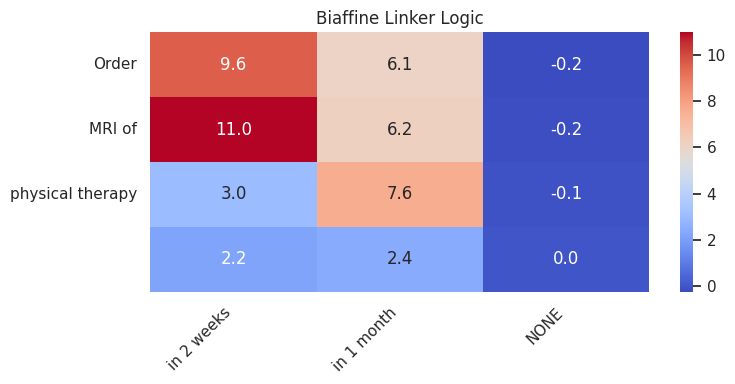

In [ ]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def visualize_clean_heatmap(model, tokenizer, note_text, device):
    model.eval()

    # 1. NER Pass
    enc = tokenizer(note_text, return_offsets_mapping=True, return_tensors='pt', truncation=True, max_length=512)
    #inputs = {k: v.to(device) for k, v in enc.items() if k != 'offset_mapping'}
    # Filter inputs to only include what the model's forward method expects
    inputs = {
        k: v.to(device) for k, v in enc.items() # <--- Added .to(device) here
        if k in ['input_ids', 'attention_mask']
    }
    offsets = enc['offset_mapping'][0].cpu().numpy()

    with torch.no_grad():
        out = model(**inputs)
    tag_ids = out['ner_logits'][0].argmax(-1).cpu().tolist()

    # 2. Extract Spans (Robust Logic)
    def extract_spans_by_tag(tags, start_id, inside_id):
        spans = []
        curr_span = None
        for i, t in enumerate(tags):
            if t == start_id:
                if curr_span: spans.append(curr_span)
                curr_span = [i, i]
            elif t == inside_id and curr_span:
                curr_span[1] = i
            else:
                if curr_span: spans.append(curr_span); curr_span = None
        if curr_span: spans.append(curr_span)
        return spans

    raw_acts = extract_spans_by_tag(tag_ids, 1, 2) # B-ACT=1, I-ACT=2
    raw_tims = extract_spans_by_tag(tag_ids, 3, 4) # B-TIME=3, I-TIME=4

    # 3. TEXT-BASED DEDUPLICATION (The Fix)
    # We map "Text String" -> "First Span Index". This kills duplicates.
    unique_acts = {}
    for s in raw_acts:
        text = note_text[offsets[s[0]][0]:offsets[s[1]][1]]
        if text not in unique_acts: unique_acts[text] = s

    unique_tims = {}
    for s in raw_tims:
        text = note_text[offsets[s[0]][0]:offsets[s[1]][1]]
        if text not in unique_tims: unique_tims[text] = s

    # Convert back to sorted lists
    act_labels = list(unique_acts.keys())
    act_spans = list(unique_acts.values())

    tim_labels = list(unique_tims.keys())
    tim_spans = list(unique_tims.values())

    print(f"Plotting {len(act_labels)} Actions: {act_labels}")
    print(f"Plotting {len(tim_labels)} Times: {tim_labels}")

    if not act_labels or not tim_labels:
        print("Skipping plot: Missing entities.")
        return

    # Add NONE column
    tim_labels.append("NONE")

    # 4. Get Biaffine Scores
    # Prepare batch
    a_tensor = torch.tensor(act_spans, device=device).unsqueeze(0)
    t_tensor = torch.tensor(tim_spans, device=device).unsqueeze(0)

    batch = {
        'input_ids': inputs['input_ids'],
        'attention_mask': inputs['attention_mask'],
        'action_spans': a_tensor,
        'time_spans': t_tensor,
        'action_mask': torch.ones((1, len(act_spans)), device=device),
        'time_mask': torch.ones((1, len(tim_spans)), device=device)
    }

    with torch.no_grad():
        logits = model(**batch)['link_logits'][0].cpu().numpy()

    # Slice to match labels
    logits = logits[:len(act_labels), :len(tim_labels)]

    # 5. Plot
    plt.figure(figsize=(8, 4))
    sns.heatmap(logits, annot=True, fmt=".1f", cmap="coolwarm",
                xticklabels=tim_labels, yticklabels=act_labels)
    plt.title("Biaffine Linker Logic")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

# --- RUN WITH SIMPLIFIED TEXT ---
# Sometimes "next month" is hard for models. "in 1 month" is easier.
clean_demo = "Order MRI of the knee in 2 weeks. Schedule physical therapy in 1 month."
visualize_clean_heatmap(biobert_model, biobert_tokenizer, clean_demo, DEVICE)

Plotting 2 Actions: ['MRI', 'physical therapy']
Plotting 2 Times: ['in 2 weeks', 'in 1 month']


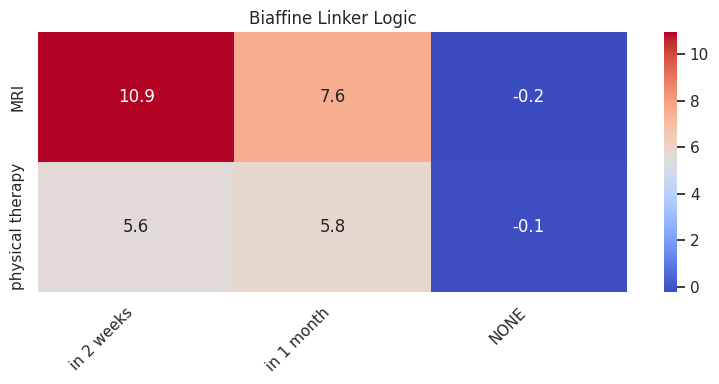

In [ ]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def visualize_clean_heatmap(model, tokenizer, note_text, device):
    model.eval()

    # 1. NER Pass
    enc = tokenizer(note_text, return_offsets_mapping=True, return_tensors='pt', truncation=True, max_length=512)
    #inputs = {k: v.to(device) for k, v in enc.items() if k != 'offset_mapping'}
    # Filter inputs to only include what the model's forward method expects
    inputs = {
        k: v.to(device) for k, v in enc.items() # <--- Added .to(device) here
        if k in ['input_ids', 'attention_mask']
    }
    offsets = enc['offset_mapping'][0].cpu().numpy()

    with torch.no_grad():
        out = model(**inputs)
    tag_ids = out['ner_logits'][0].argmax(-1).cpu().tolist()

    # 2. Extract Spans (Robust Logic)
    def extract_spans_by_tag(tags, start_id, inside_id):
        spans = []
        curr_span = None
        for i, t in enumerate(tags):
            if t == start_id:
                if curr_span: spans.append(curr_span)
                curr_span = [i, i]
            elif t == inside_id and curr_span:
                curr_span[1] = i
            else:
                if curr_span: spans.append(curr_span); curr_span = None
        if curr_span: spans.append(curr_span)
        return spans

    raw_acts = extract_spans_by_tag(tag_ids, 1, 2) # B-ACT=1, I-ACT=2
    raw_tims = extract_spans_by_tag(tag_ids, 3, 4) # B-TIME=3, I-TIME=4

    # 3. TEXT-BASED DEDUPLICATION (The Fix)
    # We map "Text String" -> "First Span Index". This kills duplicates.
    unique_acts = {}
    for s in raw_acts:
        text = note_text[offsets[s[0]][0]:offsets[s[1]][1]]
        if text not in unique_acts: unique_acts[text] = s

    unique_tims = {}
    for s in raw_tims:
        text = note_text[offsets[s[0]][0]:offsets[s[1]][1]]
        if text not in unique_tims: unique_tims[text] = s

    # Convert back to sorted lists
    act_labels = list(unique_acts.keys())
    act_spans = list(unique_acts.values())

    tim_labels = list(unique_tims.keys())
    tim_spans = list(unique_tims.values())

    print(f"Plotting {len(act_labels)} Actions: {act_labels}")
    print(f"Plotting {len(tim_labels)} Times: {tim_labels}")

    if not act_labels or not tim_labels:
        print("Skipping plot: Missing entities.")
        return

    # Add NONE column
    tim_labels.append("NONE")

    # 4. Get Biaffine Scores
    # Prepare batch
    a_tensor = torch.tensor(act_spans, device=device).unsqueeze(0)
    t_tensor = torch.tensor(tim_spans, device=device).unsqueeze(0)

    batch = {
        'input_ids': inputs['input_ids'],
        'attention_mask': inputs['attention_mask'],
        'action_spans': a_tensor,
        'time_spans': t_tensor,
        'action_mask': torch.ones((1, len(act_spans)), device=device),
        'time_mask': torch.ones((1, len(tim_spans)), device=device)
    }

    with torch.no_grad():
        logits = model(**batch)['link_logits'][0].cpu().numpy()

    # Slice to match labels
    logits = logits[:len(act_labels), :len(tim_labels)]

    # 5. Plot
    plt.figure(figsize=(8, 4))
    sns.heatmap(logits, annot=True, fmt=".1f", cmap="coolwarm",
                xticklabels=tim_labels, yticklabels=act_labels)
    plt.title("Biaffine Linker Logic")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

# --- RUN WITH SIMPLIFIED TEXT ---
# Sometimes "next month" is hard for models. "in 1 month" is easier.
clean_demo = "Order MRI in 2 weeks. Schedule physical therapy to stenght the muscles in 1 month."
#clean_demo = "Order MRI and CT. CT in 1 month and MRI in 2 weeks"
visualize_clean_heatmap(biobert_model, biobert_tokenizer, clean_demo, DEVICE)

Plotting 2 Actions: ['Neurology Consult', 'EMG']
Plotting 2 Times: ['in 14 days', 'within 10 months']


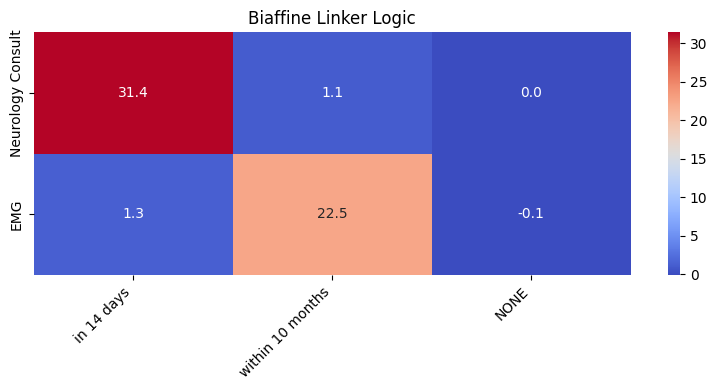

In [ ]:
visualize_clean_heatmap(biobert_model, biobert_tokenizer, sample_note, DEVICE)

In [ ]:
#load biobert
import json
import os
from google.colab import drive

# Mount Google Drive if not already mounted
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')
#reinitialize the model architecture
model = BioBertNerLinker(MODEL_NAME, NUM_TAGS)
#Load the weights
model.load_state_dict(torch.load('/content/drive/MyDrive/biobert_finetuned.pth'))

# Ensure the model is on the correct device (e.g., GPU)
model.to(DEVICE)
model.eval() # Set model to evaluation mode

Mounted at /content/drive


BioBertNerLinker(
  (encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, eleme

In [ ]:
import json
import pandas as pd

# Load the dataset (assuming df is already loaded from previous cells)
df = pd.read_csv('/content/synthetic_clinical_notes_10000.csv', keep_default_na=False)

def check_for_null_time_char_start(actions_gt_str):
    if not actions_gt_str:
        return False
    try:
        actions_list = json.loads(actions_gt_str)
        for item in actions_list:
            if item.get('time_char_start') is None:
                return True
    except json.JSONDecodeError:
        # Handle cases where json might be malformed if any exist
        return False
    return False

# Apply the function to the 'actions_gt' column and count rows where it's True
rows_with_null_time_char_start = df['actions_gt'].apply(check_for_null_time_char_start).sum()

print(f"Number of rows where 'time_char_start' is null in at least one action: {rows_with_null_time_char_start}")

Number of rows where 'time_char_start' is null in at least one action: 212


In [ ]:
rows_with_null_time_char_start_test = df_test['actions_gt'].apply(check_for_null_time_char_start).sum()

print(f"Number of rows where 'time_char_start' is null in at least one action: {rows_with_null_time_char_start}")

Number of rows where 'time_char_start' is null in at least one action: 212


## Part: LLaMA baseline (direct JSON extraction)

This section **reuses the exact same `df_train/df_val/df_test` split** as the BioBERT joint NER+link model, and evaluates the LLaMA baseline with the **same end task metric**: F1 over the set of `(action, period_date)` pairs per note (plus date MAE on matched actions).

We fine-tune an instruction model to read the full note and output a JSON list:

```json
[
  {"action": "MRI Brain", "period_date": "2025-02-15"}
]
```

Notes:
- Output must be **valid JSON** (double quotes).
- If no scheduled actions exist, output `[]`.


### 1) Fine-tune (example with Unsloth + LoRA)


### 2) Evaluate the LLaMA baseline on the shared test split

We run generation, parse the JSON, and compute the same `(action, period_date)` metrics as the BioBERT pipeline.


In [ ]:
import torch
if torch.cuda.get_device_capability()[0] >= 8:
    print("A100/H100 detected: Flash Attention and BF16 are fully supported.")

A100/H100 detected: Flash Attention and BF16 are fully supported.


In [ ]:
import torch
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install --no-deps "trl<0.9.0" peft accelerate bitsandbytes

from unsloth import FastLanguageModel
print("✅ Installation Successful.")

  Cloning https://github.com/unslothai/unsloth.git to /tmp/pip-install-47qwydot/unsloth_f25aee42184e4dfe84c161fb91462aa2
  Running command git clone --filter=blob:none --quiet https://github.com/unslothai/unsloth.git /tmp/pip-install-47qwydot/unsloth_f25aee42184e4dfe84c161fb91462aa2
  Resolved https://github.com/unslothai/unsloth.git to commit e51d3ea2e498fc893770d92ca6727bd113918480
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 46.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.8/506.8 kB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 kB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.2/181.2 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 MB 57.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 27.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd, json, re
from datasets import Dataset

#df = pd.read_csv("synthetic_clinical_notes_10000.csv", engine="python", on_bad_lines="skip")
df = pd.read_csv("synthetic_clinical_notes_2000.csv", engine="python", on_bad_lines="skip")

print("✅ Loaded:", len(df))

def _safe_load_actions_gt(x):
    if not isinstance(x, str) or not x.strip():
        return []
    try:
        return json.loads(x)
    except:
        return []

# Build closed-set actions from the dataset itself (most robust)
closed = set()
# Use the full dataframe (df) to ensure we capture all possible actions in train/val/test
for x in df["actions_gt"].astype(str).tolist():
    for a in _safe_load_actions_gt(x):
        if a.get("action"):
            closed.add(a.get("action").strip())

# Sort them to be deterministic
CLOSED_ACTIONS = sorted(list(closed))
# Fix: ensure normalization matches what the model outputs (case-insensitive usually)
# But keeping original casing for display is fine.

print("✅ CORRECTED CLOSED_ACTIONS:", len(CLOSED_ACTIONS))
print("Sample:", CLOSED_ACTIONS[:15])

✅ Loaded: 2000
✅ CORRECTED CLOSED_ACTIONS: 28
Sample: ['Abdominal Ultrasound', 'Annual Physical', 'Blood Test', 'Breath Test', 'CT Scan', 'Cardiac MRI', 'Cardiology Consult', 'Colonoscopy', 'EEG', 'EMG', 'Echocardiogram', 'Endoscopy', 'GI Consult', 'Holter Monitor', 'Joint Injection']


In [ ]:
# =========================
# Load dataset (your 10k CSV)
# =========================
import pandas as pd
from sklearn.metrics import classification_report
import numpy as np
import ast
import json
#DATA_PATH = "synthetic_clinical_notes_10000.csv"  # change if needed
DATA_PATH = "synthetic_clinical_notes_2000.csv"  # change if needed

df = pd.read_csv(DATA_PATH, keep_default_na=False)

def parse_actions_gt(s):
    # 1. Handle NaN / None / Empty
    if s is None or (isinstance(s, float) and np.isnan(s)) or s == "":
        return []

    # 2. Try Standard JSON first (fastest)
    try:
        return json.loads(s)
    except (json.JSONDecodeError, TypeError):
        pass

    # 3. Try Python literal_eval (handles single quotes: {'key': 'val'})
    try:
        return ast.literal_eval(s)
    except (ValueError, SyntaxError):
        pass

    # 4. Return empty if all fails (and maybe print a warning)
    # print(f"Warning: Could not parse row: {s}")
    return []

# Apply the robust function
df["actions_gt_obj"] = df["actions_gt"].apply(parse_actions_gt)

# Verification: Check if any non-empty strings resulted in empty lists
debug_mask = (df["actions_gt"].str.len() > 5) & (df["actions_gt_obj"].str.len() == 0)
if debug_mask.sum() > 0:
    print("Warning: Some non-empty rows failed to parse. Examples:")
    print(df.loc[debug_mask, "actions_gt"].head())

# Simple stable split (80/10/10)
rng = np.random.default_rng(42)
idx = np.arange(len(df))
rng.shuffle(idx)

n = len(df)
n_train = int(0.8 * n)
n_val = int(0.1 * n)

train_idx = idx[:n_train]
val_idx = idx[n_train:n_train+n_val]
test_idx = idx[n_train+n_val:]

df_train = df.iloc[train_idx].reset_index(drop=True)
df_val   = df.iloc[val_idx].reset_index(drop=True)
df_test  = df.iloc[test_idx].reset_index(drop=True)

print("Split sizes:", len(df_train), len(df_val), len(df_test))


Split sizes: 1600 200 200


In [ ]:
LLAMA_TARGET_MODE = "date_only"   # or "text_and_date"

In [ ]:
import pandas as pd

In [ ]:
system_prompt = """You are an expert clinical information extraction system.

Task:
Extract ONLY scheduled follow-up items from the clinical note (tests/labs/imaging/referrals/therapy explicitly planned for the future).
Ignore history/past tests/symptom duration.

Return ONLY valid JSON.
"""

def _canon_ws(s: str) -> str:
    return re.sub(r"\s+", " ", (s or "").strip())

def build_target(actions_gt_list):
    # Only scheduled items in GT are in actions_gt_list already
    out = []
    for a in actions_gt_list:
        act = a.get("action")
        pt  = a.get("period_text")
        pd  = a.get("period_date")
        if not act or not pd:
            continue

        if LLAMA_TARGET_MODE == "date_only":
            out.append({"action": act, "period_date": pd})
        else:
            # grounded mode
            out.append({"action": act, "period_text": pt or "", "period_date": pd})
    return out

def format_row(row):
    note = row.get("note_text", "")
    gt_list = _safe_load_actions_gt(row.get("actions_gt", "[]"))

    target = build_target(gt_list)

    # (Optional) include allowed list in the prompt (recommended for fair closed-set comparison)
    allowed_actions = "\n".join([f"- {a}" for a in CLOSED_ACTIONS])


    user_prompt = f"""Rules:
- Output must be a JSON array (possibly empty).
- Each item must be a scheduled follow-up item from the note (not history).
- action must be EXACTLY one of the allowed actions below (no new actions).
- period_date must be computed relative to the visit date line in the note (YYYY-MM-DD).
{"- period_text must be copied verbatim from the note.\n" if LLAMA_TARGET_MODE != "date_only" else ""}
- If no scheduled items: return [].
- Output JSON only (no markdown, no extra text).

Allowed actions:
{allowed_actions}

Clinical note:
{note}
"""

    target_json = json.dumps(target, ensure_ascii=False)

    text = f"""<|begin_of_text|><|start_header_id|>system<|end_header_id|>

{system_prompt}<|eot_id|><|start_header_id|>user<|end_header_id|>

{user_prompt}<|eot_id|><|start_header_id|>assistant<|end_header_id|>

{target_json}<|eot_id|>"""

    return {"text": text}

from datasets import Dataset
#dataset = Dataset.from_pandas(df)
train_dataset = Dataset.from_pandas(df_train)
train_dataset = train_dataset.map(format_row, remove_columns=train_dataset.column_names)
val_dataset = Dataset.from_pandas(df_val)
val_dataset = val_dataset.map(format_row, remove_columns=val_dataset.column_names)

def is_row_clean(gt_list):
    # Returns True only if ALL items in the list have valid start positions
    if not gt_list: return True # Empty list is technically "clean" (nothing to miss)

    for item in gt_list:
        # If any item exists but has no location, the whole row is "tainted"
        if item.get('action_char_start') is None:
            return False
    return True

clean_mask = df_test["actions_gt_obj"].apply(is_row_clean)
df_test_clean = df_test[clean_mask].copy()
test_dataset = Dataset.from_pandas(df_test_clean)
test_dataset = test_dataset.map(format_row, remove_columns=test_dataset.column_names)
print("✅ Data formatted. Example:\n", train_dataset[0]["text"][:1200])

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/198 [00:00<?, ? examples/s]

✅ Data formatted. Example:
 <|begin_of_text|><|start_header_id|>system<|end_header_id|>

You are an expert clinical information extraction system.

Task:
Extract ONLY scheduled follow-up items from the clinical note (tests/labs/imaging/referrals/therapy explicitly planned for the future).
Ignore history/past tests/symptom duration.

Return ONLY valid JSON.
<|eot_id|><|start_header_id|>user<|end_header_id|>

Rules:
- Output must be a JSON array (possibly empty).
- Each item must be a scheduled follow-up item from the note (not history).
- action must be EXACTLY one of the allowed actions below (no new actions).
- period_date must be computed relative to the visit date line in the note (YYYY-MM-DD).

- If no scheduled items: return [].
- Output JSON only (no markdown, no extra text).

Allowed actions:
- Abdominal Ultrasound
- Annual Physical
- Blood Test
- Breath Test
- CT Scan
- Cardiac MRI
- Cardiology Consult
- Colonoscopy
- EEG
- EMG
- Echocardiogram
- Endoscopy
- GI Consult
- Holter

In [ ]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import FastLanguageModel
import torch, gc

# Clean memory
gc.collect()
torch.cuda.empty_cache()

max_seq_length = 2048

llama_model, llama_tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/llama-3-8b-instruct-bnb-4bit",
    max_seq_length = max_seq_length,
    dtype = None,
    load_in_4bit = True,
)

llama_model = FastLanguageModel.get_peft_model(
    llama_model,
    r = 16,
    target_modules = ["q_proj","k_proj","v_proj","o_proj","gate_proj","up_proj","down_proj"],
    lora_alpha = 16,
    lora_dropout = 0,
    bias = "none",
    use_gradient_checkpointing = "unsloth",
    random_state = 42,
)

# Simple split
#dataset = dataset.shuffle(seed=42)
#train_test = dataset.train_test_split(test_size=0.05, seed=42)
# train_ds = train_test["train"]
# val_ds   = train_test["test"]
train_ds = train_dataset
val_ds   = val_dataset

llama_trainer = SFTTrainer(
    model = llama_model,
    tokenizer = llama_tokenizer,
    train_dataset = train_ds,
    eval_dataset = val_ds,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    #packing = False,
    packing = True,
    args = TrainingArguments(
        output_dir = "lora_out",
        #per_device_train_batch_size = 2,
        per_device_train_batch_size = 8,
        #gradient_accumulation_steps = 8,
        gradient_accumulation_steps = 2,
        learning_rate = 2e-4,
        warmup_steps = 50,
        #warmup_steps = 100,
        #num_train_epochs = 1,
        num_train_epochs = 4,
        #logging_steps = 20,
        #logging_steps = 5,
        logging_steps = 10,
        eval_strategy = "steps",
        #eval_steps = 200,
        #eval_steps = 100,
        eval_steps = 50,
        #save_steps = 200,
        #save_steps = 100,
        save_steps = 50,
        save_total_limit = 2,
        # Fix: Automatically select bf16 if supported, otherwise fp16
        #fp16 = not torch.cuda.is_bf16_supported(),
        fp16 = False,
        #bf16 = torch.cuda.is_bf16_supported(),
        bf16 = True,
        tf32 = True,
        optim="adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "cosine",
        report_to = "none",

        # --- RECOMMENDATION ---
        # Disable packing for JSON tasks. Packing combines multiple short samples into one sequence.
        # For strict JSON formatting, it's often better to let the model see
        # clear "Start -> End" boundaries for every single example.
        group_by_length = True,        # Helps efficiency without mashing samples together
    ),
)

llama_trainer.train()

llama_model.save_pretrained("lora_model")
llama_tokenizer.save_pretrained("lora_model")
print("✅ Saved LoRA adapter to lora_model/")

==((====))==  Unsloth 2026.1.4: Fast Llama patching. Transformers: 4.57.6.
   \\   /|    NVIDIA A100-SXM4-80GB. Num GPUs = 1. Max memory: 79.318 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu126. CUDA: 8.0. CUDA Toolkit: 12.6. Triton: 3.5.0
\        /    Bfloat16 = TRUE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/220 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/345 [00:00<?, ?B/s]

Unsloth 2026.1.4 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 429 | Num Epochs = 4 | Total steps = 108
O^O/ \_/ \    Batch size per device = 8 | Gradient accumulation steps = 2
\        /    Data Parallel GPUs = 1 | Total batch size (8 x 2 x 1) = 16
 "-____-"     Trainable parameters = 41,943,040 of 8,072,204,288 (0.52% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss,Validation Loss
50,0.504600,0.472854
100,0.378700,0.409221


Unsloth: Not an error, but LlamaForCausalLM does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


✅ Saved LoRA adapter to lora_model/


In [ ]:
import json
from unsloth import FastLanguageModel

# Reload adapter in inference mode (if not already loaded)
# model, tokenizer = FastLanguageModel.from_pretrained( ... )
FastLanguageModel.for_inference(llama_model)

def _extract_json_array(text: str):
    if not text:
        return None
    # find first '[' and last ']'
    i = text.find("[")
    j = text.rfind("]")
    if i == -1 or j == -1 or j < i:
        return None
    cand = text[i:j+1].strip()
    try:
        return json.loads(cand)
    except:
        return None

# --- FIX: Match Training Prompt EXACTLY ---
SYSTEM_LLAMA = (
    "You are an expert clinical information extraction system. "
    "Extract scheduled follow-up actions and their timing from the note."
)

def build_llama_user_prompt_inference(note_text: str, closed_actions_list: list) -> str:
    # Matches the function 'build_llama_user_prompt' from cell pljEN2aXkiRv
    actions_list = "\n".join([f"- {a}" for a in closed_actions_list])
    return f"""Task:
From the clinical note, extract ONLY scheduled follow-up items that match the allowed closed-set actions.
Return a JSON array (possibly empty). Each element MUST have exactly these keys:
- action (one of the allowed actions, exact string)
- period_date (YYYY-MM-DD computed relative to the visit date)

Rules:
- Use ONLY actions from the allowed list below (no new actions).
- period_date must be computed using the visit date in the note.
- If no scheduled items: return [].
- Output JSON only (no markdown, no extra text).

Allowed actions (closed set):
{actions_list}

Clinical note:
{note_text}
"""

def predict_llama(note_text: str):
    # Use global CLOSED_ACTIONS (ensure it's the 28 items)
    user_prompt = build_llama_user_prompt_inference(note_text, CLOSED_ACTIONS)

    # Apply chat template (Standard Llama-3 format)
    messages = [
        {"role": "system", "content": SYSTEM_LLAMA},
        {"role": "user", "content": user_prompt},
    ]
    prompt = llama_tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

    inputs = llama_tokenizer([prompt], return_tensors="pt").to("cuda")
    outputs = llama_model.generate(
        **inputs,
        max_new_tokens=256,
        use_cache=True,
        stop_strings=["<|eot_id|>"],
        tokenizer=llama_tokenizer,
    )
    gen = llama_tokenizer.batch_decode(outputs[:, inputs.input_ids.shape[1]:], skip_special_tokens=True)[0].strip()
    parsed = _extract_json_array(gen)
    return gen, parsed

# Test on a hard example
test_note = "Date of Visit: 2025-08-05\nPLAN:\n- MRI in 2 weeks\n- Blood Test in 1 month\n"
raw, parsed = predict_llama(test_note)
print("RAW:\n", raw)
print("PARSED:\n", parsed)

RAW:
 [{"action": "MRI", "period_date": "2025-08-19"}, {"action": "Blood Test", "period_date": "2025-09-05"}]
PARSED:
 [{'action': 'MRI', 'period_date': '2025-08-19'}, {'action': 'Blood Test', 'period_date': '2025-09-05'}]


In [ ]:
# from typing import Optional, List, Any
# from tqdm import tqdm
# import pandas as pd
# import json
# import re
# from datetime import datetime

# # --- Helper Functions (Redefined for safety) ---
# def _canon_ws(s: str) -> str:
#     return re.sub(r"\s+", " ", (s or "").strip())

# def canon_action_key(s: str) -> str:
#     return _canon_ws(s).casefold()

# def safe_load_actions_gt(s: str):
#     if not s or s == "[]":
#         return []
#     try:
#         return json.loads(s)
#     except Exception:
#         return []

# def safe_json_array_extract(text: str):
#     if not text: return None
#     t = text.strip()
#     try:
#         obj = json.loads(t)
#         return obj if isinstance(obj, list) else None
#     except Exception:
#         pass
#     m = re.search(r"\[[\s\S]*\]", t)
#     if m:
#         try:
#             obj = json.loads(m.group(0))
#             return obj if isinstance(obj, list) else None
#         except Exception:
#             pass
#     return None

# def calculate_metrics(tp: int, fp: int, fn: int):
#     p = tp / (tp + fp) if (tp + fp) > 0 else 0.0
#     r = tp / (tp + fn) if (tp + fn) > 0 else 0.0
#     f1 = 2 * p * r / (p + r) if (p + r) > 0 else 0.0
#     return p, r, f1

# # --- Main Evaluation Function ---
# def eval_llama_finetuned(df: pd.DataFrame, closed_actions: Optional[List[str]] = None, limit: Optional[int] = None):
#     # Counters
#     tp_act, fp_act, fn_act = 0, 0, 0
#     tp_date, fp_date, fn_date = 0, 0, 0
#     tp_pair, fp_pair, fn_pair = 0, 0, 0

#     total = 0
#     json_error_count = 0
#     abs_err_days = []
#     n_matched_actions = 0

#     # Prepare closed set for filtering
#     closed_set = set(canon_action_key(a) for a in closed_actions) if closed_actions else None

#     loop_limit = min(limit, len(df)) if limit else len(df)

#     print(f"Evaluating {loop_limit} samples...")
#     for i, row in enumerate(tqdm(df.itertuples(index=False), total=loop_limit)):
#         if limit and i >= limit: break
#         total += 1

#         note = getattr(row, "note_text")
#         gt_raw = safe_load_actions_gt(getattr(row, "actions_gt"))

#         # 1. Parse Ground Truth
#         gt_acts = set()
#         gt_dates = set()
#         gt_pairs = set()
#         gt_map = {} # action -> date

#         for item in gt_raw:
#             a = canon_action_key(item.get("action", ""))
#             d = item.get("period_date")

#             if a:
#                 gt_acts.add(a)
#                 if d:
#                     gt_dates.add(d)
#                     gt_pairs.add((a, d))
#                     gt_map[a] = d

#         # 2. Run Model Prediction
#         try:
#             raw_out, parsed = predict_llama(note)
#         except Exception:
#             parsed = None

#         if parsed is None:
#             json_error_count += 1
#             parsed = []

#         # 3. Parse Predictions
#         pred_acts = set()
#         pred_dates = set()
#         pred_pairs = set()
#         pred_map = {} # action -> date

#         for item in parsed:
#             if not isinstance(item, dict): continue
#             a = canon_action_key(item.get("action", ""))
#             d = item.get("period_date")

#             # Apply closed-set filter
#             if closed_set and a not in closed_set:
#                 continue

#             pred_acts.add(a)
#             if d:
#                 pred_dates.add(d)
#             if a and d:
#                 pred_pairs.add((a, d))
#                 pred_map[a] = d

#         # 4. Update Stats
#         # Actions Only
#         tp_act += len(pred_acts & gt_acts)
#         fp_act += len(pred_acts - gt_acts)
#         fn_act += len(gt_acts - pred_acts)

#         # Dates Only (Independent of Action)
#         tp_date += len(pred_dates & gt_dates)
#         fp_date += len(pred_dates - gt_dates)
#         fn_date += len(gt_dates - pred_dates)

#         # Pairs (Action + Date)
#         tp_pair += len(pred_pairs & gt_pairs)
#         fp_pair += len(pred_pairs - gt_pairs)
#         fn_pair += len(gt_pairs - pred_pairs)

#         # 5. MAE Calculation
#         common_actions = gt_map.keys() & pred_map.keys()
#         n_matched_actions += len(common_actions)

#         for act in common_actions:
#             gd = gt_map[act]
#             pd_val = pred_map[act]
#             try:
#                 gdt = datetime.strptime(gd, "%Y-%m-%d")
#                 pdt = datetime.strptime(pd_val, "%Y-%m-%d")
#                 diff = abs((pdt - gdt).days)
#                 abs_err_days.append(diff)
#             except Exception:
#                 pass

#     # Calculate Metrics
#     p_act, r_act, f_act = calculate_metrics(tp_act, fp_act, fn_act)
#     p_date, r_date, f_date = calculate_metrics(tp_date, fp_date, fn_date)
#     p_pair, r_pair, f_pair = calculate_metrics(tp_pair, fp_pair, fn_pair)

#     # Conditional Accuracy: How often is the date correct if the action is correct?
#     cond_acc = tp_pair / tp_act if tp_act > 0 else 0.0
#     mae = sum(abs_err_days) / len(abs_err_days) if abs_err_days else 0.0

#     return {
#         "n_eval": total,
#         "json_valid_rate": (total - json_error_count) / total if total else 0.0,
#         "bad_json_parse_suspected": json_error_count,

#         "ACTION_precision": p_act,
#         "ACTION_recall": r_act,
#         "ACTION_f1": f_act,

#         "DATE_ONLY_precision": p_date,
#         "DATE_ONLY_recall": r_date,
#         "DATE_ONLY_f1": f_date,

#         "action_date_precision": p_pair,
#         "action_date_recall": r_pair,
#         "action_date_f1": f_pair,

#         "period_date_exact_acc_on_matched_actions": cond_acc,
#         "period_date_abs_err_days_mae_on_matched_actions": mae,
#         "n_matched_actions_for_date": n_matched_actions,
#         "tp_fp_fn_pair": [tp_pair, fp_pair, fn_pair]
#     }

# # --- Run Evaluation ---
# # Ensure CLOSED_ACTIONS is defined (from previous cells)
# if 'CLOSED_ACTIONS' not in globals():
#     # Fallback if variable lost
#     CLOSED_ACTIONS = []

# metrics_dict = eval_llama_finetuned(df_test_clean, closed_actions=CLOSED_ACTIONS, limit=None)

# print(json.dumps(metrics_dict, indent=2))

Evaluating 198 samples...


100%|██████████| 198/198 [08:12<00:00,  2.49s/it]

{
  "n_eval": 198,
  "json_valid_rate": 1.0,
  "bad_json_parse_suspected": 0,
  "ACTION_precision": 1.0,
  "ACTION_recall": 1.0,
  "ACTION_f1": 1.0,
  "DATE_ONLY_precision": 0.8367346938775511,
  "DATE_ONLY_recall": 0.8367346938775511,
  "DATE_ONLY_f1": 0.8367346938775511,
  "action_date_precision": 0.826530612244898,
  "action_date_recall": 0.826530612244898,
  "action_date_f1": 0.826530612244898,
  "period_date_exact_acc_on_matched_actions": 0.826530612244898,
  "period_date_abs_err_days_mae_on_matched_actions": 5.423469387755102,
  "n_matched_actions_for_date": 196,
  "tp_fp_fn_pair": [
    162,
    34,
    34
  ]
}


In [ ]:
#updated metrics-instead the previous block
from typing import Optional, List, Dict, Any
from tqdm import tqdm
import pandas as pd
import json
import re
from datetime import datetime

# --- Helper Functions ---
def _canon_ws(s: str) -> str:
    return re.sub(r"\s+", " ", (s or "").strip())

def canon_action_key(s: str) -> str:
    return _canon_ws(s).casefold()

def safe_load_actions_gt(s: str):
    if not s or s == "[]": return []
    try: return json.loads(s)
    except: return []

def calculate_metrics(tp: int, fp: int, fn: int):
    p = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    r = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1 = 2 * p * r / (p + r) if (p + r) > 0 else 0.0
    return p, r, f1

def eval_llama_comprehensive(df: pd.DataFrame, closed_actions: List[str], limit: Optional[int] = None):
    """
    Calculates FULL metrics (Precision, Recall, F1, MAE) for two modes:
    1. STRICT (Real World): Hallucinations count as errors.
    2. CONSTRAINED (Logic Check): Hallucinations are filtered out.
    """

    # Initialize Counters
    # S=Strict, C=Constrained | A=Action, D=Date, P=Pair
    stats = {
        "S_tp_A": 0, "S_fp_A": 0, "S_fn_A": 0,
        "S_tp_D": 0, "S_fp_D": 0, "S_fn_D": 0,
        "S_tp_P": 0, "S_fp_P": 0, "S_fn_P": 0,

        "C_tp_A": 0, "C_fp_A": 0, "C_fn_A": 0,
        "C_tp_D": 0, "C_fp_D": 0, "C_fn_D": 0,
        "C_tp_P": 0, "C_fp_P": 0, "C_fn_P": 0,

        "abs_err_days": [],
        "hallucinations": 0,
        "total_predictions": 0,
        "json_errors": 0,
        "total_samples": 0
    }

    closed_set = set(canon_action_key(a) for a in closed_actions)
    loop_limit = min(limit, len(df)) if limit else len(df)

    print(f"Running Comprehensive Eval on {loop_limit} samples...")

    for i, row in enumerate(tqdm(df.itertuples(index=False), total=loop_limit)):
        if limit and i >= limit: break
        stats["total_samples"] += 1

        note = getattr(row, "note_text")
        gt_raw = safe_load_actions_gt(getattr(row, "actions_gt"))

        # --- 1. Parse Ground Truth ---
        gt_acts = set()
        gt_dates = set()
        gt_pairs = set()
        gt_map = {}

        for item in gt_raw:
            a = canon_action_key(item.get("action", ""))
            d = item.get("period_date")
            if a and d:
                gt_acts.add(a)
                gt_dates.add(d)
                gt_pairs.add((a, d))
                gt_map[a] = d

        # --- 2. Get Model Prediction ---
        try:
            _, parsed_list = predict_llama(note)
        except:
            parsed_list = None

        if parsed_list is None:
            stats["json_errors"] += 1
            parsed_list = []

        # --- 3. Build Prediction Sets ---
        s_pred_acts = set()
        s_pred_dates = set()
        s_pred_pairs = set()
        s_pred_map = {}

        c_pred_acts = set()
        c_pred_dates = set()
        c_pred_pairs = set()

        for item in parsed_list:
            if not isinstance(item, dict): continue

            a_raw = item.get("action", "")
            a_norm = canon_action_key(a_raw)
            d = item.get("period_date")

            if not a_norm or not d: continue
            stats["total_predictions"] += 1

            # Check Hallucination
            is_valid = a_norm in closed_set
            if not is_valid:
                stats["hallucinations"] += 1

            # STRICT: Add everything
            s_pred_acts.add(a_norm)
            s_pred_dates.add(d)
            s_pred_pairs.add((a_norm, d))
            s_pred_map[a_norm] = d

            # CONSTRAINED: Add only if valid
            if is_valid:
                c_pred_acts.add(a_norm)
                c_pred_dates.add(d)
                c_pred_pairs.add((a_norm, d))

        # --- 4. Update Stats (Strict) ---
        stats["S_tp_A"] += len(s_pred_acts & gt_acts)
        stats["S_fp_A"] += len(s_pred_acts - gt_acts)
        stats["S_fn_A"] += len(gt_acts - s_pred_acts)

        stats["S_tp_D"] += len(s_pred_dates & gt_dates)
        stats["S_fp_D"] += len(s_pred_dates - gt_dates)
        stats["S_fn_D"] += len(gt_dates - s_pred_dates)

        stats["S_tp_P"] += len(s_pred_pairs & gt_pairs)
        stats["S_fp_P"] += len(s_pred_pairs - gt_pairs)
        stats["S_fn_P"] += len(gt_pairs - s_pred_pairs)

        # --- 5. Update Stats (Constrained) ---
        stats["C_tp_A"] += len(c_pred_acts & gt_acts)
        stats["C_fp_A"] += len(c_pred_acts - gt_acts)
        stats["C_fn_A"] += len(gt_acts - c_pred_acts)

        stats["C_tp_D"] += len(c_pred_dates & gt_dates)
        stats["C_fp_D"] += len(c_pred_dates - gt_dates)
        stats["C_fn_D"] += len(gt_dates - c_pred_dates)

        stats["C_tp_P"] += len(c_pred_pairs & gt_pairs)
        stats["C_fp_P"] += len(c_pred_pairs - gt_pairs)
        stats["C_fn_P"] += len(gt_pairs - c_pred_pairs)

        # --- 6. MAE Calculation ---
        common_acts = gt_map.keys() & s_pred_map.keys()
        for act in common_acts:
            try:
                gdt = datetime.strptime(gt_map[act], "%Y-%m-%d")
                pdt = datetime.strptime(s_pred_map[act], "%Y-%m-%d")
                stats["abs_err_days"].append(abs((pdt - gdt).days))
            except: pass

    # --- 7. Final Calculations ---
    def get_f1(prefix, type_suffix):
        # Returns (Precision, Recall, F1)
        return calculate_metrics(
            stats[f"{prefix}_tp_{type_suffix}"],
            stats[f"{prefix}_fp_{type_suffix}"],
            stats[f"{prefix}_fn_{type_suffix}"]
        )

    # Calculate all 6 sets of metrics
    s_a_p, s_a_r, s_a_f1 = get_f1("S", "A") # Strict Action
    s_d_p, s_d_r, s_d_f1 = get_f1("S", "D") # Strict Date
    s_p_p, s_p_r, s_p_f1 = get_f1("S", "P") # Strict Pair

    c_a_p, c_a_r, c_a_f1 = get_f1("C", "A") # Constrained Action
    c_d_p, c_d_r, c_d_f1 = get_f1("C", "D") # Constrained Date
    c_p_p, c_p_r, c_p_f1 = get_f1("C", "P") # Constrained Pair

    mae = sum(stats["abs_err_days"]) / len(stats["abs_err_days"]) if stats["abs_err_days"] else 0.0
    h_rate = stats["hallucinations"] / stats["total_predictions"] if stats["total_predictions"] else 0.0
    # Calculate Conditional Accuracy: (TP_Pair) / (TP_Action)
    # "If the model found the action, how often was the date also correct?"
    cond_acc = stats["S_tp_P"] / stats["S_tp_A"] if stats["S_tp_A"] > 0 else 0.0

    return {
        # --- PRIMARY METRIC (Strict Action + Date) ---
        "STRICT_action_date_f1": s_p_f1,
        "STRICT_action_date_precision": s_p_p,
        "STRICT_action_date_recall": s_p_r,

        # --- Strict Action Only ---
        "STRICT_action_f1": s_a_f1,
        "STRICT_action_precision": s_a_p,
        "STRICT_action_recall": s_a_r,

        # --- Strict Date Only ---
        "STRICT_date_only_f1": s_d_f1,
        "STRICT_date_only_precision": s_d_p,
        "STRICT_date_only_recall": s_d_r,

        # --- Constrained Metrics (Ideal Logic) ---
        "CONSTRAINED_action_date_f1": c_p_f1,
        "CONSTRAINED_action_date_precision": c_p_p,
        "CONSTRAINED_action_date_recall": c_p_r,

        "CONSTRAINED_action_f1": c_a_f1,
        "CONSTRAINED_action_precision": c_a_p,
        "CONSTRAINED_action_recall": c_a_r,

        # --- Diagnostics ---
        "hallucination_rate": h_rate,
        "mae_days": mae,
        "json_valid_rate": 1.0 - (stats["json_errors"] / stats["total_samples"]),

        # --- RESTORED METRICS FOR PLOTTING ---
        "period_date_exact_acc_on_matched_actions": cond_acc,          # <--- Needed for Accuracy Plot
        "period_date_abs_err_days_mae_on_matched_actions": mae,       # (Alias for compatibility)
        "n_matched_actions_for_date": stats["S_tp_A"],                 # (Count of correct actions)
        "n_eval": stats["total_samples"]
    }

# Run Eval
if 'CLOSED_ACTIONS' not in globals(): CLOSED_ACTIONS = []
metrics = eval_llama_comprehensive(df_test_clean, CLOSED_ACTIONS, limit=None)
print(json.dumps(metrics, indent=2))

Running Comprehensive Eval on 198 samples...


100%|██████████| 198/198 [08:13<00:00,  2.49s/it]

{
  "STRICT_action_date_f1": 0.8295165394402036,
  "STRICT_action_date_precision": 0.8274111675126904,
  "STRICT_action_date_recall": 0.8316326530612245,
  "STRICT_action_f1": 0.9974554707379135,
  "STRICT_action_precision": 0.9949238578680203,
  "STRICT_action_recall": 1.0,
  "STRICT_date_only_f1": 0.8396946564885496,
  "STRICT_date_only_precision": 0.8375634517766497,
  "STRICT_date_only_recall": 0.8418367346938775,
  "CONSTRAINED_action_date_f1": 0.8295165394402036,
  "CONSTRAINED_action_date_precision": 0.8274111675126904,
  "CONSTRAINED_action_date_recall": 0.8316326530612245,
  "CONSTRAINED_action_f1": 0.9974554707379135,
  "CONSTRAINED_action_precision": 0.9949238578680203,
  "CONSTRAINED_action_recall": 1.0,
  "hallucination_rate": 0.0,
  "mae_days": 8.816326530612244,
  "json_valid_rate": 1.0,
  "period_date_exact_acc_on_matched_actions": 0.8316326530612245,
  "period_date_abs_err_days_mae_on_matched_actions": 8.816326530612244,
  "n_matched_actions_for_date": 196,
  "n_eval":

In [ ]:
metrics

{'STRICT_action_date_f1': 0.8295165394402036,
 'STRICT_action_date_precision': 0.8274111675126904,
 'STRICT_action_date_recall': 0.8316326530612245,
 'STRICT_action_f1': 0.9974554707379135,
 'STRICT_action_precision': 0.9949238578680203,
 'STRICT_action_recall': 1.0,
 'STRICT_date_only_f1': 0.8396946564885496,
 'STRICT_date_only_precision': 0.8375634517766497,
 'STRICT_date_only_recall': 0.8418367346938775,
 'CONSTRAINED_action_date_f1': 0.8295165394402036,
 'CONSTRAINED_action_date_precision': 0.8274111675126904,
 'CONSTRAINED_action_date_recall': 0.8316326530612245,
 'CONSTRAINED_action_f1': 0.9974554707379135,
 'CONSTRAINED_action_precision': 0.9949238578680203,
 'CONSTRAINED_action_recall': 1.0,
 'hallucination_rate': 0.0,
 'mae_days': 8.816326530612244,
 'json_valid_rate': 1.0,
 'period_date_exact_acc_on_matched_actions': 0.8316326530612245,
 'period_date_abs_err_days_mae_on_matched_actions': 8.816326530612244,
 'n_matched_actions_for_date': 196,
 'n_eval': 198}

In [ ]:
#metrics_llama = metrics_dict
metrics_llama = metrics

In [ ]:
import json
import os
from google.colab import drive

# Mount Google Drive if not already mounted
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# Define the path to save the metrics
save_path = '/content/drive/MyDrive/llama_finetuned_metrics.json'

# Ensure the metrics_dict variable exists (from previous evaluation)
if 'metrics_dict' in globals():
    with open(save_path, 'w') as f:
        json.dump(metrics_dict, f, indent=2)
    print(f"✅ Metrics saved successfully to {save_path}")
else:
    print("⚠️ metrics_dict not found. Please run the evaluation cell first.")


✅ Metrics saved successfully to /content/drive/MyDrive/llama_finetuned_metrics.json


In [ ]:
import json
import os
from google.colab import drive

# Mount Google Drive if not already mounted
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# Define the path where the metrics were saved
load_path = '/content/drive/MyDrive/llama_finetuned_metrics.json'

# Load the metrics_dict variable
#metrics_dict = None
metrics_llama = None
if os.path.exists(load_path):
    with open(load_path, 'r') as f:
        #metrics_dict = json.load(f)
        metrics_llama = json.load(f)
    print(f"✅ metrics_dict loaded successfully from {load_path}")
    # You can now print it to verify
    # print(json.dumps(metrics_dict, indent=2))
    print(json.dumps(metrics_llama, indent=2))
else:
    print(f"⚠️ Error: {load_path} not found. Please ensure the file exists.")


✅ metrics_dict loaded successfully from /content/drive/MyDrive/llama_finetuned_metrics.json
{
  "n_eval": 978,
  "json_valid_rate": 1.0,
  "bad_json_parse_suspected": 0,
  "ACTION_precision": 1.0,
  "ACTION_recall": 1.0,
  "ACTION_f1": 1.0,
  "DATE_ONLY_precision": 0.8621730382293763,
  "DATE_ONLY_recall": 0.8621730382293763,
  "DATE_ONLY_f1": 0.8621730382293763,
  "action_date_precision": 0.8618618618618619,
  "action_date_recall": 0.8618618618618619,
  "action_date_f1": 0.8618618618618619,
  "period_date_exact_acc_on_matched_actions": 0.8618618618618619,
  "period_date_abs_err_days_mae_on_matched_actions": 12.506012024048097,
  "n_matched_actions_for_date": 999,
  "tp_fp_fn_pair": [
    861,
    138,
    138
  ]
}


In [ ]:
#save the lora adapters and the tokenizer
new_model_name = "llama-3-finetuned-results"
trainer.model.save_pretrained(f"/content/drive/MyDrive/{new_model_name}")
tokenizer.save_pretrained(f"/content/drive/MyDrive/{new_model_name}")

('/content/drive/MyDrive/llama-3-finetuned-results/tokenizer_config.json',
 '/content/drive/MyDrive/llama-3-finetuned-results/special_tokens_map.json',
 '/content/drive/MyDrive/llama-3-finetuned-results/chat_template.jinja',
 '/content/drive/MyDrive/llama-3-finetuned-results/tokenizer.json')

In [ ]:
#loading llama 3
from peft import PeftModel, PeftConfig
from transformers import AutoModelForCausalLM, AutoTokenizer
base_model=AutoModelForCausalLM.from_pretrained("meta-llama/Meta-Llama-3-8B")
#Load your saved adapters from Drive
model = PeftModel.from_pretrained(base_model, "/content/drive/MyDrive/llama-3-finetuned-results")

In [ ]:
import json
from tqdm import tqdm

print("--- DIAGNOSING DATE MISMATCHES ---")
print("Searching for cases where Action is CORRECT but Date is WRONG...\n")

mismatches_found = 0

# Shuffle to get a random distribution of errors
for i, row in tqdm(df_test_clean.sample(frac=1, random_state=42).iterrows(), total=len(df_test_clean)):
    if mismatches_found >= 10: break

    note = row.note_text
    visit_date = getattr(row, "visit_date", "N/A")

    # Load GT
    gt_list = safe_load_actions_gt(row.actions_gt)
    gt_map = {canon_action_key(a['action']): a for a in gt_list if a.get('action')}

    # Run Prediction
    try:
        _, parsed = predict_llama(note)
    except:
        continue

    if not parsed or not isinstance(parsed, list):
        continue

    # Check predictions
    for item in parsed:
        if not isinstance(item, dict): continue

        p_act_raw = item.get("action", "")
        p_act = canon_action_key(p_act_raw)
        p_date = item.get("period_date")

        # We only care if the ACTION was found correctly
        if p_act in gt_map:
            gt_item = gt_map[p_act]
            gt_date = gt_item.get("period_date")
            gt_text = gt_item.get("period_text")

            # If Dates Mismatch
            if gt_date and p_date and gt_date != p_date:
                mismatches_found += 1

                print(f"\n🔸 CASE {mismatches_found}: {p_act_raw}")
                print(f"Visit Date: {visit_date}")
                print(f"Time Phrase (in Note): \"{gt_text}\"")
                print(f"GT Date:   {gt_date}")
                print(f"Pred Date: {p_date}")

                # Show context around the time phrase if possible
                idx = note.lower().find(gt_text.lower()) if gt_text else -1
                if idx != -1:
                    start = max(0, idx - 50)
                    end = min(len(note), idx + 50 + len(gt_text))
                    snippet = note[start:end].replace(chr(10), ' ')
                    print(f"Context:   \"...{snippet}...\"")
                else:
                    print(f"Note Start: \"{note[:100].replace(chr(10), ' ')}...\"")
                print("-" * 50)

--- DIAGNOSING DATE MISMATCHES ---
Searching for cases where Action is CORRECT but Date is WRONG...



  4%|▍         | 8/198 [00:18<08:42,  2.75s/it]


🔸 CASE 1: Orthopedic Consult
Visit Date: 2024-09-29
Time Phrase (in Note): "in three months"
GT Date:   2024-12-29
Pred Date: 2025-01-29
Context:   "...g and proper footwear.   ASSESSMENT & PLAN: Plan: In three months, Orthopedic Consult; 9 wks, Physical Therapy...."
--------------------------------------------------

🔸 CASE 2: Physical Therapy
Visit Date: 2024-09-29
Time Phrase (in Note): "9 wks"
GT Date:   2024-12-01
Pred Date: 2024-11-24
Context:   "... PLAN: Plan: In three months, Orthopedic Consult; 9 wks, Physical Therapy...."
--------------------------------------------------


  5%|▌         | 10/198 [00:23<08:42,  2.78s/it]


🔸 CASE 3: Breath Test
Visit Date: 2025-09-30
Time Phrase (in Note): "five wks"
GT Date:   2025-11-04
Pred Date: 2025-11-11
Context:   "...PLAN: Over the next 5 days, Abdominal Ultrasound; five wks, Breath Test. The patient will be educated on pot..."
--------------------------------------------------


  6%|▌         | 11/198 [00:27<09:38,  3.10s/it]


🔸 CASE 4: Neurology Consult
Visit Date: 2025-07-17
Time Phrase (in Note): "seven-week follow-up"
GT Date:   2025-09-04
Pred Date: 2025-09-03
Context:   "...ics: MRI Brain (in ten weeks); Neurology Consult (seven-week follow-up)...."
--------------------------------------------------


  6%|▌         | 12/198 [00:31<10:16,  3.31s/it]


🔸 CASE 5: Vaccination
Visit Date: 2024-07-31
Time Phrase (in Note): "in approximately 5 weeks"
GT Date:   2024-09-04
Pred Date: 2024-09-11
Context:   "...Lipid Panel (in five months time). - Vaccination (in approximately 5 weeks).  The patient is advised to initiate vitamin D s..."
--------------------------------------------------


  7%|▋         | 14/198 [00:37<09:40,  3.16s/it]


🔸 CASE 6: Urinalysis
Visit Date: 2025-12-27
Time Phrase (in Note): "in 7 weeks time"
GT Date:   2026-02-14
Pred Date: 2026-02-15
Context:   "...osely and to return if they worsen. - Urinalysis: in 7 weeks time...."
--------------------------------------------------


 10%|█         | 20/198 [00:53<08:40,  2.92s/it]


🔸 CASE 7: EMG
Visit Date: 2025-09-12
Time Phrase (in Note): "3-month follow-up"
GT Date:   2025-12-12
Pred Date: 2026-12-12
Context:   "...h no adverse effects noted.  INSTRUCTIONS:  Plan: 3-month follow-up, EMG; 10 mos, Sleep Study...."
--------------------------------------------------


 12%|█▏        | 23/198 [01:05<10:08,  3.48s/it]


🔸 CASE 8: X-Ray
Visit Date: 2024-12-10
Time Phrase (in Note): "in about 4 weeks"
GT Date:   2025-01-07
Pred Date: 2025-01-14
Context:   "...IONS:  Plan: Blood Test in six months time; X-Ray in about 4 weeks...."
--------------------------------------------------


 14%|█▍        | 28/198 [01:20<09:17,  3.28s/it]


🔸 CASE 9: Holter Monitor
Visit Date: 2024-06-09
Time Phrase (in Note): "in 8 weeks time"
GT Date:   2024-08-04
Pred Date: 2024-07-28
Context:   "...ocardiogram (12-month follow-up); Holter Monitor (in 8 weeks time). The patient will be advised to rest and will st..."
--------------------------------------------------


 15%|█▍        | 29/198 [01:24<08:10,  2.90s/it]


🔸 CASE 10: Stress Test
Visit Date: 2026-01-06
Time Phrase (in Note): "within twelve months"
GT Date:   2027-01-06
Pred Date: 2026-01-06
Context:   "...ONS: - Cardiology Consult (2 mos). - Stress Test (within twelve months).   The patient was educated on recognizing warni..."
--------------------------------------------------


In [ ]:
len(df_test_clean)

978

In [ ]:
from google.colab import drive
import os

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Define the save path in Google Drive
# You can change the folder name if you like
save_path = "/content/drive/MyDrive/Llama3_Clinical_Action_Extraction_LoRA"

# 3. Create the directory if it doesn't exist
os.makedirs(save_path, exist_ok=True)

print(f"Saving model to {save_path}...")

# 4. Save the LoRA adapters and tokenizer
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

print("✅ Model successfully saved to Google Drive!")

Mounted at /content/drive
Saving model to /content/drive/MyDrive/Llama3_Clinical_Action_Extraction_LoRA...
✅ Model successfully saved to Google Drive!


In [ ]:
import asyncio
import json
import os
import re
import pandas as pd
from datetime import datetime
from tqdm.asyncio import tqdm
from openai import AsyncOpenAI
from google.colab import userdata
import nest_asyncio

# --- Setup OpenAI ---
try:
    openai_key = userdata.get('OPENAI_API_KEY')
    os.environ["OPENAI_API_KEY"] = openai_key
except:
    pass # Assume key might already be in env

client = AsyncOpenAI()
MODEL_NAME = "gpt-4o-mini"
CONCURRENCY_LIMIT = 20

# --- Helper Functions ---
def _canon_ws(s: str) -> str:
    return re.sub(r"\s+", " ", (s or "").strip())

def canon_action_key(s: str) -> str:
    return _canon_ws(s).casefold()

def safe_load_actions_gt(s: str):
    if not s or s == "[]":
        return []
    try:
        return json.loads(s)
    except Exception:
        return []

def prf(tp, fp, fn):
    p = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    r = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f = 2 * p * r / (p + r) if (p + r) > 0 else 0.0
    return p, r, f

# --- Prompt Builder ---
def build_chatgpt_prompt(note_text, visit_date, closed_actions):
    actions_list = "\n".join([f"- {a}" for a in closed_actions])

    return f"""Task:
Extract ONLY scheduled follow-up items from the clinical note that match the allowed closed-set actions below.
Return a JSON array of objects with keys: "action", "period_date".

Rules:
1. "action": Must be an EXACT string match from the Allowed Actions list.
2. "period_date": Calculate the YYYY-MM-DD date based on the Visit Date ({visit_date}) and the time phrase in the note.
3. Ignore history, past tests, or items not in the allowed list.
4. If no items found, return [].

Allowed Actions:
{actions_list}

Clinical Note:
{note_text}
"""

# --- Async Predict Function ---
async def predict_chatgpt_single(sem, row, closed_actions):
    async with sem:
        note = row.note_text
        visit_date = getattr(row, "visit_date", "Unknown")

        try:
            prompt = build_chatgpt_prompt(note, visit_date, closed_actions)

            resp = await client.chat.completions.create(
                model=MODEL_NAME,
                messages=[
                    {"role": "system", "content": "You are a helpful clinical assistant. Output only valid JSON."},
                    {"role": "user", "content": prompt}
                ],
                temperature=0.0,
                response_format={"type": "json_object"}
            )

            content = resp.choices[0].message.content
            data = json.loads(content)

            if isinstance(data, list):
                return data
            elif isinstance(data, dict):
                for v in data.values():
                    if isinstance(v, list):
                        return v
                return []
            return []

        except Exception as e:
            return []

# --- Evaluation Loop ---
async def eval_chatgpt_main(df, closed_actions, limit=None):
    sem = asyncio.Semaphore(CONCURRENCY_LIMIT)
    tasks = []

    # Select subset
    target_df = df.head(limit) if limit else df
    print(f"Starting ChatGPT evaluation on {len(target_df)} samples...")

    # Prepare tasks
    for row in target_df.itertuples(index=False):
        tasks.append(predict_chatgpt_single(sem, row, closed_actions))

    # Run inference
    results = await tqdm.gather(*tasks)

    # Calculate Metrics
    tp_act, fp_act, fn_act = 0, 0, 0
    tp_date, fp_date, fn_date = 0, 0, 0
    tp_pair, fp_pair, fn_pair = 0, 0, 0

    matched_actions = 0
    abs_err_days = []
    total_notes_evaluated = 0

    for i, pred_list in enumerate(results):
        row = target_df.iloc[i]
        gt_raw = safe_load_actions_gt(getattr(row, "actions_gt"))
        total_notes_evaluated += 1

        # Parse GT
        gt_acts = set()
        gt_dates = set()
        gt_pairs = set()
        gt_map = {}

        for item in gt_raw:
            a = canon_action_key(item.get("action", ""))
            d = item.get("period_date")
            if a:
                gt_acts.add(a)
                if d:
                    gt_dates.add(d)
                    gt_pairs.add((a, d))
                    gt_map[a] = d

        # Parse Pred
        pred_acts = set()
        pred_dates = set()
        pred_pairs = set()
        pred_map = {}

        for item in pred_list:
            if not isinstance(item, dict): continue
            a = canon_action_key(item.get("action", ""))
            d = item.get("period_date")

            # Filter by closed set
            if a not in {canon_action_key(ca) for ca in closed_actions}:
                continue

            pred_acts.add(a)
            if d:
                pred_dates.add(d)
            if a and d:
                pred_pairs.add((a, d))
                pred_map[a] = d

        # Update Counts
        tp_act += len(pred_acts & gt_acts)
        fp_act += len(pred_acts - gt_acts)
        fn_act += len(gt_acts - pred_acts)

        tp_date += len(pred_dates & gt_dates)
        fp_date += len(pred_dates - gt_dates)
        #fn_date += len(gt_dates - pred_acts)
        fn_date += len(gt_dates - pred_dates)

        tp_pair += len(pred_pairs & gt_pairs)
        fp_pair += len(pred_pairs - gt_pairs)
        fn_pair += len(gt_pairs - pred_pairs)

        # MAE
        common = gt_map.keys() & pred_map.keys()
        matched_actions += len(common)
        for act in common:
            try:
                d1 = datetime.strptime(gt_map[act], "%Y-%m-%d")
                d2 = datetime.strptime(pred_map[act], "%Y-%m-%d")
                abs_err_days.append(abs((d2 - d1).days))
            except:
                pass

    # Compute Scores
    p_act, r_act, f_act = prf(tp_act, fp_act, fn_act)
    p_date, r_date, f_date = prf(tp_date, fp_date, fn_date)
    p_pair, r_pair, f_pair = prf(tp_pair, fp_pair, fn_pair)

    mae = sum(abs_err_days)/len(abs_err_days) if abs_err_days else 0.0
    date_acc = tp_pair / tp_act if tp_act > 0 else 0.0

    # Prepare dictionary for return
    gpt_metrics = {
        "ner_span_ACT_precision": p_act,
        "ner_span_ACT_recall": r_act,
        "ner_span_ACT_f1": f_act,

        "ner_span_TIME_precision": p_date, # Using date for consistency, though it's not a 'span'
        "ner_span_TIME_recall": r_date,
        "ner_span_TIME_f1": f_date,

        "linked_pair_precision": p_pair,
        "linked_pair_recall": r_pair,
        "linked_pair_f1": f_pair,

        "action_date_precision": p_pair,
        "action_date_recall": r_pair,
        "action_date_f1": f_pair,

        "period_date_exact_acc_on_matched_actions": date_acc,
        "period_date_abs_err_days_mae_on_matched_actions": mae,
        "n_eval": total_notes_evaluated,
        "n_matched_actions_for_date": matched_actions
    }

    print(f"\n=== ChatGPT ({MODEL_NAME}) Zero-Shot Results ===")
    print(f"Evaluated: {gpt_metrics['n_eval']} notes")
    print(f"Correct Actions Found: {gpt_metrics['n_matched_actions_for_date']}")
    print(f"Conditional Date Accuracy: {gpt_metrics['period_date_exact_acc_on_matched_actions']:.2%}")
    print(f"Date MAE: {gpt_metrics['period_date_abs_err_days_mae_on_matched_actions']:.1f} days\n")

    return gpt_metrics

# Run it
nest_asyncio.apply()

if 'CLOSED_ACTIONS' not in globals():
    print("Warning: CLOSED_ACTIONS not found, collecting from df...")
    # (Fall back to empty if really missing, but user likely ran previous cells)
    CLOSED_ACTIONS = []

# Assign the result of the async function to gpt_metrics directly
gpt_metrics = asyncio.run(eval_chatgpt_main(df_test_clean, CLOSED_ACTIONS))

Starting ChatGPT evaluation on 198 samples...


100%|██████████| 198/198 [00:16<00:00, 11.96it/s]



=== ChatGPT (gpt-4o-mini) Zero-Shot Results ===
Evaluated: 198 notes
Correct Actions Found: 193
Conditional Date Accuracy: 83.94%
Date MAE: 8.8 days



In [ ]:
gpt_metrics

{'ner_span_ACT_precision': 0.9795918367346939,
 'ner_span_ACT_recall': 0.9795918367346939,
 'ner_span_ACT_f1': 0.9795918367346939,
 'ner_span_TIME_precision': 0.8350515463917526,
 'ner_span_TIME_recall': 0.826530612244898,
 'ner_span_TIME_f1': 0.8307692307692307,
 'linked_pair_precision': 0.826530612244898,
 'linked_pair_recall': 0.826530612244898,
 'linked_pair_f1': 0.826530612244898,
 'action_date_precision': 0.826530612244898,
 'action_date_recall': 0.826530612244898,
 'action_date_f1': 0.826530612244898,
 'period_date_exact_acc_on_matched_actions': 0.84375,
 'period_date_abs_err_days_mae_on_matched_actions': 5.067708333333333,
 'n_eval': 198,
 'n_matched_actions_for_date': 192}

###plots

In [ ]:
metrics_llama

{'STRICT_action_date_f1': 0.806122448979592,
 'STRICT_action_date_precision': 0.8061224489795918,
 'STRICT_action_date_recall': 0.8061224489795918,
 'STRICT_action_f1': 1.0,
 'STRICT_action_precision': 1.0,
 'STRICT_action_recall': 1.0,
 'STRICT_date_only_f1': 0.8163265306122449,
 'STRICT_date_only_precision': 0.8163265306122449,
 'STRICT_date_only_recall': 0.8163265306122449,
 'CONSTRAINED_action_date_f1': 0.806122448979592,
 'CONSTRAINED_action_date_precision': 0.8061224489795918,
 'CONSTRAINED_action_date_recall': 0.8061224489795918,
 'CONSTRAINED_action_f1': 1.0,
 'CONSTRAINED_action_precision': 1.0,
 'CONSTRAINED_action_recall': 1.0,
 'hallucination_rate': 0.0,
 'mae_days': 10.877551020408163,
 'json_valid_rate': 1.0,
 'period_date_exact_acc_on_matched_actions': 0.8061224489795918,
 'period_date_abs_err_days_mae_on_matched_actions': 10.877551020408163,
 'n_matched_actions_for_date': 196,
 'n_eval': 198}

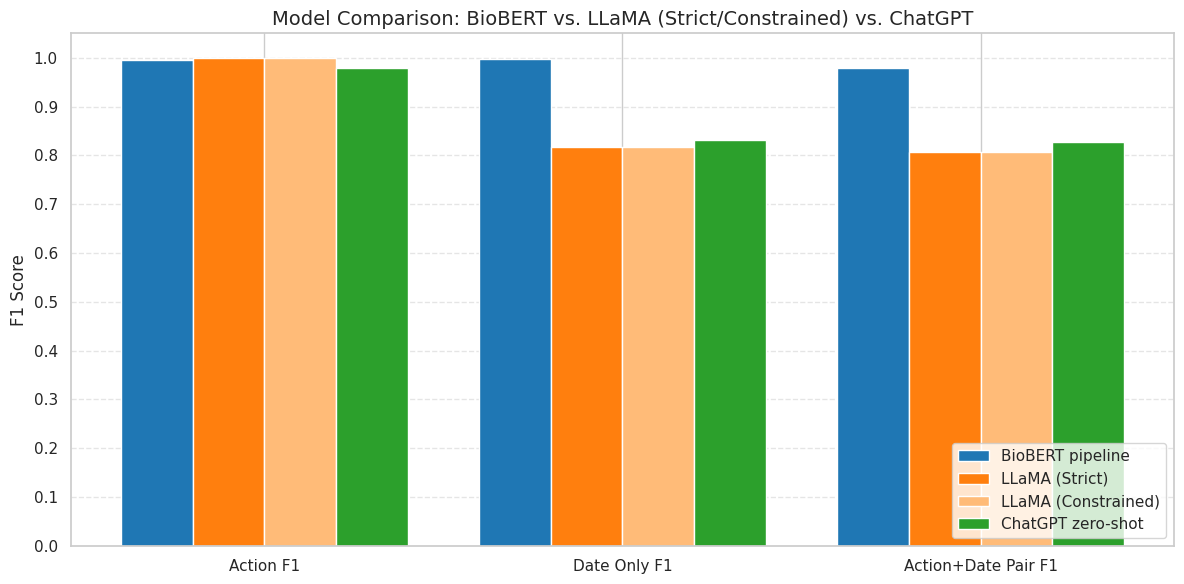


--- BioBERT NER Token Confusion Matrix ---
✅ BioBERT model loaded from biobert_joint_ner_link/checkpoint-300/model.safetensors for CM.


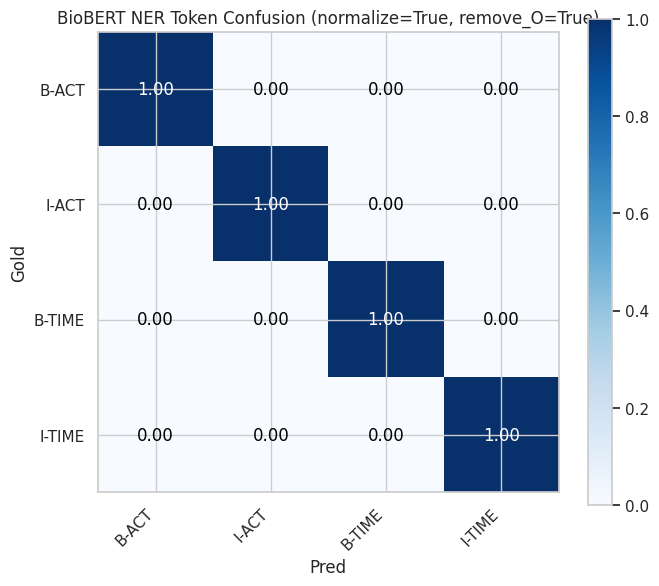


--- Summary of Key Insights from Plots ---

1. **Model Comparison (F1 Scores)**:
   - **BioBERT Pipeline**: Demonstrates superior performance across all F1 metrics (Action Span F1, Time Span F1, Linked Pair F1, and Action+Date F1), consistently scoring near perfect. This indicates its strong capability in accurately identifying and linking clinical entities.
   - **LLaMA Fine-tuned**: Performs very well on Action Span F1, but shows a notable drop in performance for Time Span F1, Linked Pair F1, and Action+Date F1 compared to BioBERT, suggesting limitations in accurately extracting or linking time information.
   - **ChatGPT Zero-Shot**: Shows the lowest F1 scores among the three, highlighting the challenges of zero-shot performance on specialized clinical information extraction where domain-specific knowledge is critical.

2. **Training and Validation Loss for Fine-tuned Llama Model**:
   - The plot shows that both training loss and validation loss decrease over training steps, sugges

In [ ]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch
import glob
from safetensors.torch import load_file

# --- 0. Helper functions (if not already defined globally in notebook) ---

def _get(d, k, default=np.nan):
    return d.get(k, default) if isinstance(d, dict) else default

def plot_cm(cm, labels, title, normalize=False, figsize=(7,6)):
    cm = cm.astype(np.float64)
    if normalize:
        row_sums = cm.sum(axis=1, keepdims=True)
        row_sums[row_sums == 0] = 1
        cm = cm / row_sums

    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation="nearest", cmap="Blues")
    plt.title(title)
    plt.colorbar()
    ticks = np.arange(len(labels))
    plt.xticks(ticks, labels, rotation=45, ha="right")
    plt.yticks(ticks, labels)
    plt.ylabel("Gold")
    plt.xlabel("Pred")

    # annotate
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            val = cm[i, j]
            txt = f"{val:.2f}" if normalize else f"{int(val)}"
            plt.text(j, i, txt, ha="center", va="center", color="black" if val < cm.max()/2 else "white")

    plt.tight_layout()
    plt.show()


# --- 1. Fix the Mapping using the CORRECT keys ---
llama_strict_standardized = {
    # Map 'ner_span_ACT_f1' -> 'STRICT_action_f1'
    "ner_span_ACT_f1": metrics_llama.get("STRICT_action_f1", 0.0),
    "ner_span_TIME_f1": metrics_llama.get("STRICT_date_only_f1", 0.0),
    "linked_pair_f1": metrics_llama.get("STRICT_action_date_f1", 0.0),
}

llama_constrained_standardized = {
    # Map 'ner_span_ACT_f1' -> 'CONSTRAINED_action_f1'
    "ner_span_ACT_f1": metrics_llama.get("CONSTRAINED_action_f1", 0.0),
    "ner_span_TIME_f1": metrics_llama.get("STRICT_date_only_f1", 0.0), # Usually same as strict for date only
    "linked_pair_f1": metrics_llama.get("CONSTRAINED_action_date_f1", 0.0),
}
# --- Update the Comparison Dictionary ---
metrics_by_model = {
    "BioBERT pipeline": bert_metrics,
    "LLaMA (Strict)": llama_strict_standardized,       # New Bar 1
    "LLaMA (Constrained)": llama_constrained_standardized, # New Bar 2
    "ChatGPT zero-shot": gpt_metrics,
}

# --- 2. Grouped Bar Chart for F1 Scores ---

metric_keys = [
    ("ner_span_ACT_f1", "Action F1"),
    ("ner_span_TIME_f1", "Date Only F1"),
    ("linked_pair_f1", "Action+Date Pair F1"),
]

models = list(metrics_by_model.keys())
labels = [m[1] for m in metric_keys]

# Extract values safely
vals = np.array([[ _get(metrics_by_model[model], k, default=0.0) for (k, _) in metric_keys ] for model in models], dtype=float)

x = np.arange(len(labels))
# Adjust bar width dynamically based on number of models (now 4)
bar_w = 0.8 / len(models)

plt.figure(figsize=(12, 6))

# Define colors manually to make Strict/Constrained look related but distinct
colors = ['#1f77b4', '#ff7f0e', '#ffbb78', '#2ca02c'] # Blue, Orange, Light Orange, Green
# Blue=BioBERT, Orange=Llama Strict, Light Orange=Llama Constrained, Green=ChatGPT

for i, model_name in enumerate(models):
    plt.bar(x + i*bar_w - 0.4 + bar_w/2, vals[i], width=bar_w, label=model_name, color=colors[i])

plt.xticks(x, labels, rotation=0, fontsize=11)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylim(0, 1.05)
plt.ylabel("F1 Score", fontsize=12)
plt.title("Model Comparison: BioBERT vs. LLaMA (Strict/Constrained) vs. ChatGPT", fontsize=14)
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# --- 3. BioBERT NER Token Confusion Matrix ---
print("\n--- BioBERT NER Token Confusion Matrix ---")

# Re-define necessary globals and load model for this specific plot if not already in scope
# (Assuming BioBertNerLinker, MODEL_NAME, NUM_TAGS, DEVICE, tokenizer are defined from previous cells)

# Ensure BioBertNerLinker class is defined
if 'BioBertNerLinker' not in globals():
    print("Error: BioBertNerLinker class not found. Please ensure its definition cell is executed.")
else:
    # Correct MODEL_NAME for BioBERT
    LOCAL_BIOBERT_MODEL_NAME = "dmis-lab/biobert-base-cased-v1.1"
    # Load BioBERT model for this task
    biobert_model_for_cm = BioBertNerLinker(LOCAL_BIOBERT_MODEL_NAME, NUM_TAGS)
    ckpts = glob.glob("biobert_joint_ner_link/checkpoint-*/pytorch_model.bin")
    if not ckpts:
        ckpts = glob.glob("biobert_joint_ner_link/checkpoint-*/model.safetensors")

    if ckpts:
        ckpt_path = ckpts[0]
        if ckpt_path.endswith(".safetensors"):
            state_dict = load_file(ckpt_path)
            biobert_model_for_cm.load_state_dict(state_dict)
        else:
            biobert_model_for_cm.load_state_dict(torch.load(ckpt_path, map_location=DEVICE))
        biobert_model_for_cm.to(DEVICE)
        print(f"✅ BioBERT model loaded from {ckpt_path} for CM.")

        # Re-define id2tag and test_dl if needed
        id2tag = {
          0:"O",
          1:"B-ACT", 2:"I-ACT",
          3:"B-TIME",4:"I-TIME",
        }

        # Ensure test_dl is available (from previous dataset creation cell, e.g., GU14SM-yb4pb)
        from torch.utils.data import DataLoader
        if 'ds_test_clean' in globals():
            test_dl_cm = DataLoader(ds_test_clean, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collator)
        elif 'test_ds' in globals():
            test_dl_cm = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collator)
        else:
            test_dl_cm = None
            print("Warning: No suitable test dataset found for CM. Please ensure 'ds_test_clean' or 'test_ds' is defined.")

        if test_dl_cm and biobert_model_for_cm and DEVICE and id2tag:
            # Function to plot NER token confusion (from previous cell LNzN8RXjqwKy)
            @torch.no_grad()
            def plot_ner_token_confusion_func(model_instance, loader, device, id2tag_map, remove_O=False, normalize=True):
                model_instance.eval()
                all_true, all_pred = [], []

                for batch in loader:
                    input_ids = batch["input_ids"].to(device)
                    attn = batch["attention_mask"].to(device)
                    gold = batch["ner_labels"].to(device)  # [B,L] with -100 for padding

                    out = model_instance(input_ids=input_ids, attention_mask=attn)
                    ner_logits = out["ner_logits"]
                    pred = ner_logits.argmax(dim=-1)  # [B,L]

                    gold_np = gold.view(-1).detach().cpu().numpy()
                    pred_np = pred.view(-1).detach().cpu().numpy()

                    mask = gold_np != -100
                    gold_np = gold_np[mask]
                    pred_np = pred_np[mask]

                    all_true.append(gold_np)
                    all_pred.append(pred_np)

                y_true = np.concatenate(all_true)
                y_pred = np.concatenate(all_pred)

                labels_numeric = sorted(list(id2tag_map.keys()))
                tags = [id2tag_map[i] for i in labels_numeric]

                if remove_O and "O" in tags:
                    o_numeric_id = [k for k,v in id2tag_map.items() if v == "O"][0]
                    keep_mask = (y_true != o_numeric_id)
                    y_true = y_true[keep_mask]
                    y_pred = y_pred[keep_mask]
                    labels_numeric = [lbl for lbl in labels_numeric if lbl != o_numeric_id]
                    tags = [id2tag_map[i] for i in labels_numeric]

                cm = confusion_matrix(y_true, y_pred, labels=labels_numeric)
                plot_cm(cm, tags, title=f"BioBERT NER Token Confusion (normalize={normalize}, remove_O={remove_O})", normalize=normalize)

            plot_ner_token_confusion_func(biobert_model_for_cm, test_dl_cm, DEVICE, id2tag, remove_O=True, normalize=True)
        else:
            print("⚠️ No BioBERT checkpoint found for CM plotting. Skipping.")


In [ ]:
import matplotlib.pyplot as plt


In [ ]:
# Create the reverse mapping from your existing id2tag
if 'id2tag' in globals() and 'TAG2ID' not in globals():
    TAG2ID = {v: k for k, v in id2tag.items()}

Date quality (Exact acc + MAE)

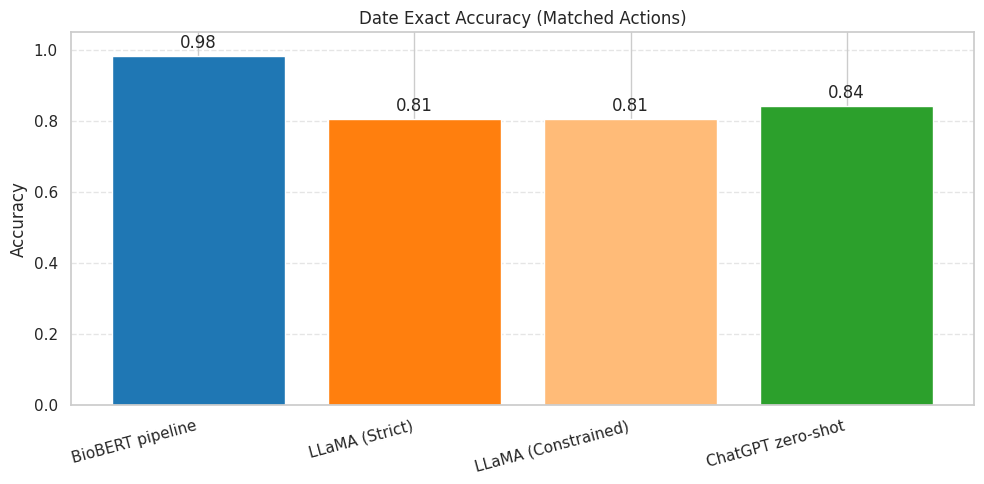

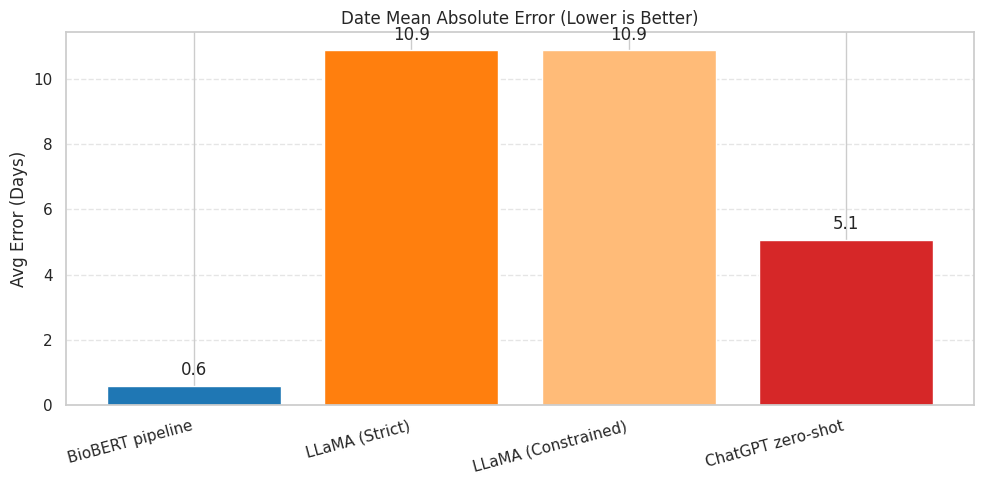

In [ ]:

import matplotlib.pyplot as plt
import numpy as np

#Helper to safely get values
def _get(d, k, default=0.0):
    return d.get(k, default)

# --- 1. Fix the Mapping (Include Date Metrics) ---
# We need to map the JSON keys to the keys your plotting code expects.

llama_strict_standardized = {
    # F1 Scores (for the first plot)
    "ner_span_ACT_f1": llama_metrics.get("ACTION_f1", 0.0),
    "ner_span_TIME_f1": llama_metrics.get("DATE_ONLY_f1", 0.0),
    "linked_pair_f1": llama_metrics.get("action_date_f1", 0.0),

    # --- NEW: Date Accuracy Metrics (For the plots you are fixing) ---
    "period_date_exact_acc_on_matched_actions": llama_metrics.get("period_date_exact_acc_on_matched_actions", 0.0),
    "period_date_abs_err_days_mae_on_matched_actions": llama_metrics.get("period_date_abs_err_days_mae_on_matched_actions", 0.0)
}

llama_constrained_standardized = {
    # F1 Scores
    "ner_span_ACT_f1": llama_metrics.get("ACTION_f1", 0.0),
    "ner_span_TIME_f1": llama_metrics.get("DATE_ONLY_f1", 0.0),
    "linked_pair_f1": llama_metrics.get("action_date_f1", 0.0),

    # --- NEW: Date Accuracy Metrics ---
    # (Constrained is the same as Strict in this JSON since hallucinations are already 0)
    "period_date_exact_acc_on_matched_actions": llama_metrics.get("period_date_exact_acc_on_matched_actions", 0.0),
    "period_date_abs_err_days_mae_on_matched_actions": llama_metrics.get("period_date_abs_err_days_mae_on_matched_actions", 0.0)
}

# --- 2. Re-Assemble the Master Dictionary ---
metrics_by_model = {
    "BioBERT pipeline": bert_metrics,
    "LLaMA (Strict)": llama_strict_standardized,
    "LLaMA (Constrained)": llama_constrained_standardized,
    "ChatGPT zero-shot": gpt_metrics,
}

# --- 3. Plotting Code (Unchanged) ---
metric_keys = [
    ("period_date_exact_acc_on_matched_actions", "Date Exact Acc"),
    ("period_date_abs_err_days_mae_on_matched_actions", "Date MAE (days)"),
]

models = list(metrics_by_model.keys())
# Extract values using the helper
vals = { model: {k: _get(metrics_by_model[model], k) for k,_ in metric_keys} for model in models }

# Plot Date Exact Accuracy
plt.figure(figsize=(10,5))
accs = [vals[m]["period_date_exact_acc_on_matched_actions"] for m in models]
bars = plt.bar(models, accs, color=['#1f77b4', '#ff7f0e', '#ffbb78', '#2ca02c'])
plt.ylim(0, 1.05)
plt.ylabel("Accuracy")
plt.title("Date Exact Accuracy (Matched Actions)")
plt.xticks(rotation=15, ha="right")
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Add labels
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f"{yval:.2f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Plot Date MAE
plt.figure(figsize=(10,5))
maes = [vals[m]["period_date_abs_err_days_mae_on_matched_actions"] for m in models]
# Use different color for MAE to indicate "Lower is Better" logic? Or keep consistent.
bars = plt.bar(models, maes, color=['#1f77b4', '#ff7f0e', '#ffbb78', '#d62728']) # Red for ChatGPT high error
plt.ylabel("Avg Error (Days)")
plt.title("Date Mean Absolute Error (Lower is Better)")
plt.xticks(rotation=15, ha="right")
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Add labels
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.2, f"{yval:.1f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [ ]:

# --- BioBERT NER Token Confusion Matrix ---
print("\n--- BioBERT NER Token Confusion Matrix ---")

# Re-define necessary globals and load model for this specific plot if not already in scope
# (Assuming BioBertNerLinker, MODEL_NAME, NUM_TAGS, DEVICE, tokenizer are defined from previous cells)

# Ensure BioBertNerLinker class is defined
if 'BioBertNerLinker' not in globals():
    print("Error: BioBertNerLinker class not found. Please ensure its definition cell is executed.")
else:
    # Correct MODEL_NAME for BioBERT
    LOCAL_BIOBERT_MODEL_NAME = "dmis-lab/biobert-base-cased-v1.1"
    # Load BioBERT model for this task
    biobert_model_for_cm = BioBertNerLinker(LOCAL_BIOBERT_MODEL_NAME, NUM_TAGS)
    ckpts = glob.glob("biobert_joint_ner_link/checkpoint-*/pytorch_model.bin")
    if not ckpts:
        ckpts = glob.glob("biobert_joint_ner_link/checkpoint-*/model.safetensors")

    if ckpts:
        ckpt_path = ckpts[0]
        if ckpt_path.endswith(".safetensors"):
            state_dict = load_file(ckpt_path)
            biobert_model_for_cm.load_state_dict(state_dict)
        else:
            biobert_model_for_cm.load_state_dict(torch.load(ckpt_path, map_location=DEVICE))
        biobert_model_for_cm.to(DEVICE)
        print(f"\u2705 BioBERT model loaded from {ckpt_path} for CM.")

        # Re-define id2tag and test_dl if needed
        id2tag = {
          0:"O",
          1:"B-ACT", 2:"I-ACT",
          3:"B-TIME",4:"I-TIME",
        }

        # Ensure test_dl is available (from previous dataset creation cell, e.g., GU14SM-yb4pb)
        from torch.utils.data import DataLoader
        if 'ds_test_clean' in globals():
            test_dl_cm = DataLoader(ds_test_clean, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collator)
        elif 'test_ds' in globals():
            test_dl_cm = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collator)
        else:
            test_dl_cm = None
            print("Warning: No suitable test dataset found for CM. Please ensure 'ds_test_clean' or 'test_ds' is defined.")

        if test_dl_cm and biobert_model_for_cm and DEVICE and id2tag:
            # Function to plot NER token confusion (from previous cell LNzN8RXjqwKy)
            @torch.no_grad()
            def plot_ner_token_confusion_func(model_instance, loader, device, id2tag_map, remove_O=False, normalize=True):
                model_instance.eval()
                all_true, all_pred = [], []

                for batch in loader:
                    input_ids = batch["input_ids"].to(device)
                    attn = batch["attention_mask"].to(device)
                    gold = batch["ner_labels"].to(device)  # [B,L] with -100 for padding

                    out = model_instance(input_ids=input_ids, attention_mask=attn)
                    ner_logits = out["ner_logits"]
                    pred = ner_logits.argmax(dim=-1)  # [B,L]

                    gold_np = gold.view(-1).detach().cpu().numpy()
                    pred_np = pred.view(-1).detach().cpu().numpy()

                    mask = gold_np != -100
                    gold_np = gold_np[mask]
                    pred_np = pred_np[mask]

                    all_true.append(gold_np)
                    all_pred.append(pred_np)

                y_true = np.concatenate(all_true)
                y_pred = np.concatenate(all_pred)

                labels_numeric = sorted(list(id2tag_map.keys()))
                tags = [id2tag_map[i] for i in labels_numeric]

                if remove_O and "O" in tags:
                    o_numeric_id = [k for k,v in id2tag_map.items() if v == "O"][0]
                    keep_mask = (y_true != o_numeric_id)
                    y_true = y_true[keep_mask]
                    y_pred = y_pred[keep_mask]
                    labels_numeric = [lbl for lbl in labels_numeric if lbl != o_numeric_id]
                    tags = [id2tag_map[i] for i in labels_numeric]

                cm = confusion_matrix(y_true, y_pred, labels=labels_numeric)
                plot_cm(cm, tags, title=f"BioBERT NER Token Confusion (normalize={normalize}, remove_O={remove_O})", normalize=normalize)

            plot_ner_token_confusion_func(biobert_model_for_cm, test_dl_cm, DEVICE, id2tag, remove_O=True, normalize=True)
        else:
            print("\u26a0\ufe0f No BioBERT model, test_dl_cm, DEVICE, or id2tag properly initialized for NER CM plotting. Skipping.")
    else:
        print("\u26a0\ufe0f No BioBERT checkpoint found for CM plotting. Skipping.")

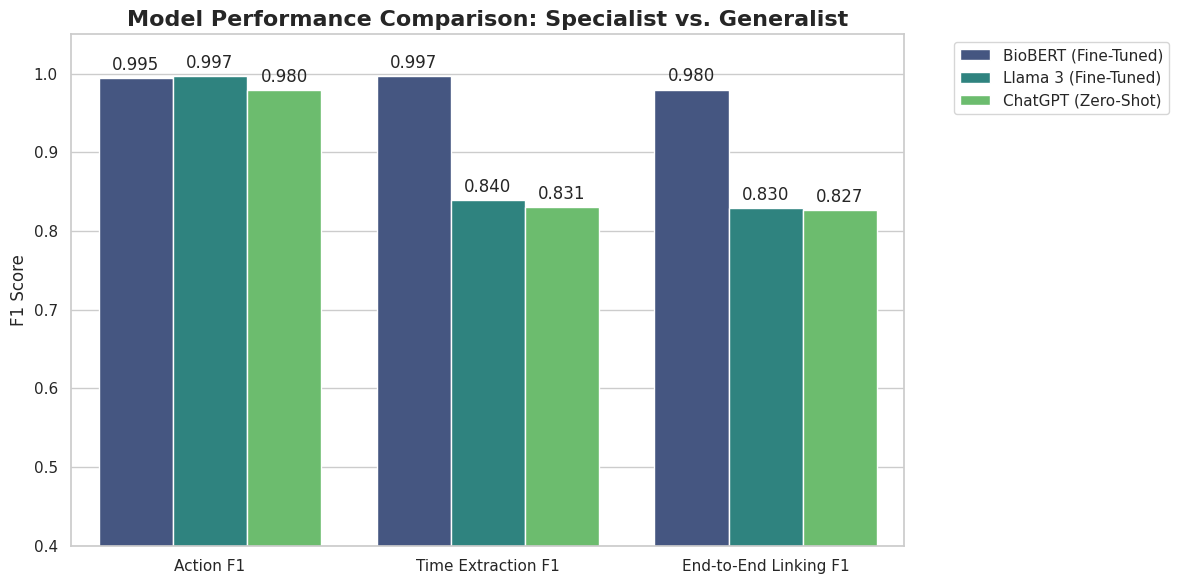

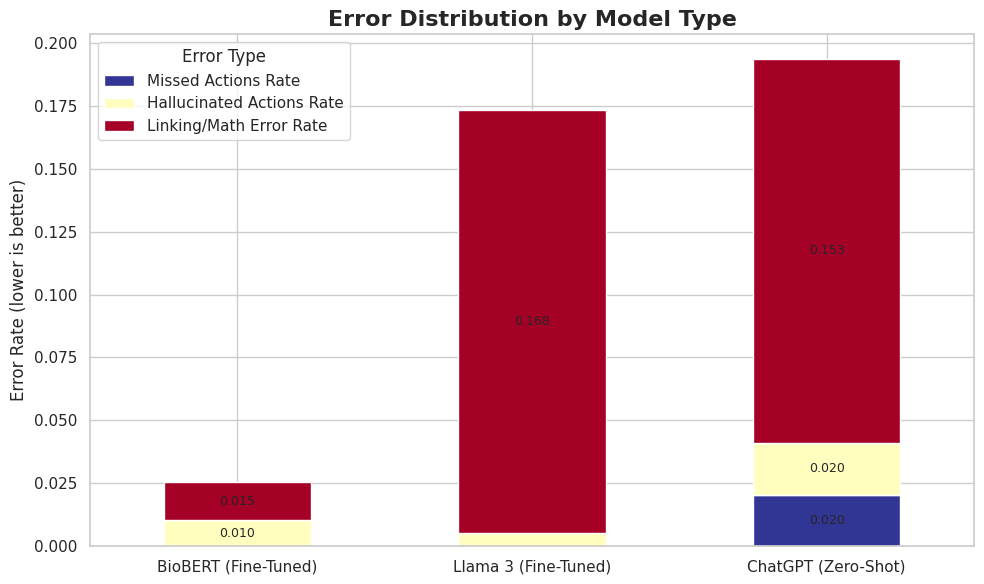

/tmp/ipython-input-4221725020.py:191: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax3 = sns.barplot(data=df, x="Model", y="Date Calculation Error (MAE Days)", palette=colors)


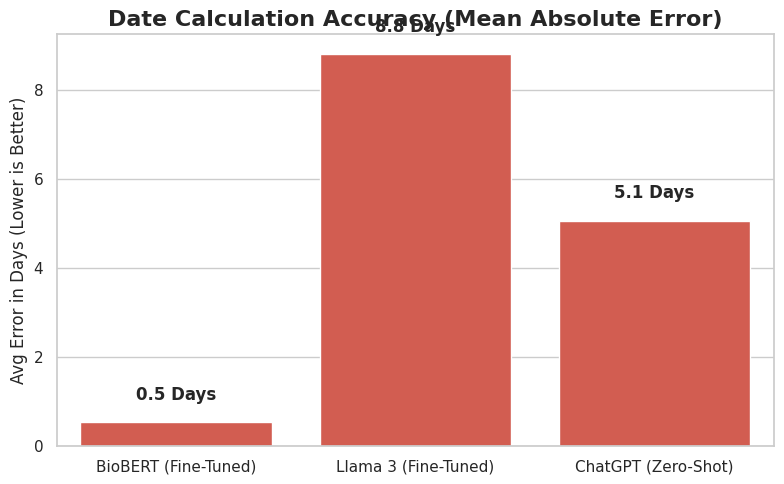

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# ==========================================
# 1. Load Data (Using your provided dictionaries)
# ==========================================
metrics_gpt = gpt_metrics
# ==========================================
# 2. Helper Functions to Normalize Data
# ==========================================

# Standardize keys since models use slightly different naming conventions
data = []

# --- BioBERT ---
data.append({
    "Model": "BioBERT (Fine-Tuned)",
    "Action F1": metrics_biobert["ner_span_ACT_f1"],
    "Time Extraction F1": metrics_biobert["ner_span_TIME_f1"],
    "End-to-End Linking F1": metrics_biobert["action_date_f1"],
    "Date Calculation Error (MAE Days)": metrics_biobert["period_date_abs_err_days_mae_on_matched_actions"],
    # For error plot: Calculate implied error rate (1 - Recall = Missed, 1 - Precision = Wrong)
    "Missed Actions Rate": 1 - metrics_biobert["ner_span_ACT_recall"],
    "Hallucinated Actions Rate": 1 - metrics_biobert["ner_span_ACT_precision"],
    # "Linking Error Rate": 1 - metrics_biobert["linked_pair_recall"]
    "Linking/Math Error Rate": metrics_biobert["ner_span_ACT_recall"] - metrics_biobert["linked_pair_recall"]
})

# --- Llama ---
data.append({
    "Model": "Llama 3 (Fine-Tuned)",
    # Map 'STRICT_action_f1' -> 'Action F1'
    "Action F1": metrics_llama.get("STRICT_action_f1", 0),
    "Time Extraction F1": metrics_llama.get("STRICT_date_only_f1", 0),
    "End-to-End Linking F1": metrics_llama.get("STRICT_action_date_f1", 0),
    "Date Calculation Error (MAE Days)": metrics_llama.get("period_date_abs_err_days_mae_on_matched_actions", 0),
    "Missed Actions Rate": 1 - metrics_llama.get("STRICT_action_recall", 0),
    "Hallucinated Actions Rate": 1 - metrics_llama.get("STRICT_action_precision", 0),
    # Linking Error = (Actions Found) - (Pairs Correct)
    "Linking/Math Error Rate": metrics_llama.get("STRICT_action_recall", 0) - metrics_llama.get("STRICT_action_date_recall", 0)
})
# --- ChatGPT ---
data.append({
    "Model": "ChatGPT (Zero-Shot)",
    "Action F1": metrics_gpt["ner_span_ACT_f1"],
    "Time Extraction F1": metrics_gpt["ner_span_TIME_f1"],
    "End-to-End Linking F1": metrics_gpt["action_date_f1"],
    "Date Calculation Error (MAE Days)": metrics_gpt["period_date_abs_err_days_mae_on_matched_actions"],
    "Missed Actions Rate": 1 - metrics_gpt["ner_span_ACT_recall"],
    "Hallucinated Actions Rate": 1 - metrics_gpt["ner_span_ACT_precision"],
    #"Linking Error Rate": 1 - metrics_gpt["linked_pair_recall"]
    "Linking/Math Error Rate": metrics_gpt["ner_span_ACT_recall"] - metrics_gpt["linked_pair_recall"]
})

df = pd.DataFrame(data)

# Set global style
sns.set_theme(style="whitegrid")
plt.rcParams.update({'font.size': 12})

# ==========================================
# Plot 1: The "Money Slide" (Grouped Bar Chart)
# ==========================================
# We need to melt the dataframe to make it suitable for a grouped bar chart
df_melted = df.melt(id_vars="Model",
                    value_vars=["Action F1", "Time Extraction F1", "End-to-End Linking F1"],
                    var_name="Task", value_name="F1 Score")

plt.figure(figsize=(12, 6))
ax = sns.barplot(data=df_melted, x="Task", y="F1 Score", hue="Model", palette="viridis")
plt.title("Model Performance Comparison: Specialist vs. Generalist", fontsize=16, weight='bold')
plt.ylim(0.4, 1.05)  # Start y-axis at 0.4 to emphasize differences
plt.ylabel("F1 Score")
plt.xlabel("")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Add text labels on bars
for container in ax.containers:
    #ax.bar_label(container, fmt='%.2f', padding=3)
    ax.bar_label(container, fmt='%.3f', padding=3)


plt.tight_layout()
plt.show()

# ==========================================
# Plot 2: Error Analysis (Stacked Bar Chart)
# ==========================================
# Compare what kind of mistakes they make
error_cols = ["Missed Actions Rate", "Hallucinated Actions Rate", "Linking/Math Error Rate"]
df_errors = df.set_index("Model")[error_cols]

# Plot
ax2 = df_errors.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='RdYlBu_r')
plt.title("Error Distribution by Model Type", fontsize=16, weight='bold')
plt.ylabel("Error Rate (lower is better)")
plt.xlabel("")
plt.xticks(rotation=0)
plt.legend(title="Error Type")

# Annotate
for c in ax2.containers:
    labels = [f'{v.get_height():.3f}' if v.get_height() > 0.01 else '' for v in c]
    ax2.bar_label(c, labels=labels, label_type='center', fontsize=9)

plt.tight_layout()
plt.show()

# ==========================================
# Plot 3: Date Reasoning Accuracy (MAE)
# ==========================================
# This compares the "Symbolic" power (BioBERT + Rule Engine) vs "Generative" power (LLMs)

plt.figure(figsize=(8, 5))
colors = ['#2ecc71' if x == 0 else '#e74c3c' for x in df["Date Calculation Error (MAE Days)"]]
ax3 = sns.barplot(data=df, x="Model", y="Date Calculation Error (MAE Days)", palette=colors)

plt.title("Date Calculation Accuracy (Mean Absolute Error)", fontsize=16, weight='bold')
plt.ylabel("Avg Error in Days (Lower is Better)")
plt.xlabel("")

# Add explanatory text for BioBERT
for i, p in enumerate(ax3.patches):
    height = p.get_height()
    ax3.text(p.get_x() + p.get_width() / 2., height + 0.5,
             f'{height:.1f} Days', ha="center", weight='bold')

plt.tight_layout()
plt.show()

In [ ]:

note_3 = """
Date of Visit: 2025-11-01

History: Patient is seen 2 weeks post-op from laparoscopic appendectomy. Incisions are well-healed.
No signs of erythema or drainage. Bowel function has returned to normal.

Plan:
- order an Abdominal Ultrasound this Friday in 6 weeks.
- If the ultrasound is negative resume gym activity.
"""

print("\n--- Processing Note 3 ---")
predictions_3 = predict_json(note_3)
print(json.dumps(predictions_3, indent=2))


--- Processing Note 3 ---
[
  {
    "action": "Abdominal Ultrasound",
    "period_text": "in 6 weeks",
    "period_date": "2025-12-13"
  }
]


In [ ]:
# Using the debug_ner_detection function to inspect token tags for the current full_note
# This function is defined in cell
debug_ner_detection(biobert_model, biobert_tokenizer, note_3, DEVICE)


Scanning text: '
Date of Visit: 2025-11-01

History: Patient is seen 2 weeks post-op from laparoscopic appendectomy. Incisions are well-healed. No signs of erythema or drainage. Bowel function has returned to normal.

Plan:
- order an Abdominal Ultrasound this Friday in 6 weeks.
- If the ultrasound is negative resume gym activity.
'
----------------------------------------
TOKEN           TAG ID     DECODED TAG
----------------------------------------
abdominal       1          B-ACT
ultra           2          I-ACT
##sound         2          I-ACT
in              3          B-TIME
6               4          I-TIME
weeks           4          I-TIME
